In [1]:

import os.path

import matplotlib.pyplot as plt
import numpy as np
from jedi.parser_utils import function_is_staticmethod
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorboard.notebook import display

from farich_functions import *

plt.rcParams['font.size'] = 12

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def enforce_float32(df):
    return df.astype({col: np.float32 for col in df.select_dtypes(include=['float64']).columns})

In [4]:
mu_mass = 105.65
pi_mass = 139.57
ka_mass = 493.68

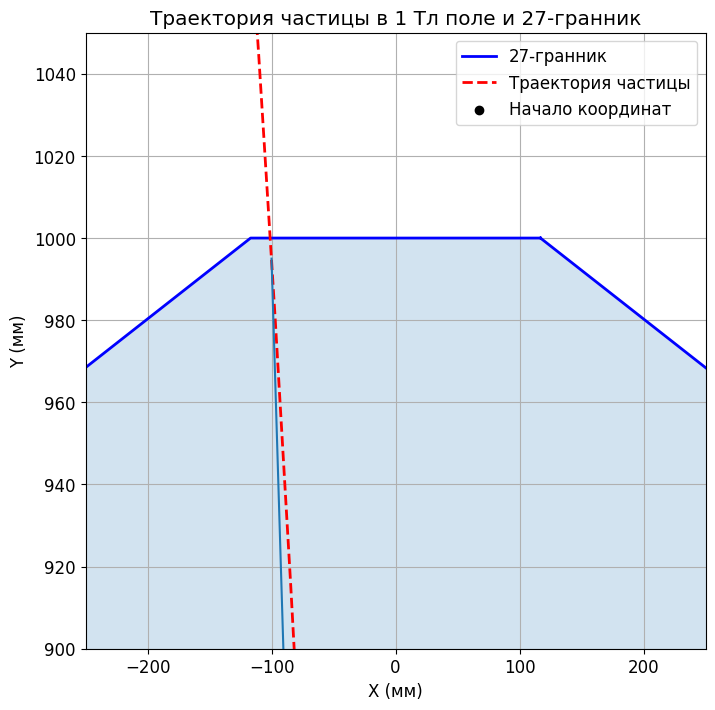

In [6]:
# --- Параметры многоугольника ---
num_sides = 27
distance_to_flat_face = 1000  # мм

angle_between = 2 * np.pi / num_sides
angle_offset = np.pi / 2 - angle_between / 2

angles = np.linspace(0, 2 * np.pi, num_sides + 1)
angles += angle_offset

radius = distance_to_flat_face / np.cos(np.pi / num_sides)
x_poly = radius * np.cos(angles)
y_poly = radius * np.sin(angles)

# --- Параметры частицы и траектории ---
B = 1.0  # Тл
p = 1.5  # ГэВ/с
q = 1    # элементарный заряд

R = p / (0.3 * B)  # радиус в метрах
R_mm = R * 1000    # радиус в мм

# Центр окружности, если частица стартует в начале координат и летит вверх
# Значит центр окружности находится на оси X, слева от начала координат
center_x = -R_mm  # мм
center_y = 0

# Построим дугу окружности (1/2 круга, пока что)
theta = np.linspace(0, np.pi/2 + np.pi/3, 200)
x_arc = center_x + R_mm * np.cos(theta)
y_arc = center_y + R_mm * np.sin(theta)

# --- Построение ---
plt.figure(figsize=(8, 8))
plt.plot(x_poly, y_poly, 'b-', linewidth=2, label='27-гранник')
plt.fill(x_poly, y_poly, alpha=0.2)

plt.plot(x_arc, y_arc, 'r--', linewidth=2, label='Траектория частицы')

# Метки
plt.scatter([0], [0], color='black', label='Начало координат')
# plt.text(0, -200, "p = 1.5 ГэВ/c\nB = 1 Тл", ha='center', fontsize=10)

plt.plot([0, -0.1 * 1000], [0, 3000 * np.sqrt(11) / 10])
# plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.xlabel("X (мм)")
plt.ylabel("Y (мм)")
plt.title("Траектория частицы в 1 Тл поле и 27-гранник")
plt.legend()
plt.xlim((-250, 250))
plt.ylim((900, 1050))
plt.show()

In [49]:
1000*(np.sqrt(24) - 5)

-101.02051443364424

In [24]:
3000 * np.sqrt(11) / 10

994.9874371066201

In [23]:
np.tan(2 * np.pi / 27 / 2) * 1000

116.88323675815263

In [5]:
def create_edf_for_field( # needs reworking for using intersection point from farich itself
    filepath_to_first="fullsim_3particles_40000_ka_bin_3_FARICH_35mm_1000_no_trackers.root",
    num_of_files=10,
    uncertain_angle=False,
):
    datadir = "data"
    sipm_eff, PDE_wvs = init_sipm_eff()
    for key in sipm_eff.keys():
        sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

    x_grid = np.arange(
        -3 * norm_r * np.sin(np.pi / 27),
        3 * norm_r * np.sin(np.pi / 27),
        SIPM_CELL_SIZE,
    )
    z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
    grid = (x_grid, z_grid, PDE_wvs)

    split_filepath = filepath_to_first.split("_1_")
    filepath_binned = os.path.join(
        datadir, f"{split_filepath[0]}_{1}_{split_filepath[1]}"
    )
    file_binned = uproot.open(filepath_binned)
    coordinates, true_direction_coordinates, intersections, ids = init_coords_for_field(
        file_binned, grid
    )
    if num_of_files > 1:
        for i in range(2, num_of_files + 1):
            filepath_binned = os.path.join(
                datadir, f"{split_filepath[0]}_{i}_{split_filepath[1]}"
            )
            file_binned = uproot.open(filepath_binned)
            coordinates_i, true_direction_coordinates_i, intersections_i, ids_i = init_coords_for_field(
                file_binned, grid
            )
            coordinates = np.concatenate((coordinates, coordinates_i), axis=0)
            true_direction_coordinates = np.concatenate(
                (true_direction_coordinates, true_direction_coordinates_i), axis=0
            )
            intersections = np.concatenate((intersections, intersections_i), axis=0)
            ids = np.concatenate((ids, ids_i), axis=0)


    idx_to_drop = []
    for i in range(coordinates.shape[0]):
        if coordinates[i][0].shape[0] == 0:
            idx_to_drop.append(i)

    coordinates = np.delete(coordinates, idx_to_drop, axis=0)
    true_direction_coordinates = np.delete(
        true_direction_coordinates, idx_to_drop, axis=0
    )
    intersections = np.delete(intersections, idx_to_drop, axis=0)
    ids = np.delete(ids, idx_to_drop)
    print(coordinates.shape)
    print(true_direction_coordinates.shape)

    true_direction_coordinates = intersections / np.linalg.norm(intersections, axis=1)[:, None] * np.linalg.norm(true_direction_coordinates, axis=1)[:, None]

    if uncertain_angle:
        uncertainty_introduction_to_direction(true_direction_coordinates)

    sipm_sim(coordinates, sipm_eff)
    for i, coord in enumerate(coordinates):
        if coord[0].shape[0] == 0:
            coord[0] = np.atleast_1d(np.array(intersections[i][0]))
            coord[1] = np.atleast_1d(np.array(intersections[i][1]))
            coord[2] = np.atleast_1d(np.array(intersections[i][2]))
            coord[3] = np.atleast_1d(np.array(450))
            coord[4] = np.atleast_1d(np.array(0.633))

    # may need to drop that deletion for the sake of keeping events
    # idx_to_drop = []
    # for i in range(coordinates.shape[0]):
    #     if coordinates[i][0].shape[0] == 0:
    #         idx_to_drop.append(i)
    # coordinates = np.delete(coordinates, idx_to_drop, axis=0)
    # true_direction_coordinates = np.delete(
    #     true_direction_coordinates, idx_to_drop, axis=0
    # )
    # print(coordinates.shape)
    # print(true_direction_coordinates.shape)

    main_angles = rotate_lines_for_decay(intersections)
    intersections = find_intersections_for_decay(intersections)
    rotate_events(coordinates, main_angles)
    move_events_to_grid(coordinates, grid)
    repeat_nums = np.array([coord[0].shape[0] for coord in coordinates])
    edf = pd.DataFrame(coordinates, columns=["x_c", "y_c", "z_c", "wv_c", "t_c"])

    unraveled_data = {col: [] for col in edf.columns}
    row_indices = []

    # Iterate over the DataFrame and unravel the arrays
    for i, row in edf.iterrows():
        max_length = max(len(row[col]) for col in edf.columns)
        for k in range(max_length):
            row_indices.append((i, k))
            for col in edf.columns:
                if k < len(row[col]):
                    unraveled_data[col].append(row[col][k])
                else:
                    unraveled_data[col].append(
                        np.nan
                    )  # Handle cases where arrays are of different lengths

    # Create a new DataFrame from the unraveled data
    unraveled_df = pd.DataFrame(unraveled_data)

    # Create a MultiIndex for the rows
    multi_index = pd.MultiIndex.from_tuples(row_indices, names=["entry", "subentry"])
    unraveled_df.index = multi_index

    edf = unraveled_df

    edf["x_i"] = np.repeat(intersections[:, 0], repeat_nums, axis=0)
    edf["z_i"] = np.repeat(intersections[:, 2], repeat_nums, axis=0)

    x = y = z = x3 = y3 = z3 = unraveled_data = row_indices = main_angles =  wvs = coordinates = file = coordinates_low = file_low = 0
    
    bdf = pd.DataFrame()
    gdf = pd.DataFrame()
    gdf["nhits"] = repeat_nums

    mu_mass = 105.65
    pi_mass = 139.57
    ka_mass = 493.68
    mass = np.array([mu_mass if np.abs(ids[i]) == 13 else (ka_mass if np.abs(ids[i]) == 321 else pi_mass) for i in range(ids.shape[0])])
    edf.rename(columns={"y_c": "tmp_c"}, inplace=True)
    edf.drop("wv_c", axis=1, inplace=True)
    edf.rename(columns={"z_c": "y_c", "z_i": "y_i"}, inplace=True)
    edf.rename(columns={"tmp_c": "z_c"}, inplace=True)
    # edf["z_c"] = np.zeros(edf.shape[0]) + 1000  # why 2000?
    # edf["mass"] = np.ones(edf.shape[0]) * mass
    edf["mass"] = np.repeat(
        mass,
        repeat_nums,
        axis=0,
    )
    edf["true_p"] = np.repeat(
        np.linalg.norm(true_direction_coordinates.astype("float"), axis=1) * 1000,
        repeat_nums,
        axis=0,
    )
    edf["beta"] = edf.true_p / np.sqrt(edf.mass**2 + edf.true_p**2)
    edf["x_p"] = np.zeros(edf.shape[0])
    edf["y_p"] = np.zeros(edf.shape[0])
    edf["z_p"] = np.zeros(edf.shape[0])
    edf["nx_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 0],
        repeat_nums,
        axis=0,
    )
    edf["ny_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 2],
        repeat_nums,
        axis=0,
    )
    edf["nz_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 1],
        repeat_nums,
        axis=0,
    )

    true_direction_coordinates = repeat_nums = true_direction_coordinates_low = intersections = 0

    return edf, bdf, gdf


In [75]:
if True:
    edf_mu, bdf_mu, gdf_mu = create_edf_for_field('fullsim_3particles_40000_mu_bin_1_FARICH_35mm_1000_no_trackers_seeded.root', num_of_files=5,
                               uncertain_angle=False)
    edf_pi, bdf_pi, gdf_pi = create_edf_for_field('fullsim_3particles_40000_pi_bin_1_FARICH_35mm_1000_no_trackers_seeded.root', num_of_files=5,
                               uncertain_angle=False)
    edf_ka, bdf_ka, gdf_ka = create_edf_for_field('fullsim_3particles_40000_ka_bin_1_FARICH_35mm_1000_no_trackers_seeded.root', num_of_files=5,
                               uncertain_angle=False)
    
    shift_ind = np.array(edf_mu.index.get_level_values(0))[-1] + 1
    new_index = edf_pi.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_pi.index = pd.MultiIndex.from_tuples(new_index, names=edf_mu.index.names)
    gdf_pi.index = np.array(gdf_pi.index) + np.array(gdf_mu.index)[-1] + 1

    shift_ind = np.array(edf_pi.index.get_level_values(0))[-1] + 1
    new_index = edf_ka.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_ka.index = pd.MultiIndex.from_tuples(new_index, names=edf_pi.index.names)
    gdf_ka.index = np.array(gdf_ka.index) + np.array(gdf_pi.index)[-1] + 1


    edf_conc = pd.concat([edf_mu, edf_pi, edf_ka])
    gdf_conc = pd.concat([gdf_mu, gdf_pi, gdf_ka])
    
    edf_mu = gdf_mu = edf_ka = gdf_ka = edf_pi = gdf_pi = 0
    edf_conc = enforce_float32(edf_conc)
    # sample_ind = np.random.choice(gdf_conc.index, size=20000, replace=False)
    # edf_conc = edf_conc.loc[sample_ind]
    # gdf_conc = gdf_conc.loc[sample_ind]
    # index_map = dict(zip(np.array(gdf_conc.index), np.linspace(0, 19999, 20000, dtype=np.int16)))
    # new_new_index = edf_conc.index.map(lambda idx: (index_map[idx[0]], idx[1]))
    # edf_conc.index = pd.MultiIndex.from_tuples(new_new_index, names=edf_conc.index.names)
    # gdf_conc.index = np.linspace(0, 19999, 20000, dtype=np.int16)

(197168, 5)
(197168, 3)
(187907, 5)
(187907, 3)
(166441, 5)
(166441, 3)


In [205]:
edf_conc.shape

(14043381, 15)

In [170]:
gdf_conc[gdf_conc.nhits == 1]

,nhits
28856,1
41873,1
42733,1
44619,1
47364,1
...,...
110986,1
110987,1
110988,1
110989,1


In [78]:
bdf_conc = pd.DataFrame()

In [112]:
edf_to_bdf(edf_conc.nx_p * edf_conc.true_p, bdf_conc)

In [81]:
edf_to_bdf(edf_conc.true_p, bdf_conc)

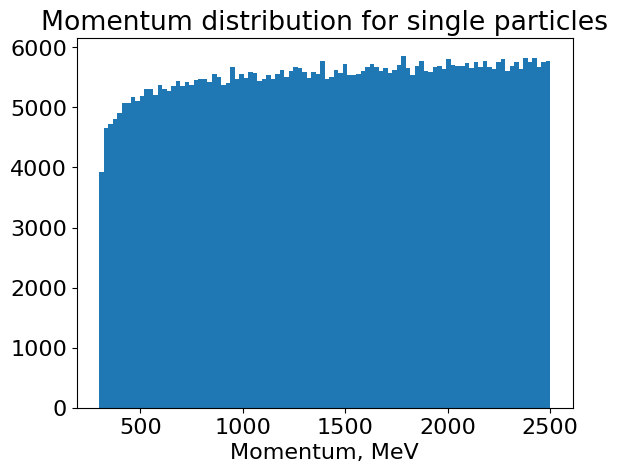

In [115]:
plt.hist(bdf_conc.true_p, bins=100)
plt.xlabel('Momentum, MeV')
plt.title('Momentum distribution for single particles')
plt.show()

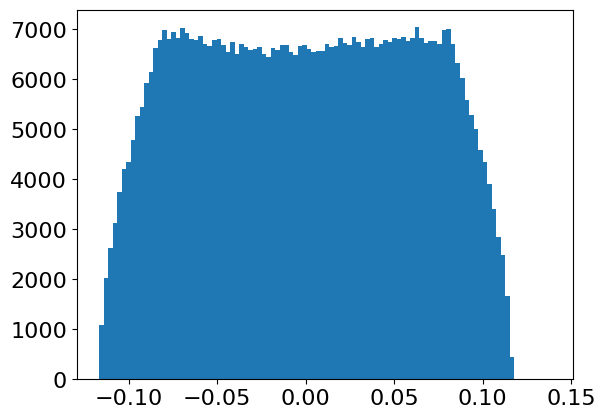

In [114]:
k_eta = 0.5 * np.log((bdf_conc.true_p + bdf_conc.nx_p) / (bdf_conc.true_p - bdf_conc.nx_p))
plt.hist(k_eta, bins=100)
plt.show()

In [113]:
bdf_conc.rename(columns={bdf_conc.columns[3] : "nx_p"}, inplace=True)

In [103]:
bdf_conc

,nz_p,true_p
0,1521.750366,2128.983154
1,1411.516479,1923.953613
2,428.033051,429.006104
3,1389.755859,1528.735107
4,987.057312,1039.406494
...,...,...
551511,2040.581421,2092.170654
551512,452.537720,546.003418
551513,1548.952148,1558.688843
551514,1201.851074,1223.832520


In [105]:
edf_conc

x_c     z_c          y_c       t_c         x_i  \
entry  subentry                                                          
0      0        -108.799866  1000.0 -1168.160034  1.463490  -66.295197   
       1         -65.119873  1000.0  -892.640015  0.752733  -66.295197   
       2         -11.359869  1000.0  -916.159973  0.793410  -66.295197   
       3          -1.279869  1000.0  -929.599976  0.805522  -66.295197   
       4         -98.719872  1000.0  -909.440002  0.773943  -66.295197   
...                     ...     ...          ...       ...         ...   
551511 16         12.160131  1000.0   206.080002  0.538521   44.712891   
551512 0          -4.639869  1000.0   673.119995  0.633000   -3.424016   
551513 0        -112.159866  1000.0    11.200000  0.633000 -111.648430   
551514 0         -75.199867  1000.0  -176.960007  0.633000  -73.952026   
551515 0          52.480129  1000.0   414.399994  0.633000   51.563774   

                        y_i        mass       true_p      beta  x_p  y_p  z_p  \
entry  subentry                                                                 
0      0        -976.169128  105.650002  2128.983154  0.998771  0.0  0.0  0.0   
       1        -976.169128  105.650002  2128.983154  0.998771  0.0  0.0  0.0   
       2        -976.169128  105.650002  2128.983154  0.998771  0.0  0.0  0.0   
       3        -976.169128  105.650002  2128.983154  0.998771  0.0  0.0  0.0   
       4        -976.169128  105.650002  2128.983154  0.998771  0.0  0.0  0.0   
...                     ...         ...          ...       ...  ...  ...  ...   
551511 16        221.817932  493.679993  2092.170654  0.973271  0.0  0.0  0.0   
551512 0         675.069885  493.679993   546.003418  0.741754  0.0  0.0  0.0   
551513 0          12.089541  493.679993  1558.688843  0.953325  0.0  0.0  0.0   
551514 0        -177.327637  493.679993  1223.832520  0.927389  0.0  0.0  0.0   
551515 0         417.556976  493.679993  1159.954224  0.920131  0.0  0.0  0.0   

                     nx_p      ny_p      nz_p  
entry  subentry                                
0      0        -0.047386 -0.697744  0.714778  
       1        -0.047386 -0.697744  0.714778  
       2        -0.047386 -0.697744  0.714778  
       3        -0.047386 -0.697744  0.714778  
       4        -0.047386 -0.697744  0.714778  
...                   ...       ...       ...  
551511 16        0.043610  0.216348  0.975342  
551512 0        -0.002838  0.559510  0.828819  
551513 0        -0.110951  0.012014  0.993753  
551514 0        -0.072624 -0.174143  0.982039  
551515 0         0.047529  0.384880  0.921742  

[17578538 rows x 15 columns]

In [3]:
# xgb.__version__

In [4]:
# momentum_from_beta(beta_from_momentum(500, pi_mass), ka_mass)

In [6]:
filepath = os.path.join("data", "decay_test_ka2.root")
filepath = os.path.join("data", "decay_test_2gamma.root")
filepath = os.path.join("data", "decay_test_KmuKpi_40000_field.root")
# filepath = os.path.join("data", "mag_field_test.root")
# filepath = os.path.join("data", "fullsim_3particles_40000_ka_bin_3_FARICH_35mm_1000_no_trackers.root")

In [7]:
file = uproot.open(filepath)

In [8]:
primary_pdgid = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.pdgId'].array())

In [9]:
farich_pdgid = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array()) # 40% К куда-то пропадают в фариче

In [83]:
pis = 0
mus = 0
for primary_particles in primary_pdgid:
    if primary_particles[3] == 211:
        pis += 1
    if primary_particles[3] == -13:
        mus += 1

In [11]:
file[file.keys()[0]]['allGenParticles'].keys()

[b'allGenParticles.core.pdgId',
 b'allGenParticles.core.charge',
 b'allGenParticles.core.status',
 b'allGenParticles.core.vertex.x',
 b'allGenParticles.core.vertex.y',
 b'allGenParticles.core.vertex.z',
 b'allGenParticles.core.p4.mass',
 b'allGenParticles.core.p4.px',
 b'allGenParticles.core.p4.py',
 b'allGenParticles.core.p4.pz',
 b'allGenParticles.core.bits']

In [14]:
x3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())
y3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())
z3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())
m3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.mass'].array())

In [162]:
primary_pdgid[10]

array([    30443,       421,      -321,       211,       111,        22,
              22,        22,      -421, 480000000])

In [106]:
22 in primary_pdgid[3]

False

In [169]:
np.random.normal(loc=1, scale=1,size=1)[0]

1.1165649521395946

In [196]:
pi_p = []
mu_p = []
ka_mu_p = []
ka_pi_p = []

e_miss = []
p_miss = []

e_miss_mu = []
p_miss_mu = []
e_miss_pi = []
p_miss_pi = []
smooth = 0.02
for i, primary_particles in enumerate(primary_pdgid):
    
    e_miss.append(3773/2 - (np.sqrt(x3[i][2] ** 2 + y3[i][2] ** 2 + z3[i][2] ** 2 + m3[i][2] ** 2) * 1000) - (np.sqrt(x3[i][3] ** 2 + y3[i][3] ** 2 + z3[i][3] ** 2 + m3[i][3] ** 2) * 1000))
    p_miss.append(np.sqrt((x3[i][1] - x3[i][2] - x3[i][3]) ** 2 + (y3[i][1] - y3[i][2] - y3[i][3]) ** 2 + (z3[i][1] - z3[i][2] - z3[i][3]) ** 2) * 1000)
    p_ka = np.sqrt(x3[i][2] ** 2 + y3[i][2] ** 2 + z3[i][2] ** 2)
    p_mu = np.sqrt(x3[i][3] ** 2 + y3[i][3] ** 2 + z3[i][3] ** 2)
    if primary_particles[3] == 211:
        if np.sqrt(x3[i][4] ** 2 + y3[i][4] ** 2 + z3[i][4] ** 2) > 0:
            e_miss_pi.append(3773/2 - (np.sqrt((p_ka * np.random.normal(loc=1, scale=p_ka*smooth,size=1)[0]) ** 2 + m3[i][2] ** 2) * 1000) - (np.sqrt((p_mu * np.random.normal(loc=1, scale=p_mu*smooth,size=1)[0]) ** 2 + (mu_mass / 1000) ** 2) * 1000))
            p_miss_pi.append(np.sqrt((x3[i][1] * np.random.normal(loc=1, scale=np.abs(x3[i][1])*smooth,size=1)[0] - x3[i][2] * np.random.normal(loc=1, scale=np.abs(x3[i][2])*smooth,size=1)[0]- x3[i][3] * np.random.normal(loc=1, scale=np.abs(x3[i][3])*smooth,size=1)[0]) ** 2 + (y3[i][1] * np.random.normal(loc=1, scale=np.abs(y3[i][1])*smooth,size=1)[0]- y3[i][2] * np.random.normal(loc=1, scale=np.abs(y3[i][2])*smooth,size=1)[0] - y3[i][3] * np.random.normal(loc=1, scale=np.abs(y3[i][3])*smooth,size=1)[0]) ** 2 + (z3[i][1] * np.random.normal(loc=1, scale=np.abs(z3[i][1])*smooth,size=1)[0] - z3[i][2] * np.random.normal(loc=1, scale=np.abs(z3[i][2])*smooth,size=1)[0] - z3[i][3] * np.random.normal(loc=1, scale=np.abs(z3[i][3])*smooth,size=1)[0]) ** 2) * 1000)
    if primary_particles[3] == -13:
        if not (22 in primary_particles):
            e_miss_mu.append(3773/2 - (np.sqrt((p_ka * np.random.normal(loc=1, scale=p_ka*smooth,size=1)[0]) ** 2 + m3[i][2] ** 2) * 1000) - (np.sqrt((p_mu * np.random.normal(loc=1, scale=p_mu*smooth,size=1)[0]) ** 2 + (m3[i][3]) ** 2) * 1000))
            p_miss_mu.append(np.sqrt((x3[i][1] * np.random.normal(loc=1, scale=np.abs(x3[i][1])*smooth,size=1)[0] - x3[i][2] * np.random.normal(loc=1, scale=np.abs(x3[i][2])*smooth,size=1)[0]- x3[i][3] * np.random.normal(loc=1, scale=np.abs(x3[i][3])*smooth,size=1)[0]) ** 2 + (y3[i][1] * np.random.normal(loc=1, scale=np.abs(y3[i][1])*smooth,size=1)[0]- y3[i][2] * np.random.normal(loc=1, scale=np.abs(y3[i][2])*smooth,size=1)[0] - y3[i][3] * np.random.normal(loc=1, scale=np.abs(y3[i][3])*smooth,size=1)[0]) ** 2 + (z3[i][1] * np.random.normal(loc=1, scale=np.abs(z3[i][1])*smooth,size=1)[0] - z3[i][2] * np.random.normal(loc=1, scale=np.abs(z3[i][2])*smooth,size=1)[0] - z3[i][3] * np.random.normal(loc=1, scale=np.abs(z3[i][3])*smooth,size=1)[0]) ** 2) * 1000)
e_miss = np.array(e_miss)
p_miss = np.array(p_miss)
e_miss_mu = np.array(e_miss_mu)
p_miss_mu = np.array(p_miss_mu)
e_miss_pi = np.array(e_miss_pi)
p_miss_pi = np.array(p_miss_pi)

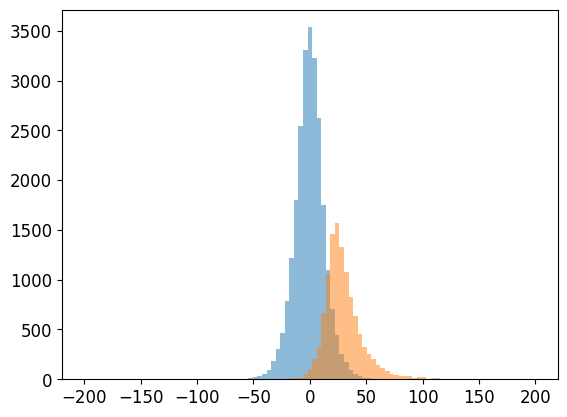

In [197]:
bins = np.linspace(-200, 200, 100)
# plt.hist(e_miss - p_miss, bins=bins)
plt.hist(e_miss_mu - p_miss_mu, bins=bins, alpha=.5)
plt.hist(e_miss_pi - p_miss_pi, bins=bins, alpha=.5)
# plt.xlim((-1, 50))
plt.show()

In [104]:
pi_p = []
mu_p = []
ka_mu_p = []
ka_pi_p = []
for i, primary_particles in enumerate(primary_pdgid):
    if primary_particles[3] == 211:
        pi_p.append(np.sqrt(x3[i][3] ** 2 + y3[i][3] ** 2 + z3[i][3] ** 2) * 1000)
        ka_pi_p.append(np.sqrt(x3[i][2] ** 2 + y3[i][3] ** 2 + z3[i][2] ** 2) * 1000)
    if primary_particles[3] == -13:
        mu_p.append(np.sqrt(x3[i][3] ** 2 + y3[i][3] ** 2 + z3[i][3] ** 2) * 1000)
        ka_mu_p.append(np.sqrt(x3[i][2] ** 2 + y3[i][3] ** 2 + z3[i][2] ** 2) * 1000)

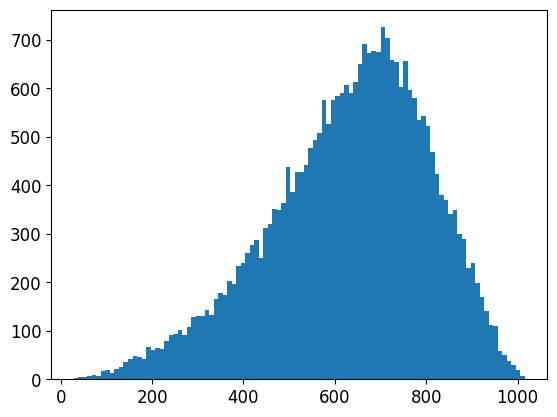

In [107]:
plt.hist(ka_mu_p, bins=100)
plt.show()

In [79]:
primary_pdgid[8]

array([321])

In [78]:
farich_pdgid[8]

array([321, 321,  11])

In [30]:
np.where(farich_pdgid[10] != -22)[0].shape

(48,)

In [10]:
shapes = np.array([np.where((farich_pdgid[i] != -22) & (farich_pdgid[i] != 11) & (primary_pdgid[i][0] in farich_pdgid[i]))[0].shape[0] for i in range(len(farich_pdgid))])

In [115]:
shapes.shape

(40000,)

In [116]:
np.unique(shapes, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 19, 20, 24, 28, 37]),
 array([ 2851, 36253,   566,   121,    62,    34,    25,    19,    12,
           12,     5,     9,     8,     3,     5,     5,     2,     3,
            1,     1,     1,     1,     1], dtype=int64))

In [117]:
np.where(shapes == 1)[0].shape

(36253,)

In [118]:
good_events = np.where(shapes == 1)[0]

In [104]:
farich_pdgid[197]

array([321, -13, -13, -13, -13, -11, -11,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  11,  11,  11])

In [132]:
primary_particle_idx = np.array([np.where(farich_pdgid[good_events[i]] == primary_pdgid[good_events[i]])[0][0] for  i in range(len(good_events))])

In [133]:
primary_particle_idx[0]

272

In [11]:
def init_coords_for_field(file, grid):
    primary_pdgid = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.pdgId'].array())
    farich_pdgid = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array()) 
    shapes = np.array([np.where((farich_pdgid[i] != -22) & (farich_pdgid[i] != 11) & (primary_pdgid[i][0] in farich_pdgid[i]))[0].shape[0] for i in range(len(farich_pdgid))])
    good_events = np.where(shapes == 1)[0]
    primary_particle_idx = np.array([np.where(farich_pdgid[good_events[i]] == primary_pdgid[good_events[i]])[0][0] for  i in range(len(good_events))])
    
    x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.x"].array())[good_events]
    y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.y"].array())[good_events]
    z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.z"].array())[good_events]
    wvs = (1239.841 / np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.energy"].array()) * 1e-9)[good_events]
    t = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.localTime"].array())[good_events]
    
    farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[good_events]
    farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[good_events]
    farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[good_events]
    farich_pdgid =      np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array())[good_events]
    
    
    x3 = np.array([farich_momentum_x[i][primary_particle_idx[i]] for i in range(farich_momentum_x.shape[0])])
    y3 = np.array([farich_momentum_y[i][primary_particle_idx[i]] for i in range(farich_momentum_y.shape[0])])
    z3 = np.array([farich_momentum_z[i][primary_particle_idx[i]] for i in range(farich_momentum_z.shape[0])])
    id = np.array([farich_pdgid[i][primary_particle_idx[i]] for i in range(farich_pdgid.shape[0])])
  
    xi = np.array([x[i][primary_particle_idx[i]] for i in range(x.shape[0])])
    yi = np.array([y[i][primary_particle_idx[i]] for i in range(y.shape[0])])
    zi = np.array([z[i][primary_particle_idx[i]] for i in range(z.shape[0])])
    
    x3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())[good_events]
    y3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())[good_events]
    z3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())[good_events]
    x3 = np.array([x3[i][0] for i in range(len(good_events))])
    y3 = np.array([y3[i][0] for i in range(len(good_events))])
    z3 = np.array([z3[i][0] for i in range(len(good_events))])
    
    
    true_direction_coordinates = np.column_stack((x3, y3, z3))
    intersections = np.stack((xi, yi, zi), axis=1)
    for i in range(len(wvs)):
        wvs[i] = lin_move_to_grid(wvs[i], grid[2])
    coordinates = np.column_stack((x, y, z, wvs, t))
    return coordinates, true_direction_coordinates, intersections, id

In [12]:
def init_coords_decay(file, grid):
    x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.x"].array())[good_events]
    y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.y"].array())[good_events]
    z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.z"].array())[good_events]
    wvs = (1239.841 / np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.energy"].array()) * 1e-9)[good_events]
    t = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.localTime"].array())[good_events]
    
    farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[good_events]
    farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[good_events]
    farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[good_events]
    farich_pdgid =      np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array())[good_events]
        
    x3 = np.array([farich_momentum_x[i][primary_particle_idx[i]] for i in range(farich_momentum_x.shape[0])])
    y3 = np.array([farich_momentum_y[i][primary_particle_idx[i]] for i in range(farich_momentum_y.shape[0])])
    z3 = np.array([farich_momentum_z[i][primary_particle_idx[i]] for i in range(farich_momentum_z.shape[0])])
    id = np.array([farich_pdgid[i][primary_particle_idx[i]] for i in range(farich_pdgid.shape[0])])
  
    xi = np.array([x[i][primary_particle_idx[i]] for i in range(x.shape[0])])
    yi = np.array([y[i][primary_particle_idx[i]] for i in range(y.shape[0])])
    zi = np.array([z[i][primary_particle_idx[i]] for i in range(z.shape[0])])
    
    x3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())[good_events]
    y3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())[good_events]
    z3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())[good_events]
    x3 = np.array([x3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    y3 = np.array([y3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    z3 = np.array([z3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    # Объединяем массивы, сохраняя структуру массивов
    true_direction_coordinates = np.stack((x3, y3, z3), axis=1)
    intersections = np.stack((xi, yi, zi), axis=1)
    for i in range(len(wvs)):
        wvs[i] = lin_move_to_grid(wvs[i], grid[2])
    coordinates = np.column_stack((x, y, z, wvs, t))
    return coordinates, true_direction_coordinates, intersections, id

In [12]:
np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[3][545]

IndexError: index 545 is out of bounds for axis 0 with size 531

In [12]:
mu_px = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[3][545]
mu_py = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[3][545]
mu_pz = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[3][545]
mu_p = np.sqrt(mu_px**2 + mu_py**2 + mu_pz**2)

mu_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.postStepPosition.x'].array())[3][545]
mu_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.postStepPosition.y'].array())[3][545]
mu_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.postStepPosition.z'].array())[3][545]

IndexError: index 545 is out of bounds for axis 0 with size 531

In [47]:
mu_x

-100.06272

In [41]:
mu_pz

0.0006979369

In [100]:
pis = mus = 0
for i in range(len(primary_pdgid)):
    if primary_pdgid[i][3] != 211 and primary_pdgid[i][3] != -13:
        print('First not gamma')
    if primary_pdgid[i][3] == 211:
        pis += 1
    if primary_pdgid[i][3] == -13:
        mus += 1
print(pis, mus, pis/mus, 0.013580300000000002/0.034700000)
    # if primary_pdgid[i][6] != 22:
    #     print('Second not gamma')

ZeroDivisionError: division by zero

In [13]:
k_px = np.array([arr[2] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())])
k_py = np.array([arr[2] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())])
k_pz = np.array([arr[2] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())])
k_p = np.sqrt(k_px**2+k_py**2+k_pz**2)

pi_px = np.array([arr[3] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())])
pi_py = np.array([arr[3] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())])
pi_pz = np.array([arr[3] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())])
pi_p = np.sqrt(pi_px**2+pi_py**2+pi_pz**2)

pi0_px = np.array([arr[4] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())])
pi0_py = np.array([arr[4] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())])
pi0_pz = np.array([arr[4] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())])
pi0_p = np.sqrt(pi0_px**2+pi0_py**2+pi0_pz**2)

gamma1_px = np.array([arr[5] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())])
gamma1_py = np.array([arr[5] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())])
gamma1_pz = np.array([arr[5] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())])
gamma1_p = np.sqrt(gamma1_px**2+gamma1_py**2+gamma1_pz**2)


gamma2_px = np.array([arr[6] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())])
gamma2_py = np.array([arr[6] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())])
gamma2_pz = np.array([arr[6] for arr in np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())])
gamma2_p = np.sqrt(gamma2_px**2+gamma2_py**2+gamma2_pz**2)

In [14]:
np.sum(gamma1_p  * 1000 < 30)

3794

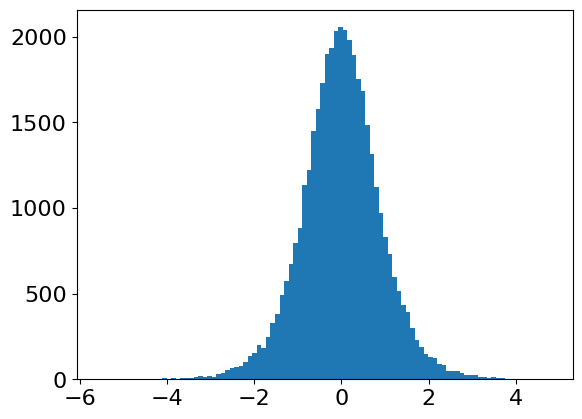

In [78]:
k_eta = - np.log(np.tan(np.arccos(k_pz/k_p)))
k_eta = 0.5 * np.log((k_p + k_pz) / (k_p - k_pz))
plt.hist(k_eta, bins=100)
plt.show()

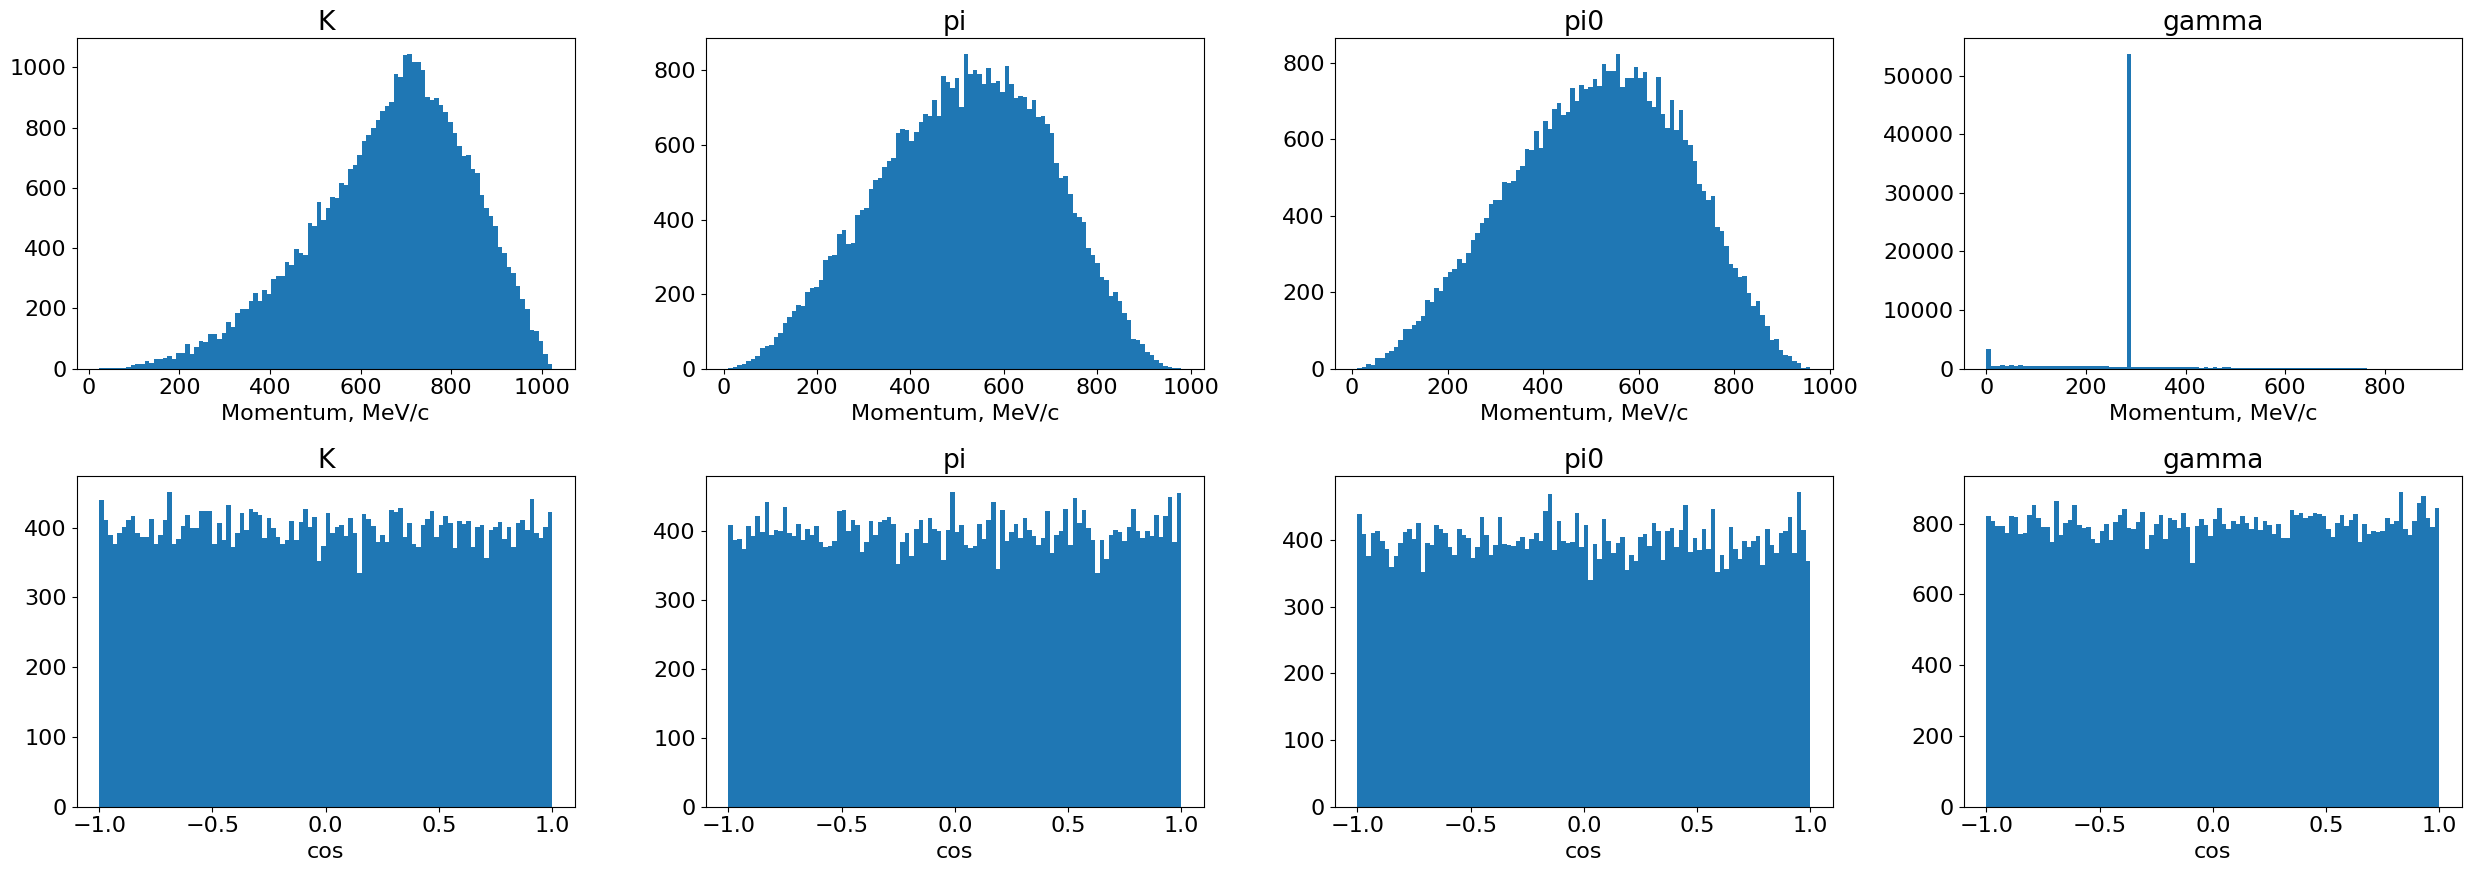

In [80]:
plt.figure(figsize=(25,9))

plt.subplot(2, 4, 1)
plt.hist(k_p * 1000, bins=100)
plt.title('K')
plt.xlabel('Momentum, MeV/c')

plt.subplot(2, 4, 2)
plt.hist(pi_p * 1000, bins=100)
plt.title('pi')
plt.xlabel('Momentum, MeV/c')

plt.subplot(2, 4, 3)
plt.hist(pi0_p * 1000, bins=100)
plt.title('pi0')
plt.xlabel('Momentum, MeV/c')

plt.subplot(2, 4, 4)
plt.hist(np.concatenate([gamma1_p, gamma2_p]) * 1000, bins=100)
plt.title('gamma')
plt.xlabel('Momentum, MeV/c')


plt.subplot(2, 4, 5)
plt.hist(k_pz / k_p, bins=100)
plt.title('K')
plt.xlabel('cos')

plt.subplot(2, 4, 6)
plt.hist(pi_pz / pi_p, bins=100)
plt.title('pi')
plt.xlabel('cos')

plt.subplot(2, 4, 7)
plt.hist(pi0_pz / pi0_p, bins=100)
plt.title('pi0')
plt.xlabel('cos')

plt.subplot(2, 4, 8)
plt.hist(np.concatenate([gamma1_pz / gamma1_p, gamma2_pz / gamma2_p]), bins=100)
plt.title('gamma')
plt.xlabel('cos')

plt.tight_layout()
plt.show()

In [13]:
1250 / np.sqrt(1250 ** 2 + 1000 ** 2)

0.7808688094430304

In [130]:
m_pi = 135.0

p_pion_lab = pi0_p * 1000  

E_pion_lab = np.sqrt(p_pion_lab**2 + m_pi**2)

beta = p_pion_lab / E_pion_lab
gamma = E_pion_lab / m_pi

cos_theta_star = np.random.uniform(-1, 1, size=len(p_pion_lab))

E_gamma_1 = 0.5 * m_pi * gamma * (1 + beta * cos_theta_star)
E_gamma_2 = 0.5 * m_pi * gamma * (1 - beta * cos_theta_star)

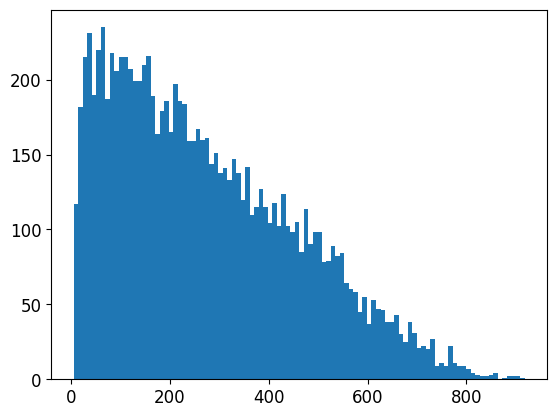

In [131]:
plt.hist(E_gamma_1, bins=100)
plt.show()

In [125]:
1280 / np.sqrt(1280 ** 2 + 210 ** 2)

0.9868074809493756

In [40]:
cos_theta_lim = 1280 / np.sqrt(1280 ** 2 + 210 ** 2)

good_gamma_ind = []
for i in range(len(gamma1_p)):
    if gamma1_p[i] < 30 / 1000:
        continue
    if gamma2_p[i] < 30 / 1000:
        continue
    if np.abs(gamma1_pz[i] / gamma1_p[i]) > cos_theta_lim:
        continue
    if np.abs(gamma2_pz[i] / gamma2_p[i]) > cos_theta_lim:
        continue
    good_gamma_ind.append(i)

In [77]:
(10000 - len(good_gamma_ind)) / 100

9.77

In [75]:
0.139000000 * (10000 - len(good_gamma_ind)) / 10000

0.013580300000000002

In [13]:
def primary_particle_match_test(primary_particles_array, ids_to_check, ids_to_match, verbose=False):
    for i in range(len(ids_to_check)):
        if primary_particles_array[ids_to_check[i]] != ids_to_match[i]:
            if verbose:
                print(f'Expected {ids_to_match[i]} but got {primary_particles_array[ids_to_check[i]]} in {ids_to_check[i]}-th position')
            return False    
    return True

In [14]:
def find_primary_in_farich(primary_particles_array, farich_particles_array, primary_id, pdg_id, verbose=False):
    find_index_of_pdg_id = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == pdg_id)).size and (idx[-1] < arr.size) else False)
    if primary_particles_array[primary_id] == pdg_id:
        if find_index_of_pdg_id(farich_particles_array) is not False:
            if primary_particles_array[primary_id] != farich_particles_array[find_index_ka(farich_pdgid[i])]:
                if verbose:
                    print('Mismatch', i)
                mismatches.append(i)
                is_good = False
        else:
            if verbose:
                print('No ka in event', i)
            is_good = False
            no_ka.append(i)
    if is_good:
        good_events.append(i)
        primary_particle_idx.append(find_index_ka(farich_pdgid[i]))
        primary_particle_in_primary_idx.append(2)

In [103]:
primary_pdgid[158]

array([    30443,       421,      -321,       211,       111,       -11,
              11,        22,      -421, 480000000])

In [102]:
farich_pdgid[158]

array([ -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,  -22,
        -22,  -22,  -22,  -22,  -22,  -22,  -22,  -

In [15]:
i = 0
empty_farich = 0
important_particle_ind = 3
mismatches = []
good_events = []
good_mu_events = []
good_ka_events = []
primary_particle_idx = []
primary_particle_in_primary_idx = []
no_mu_in_mu = []
no_pi_in_pi = []
no_ka = []
# find_index = lambda arr: (idx[-1]+1 if (idx := np.flatnonzero(arr == -22)).size and (idx[-1]+1 < arr.size) else 0) # моржовый оператор :)
find_index = lambda arr: (idx[-1] + 1 if (idx := np.flatnonzero(np.isin(arr, [-22, -11]))).size and (idx[-1] + 1 < arr.size) else 0)
find_index_mu = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == -13)).size and (idx[-1] < arr.size) else False)
find_index_pi = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == 211)).size and (idx[-1] < arr.size) else False)
find_index_ka = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == -321)).size and (idx[-1] < arr.size) else False)

# need 2 rings per event now...

for primary_particles in primary_pdgid:
    is_good = True
                
    if farich_pdgid[i].shape[0] == 0 or np.flatnonzero(farich_pdgid[i] + 22).shape[0] == 0:
        empty_farich += 1
        is_good = False
        
    if is_good:
        is_good = primary_particle_match_test(primary_particles, [0, 1, 2], [30443, 421, -321], True)

    if primary_particles[2] == -321 and is_good:
        if farich_pdgid[i].shape[0] != 0 and np.flatnonzero(farich_pdgid[i] + 22).shape[0] != 0:
            if find_index_ka(farich_pdgid[i]) is not False:
                if primary_particles[2] != farich_pdgid[i][find_index_ka(farich_pdgid[i])]:
                    print('Mismatch', i)
                    mismatches.append(i)
                    is_good = False
            else:
                # print('No ka in event', i)
                is_good = False
                no_ka.append(i)
        if is_good:
            good_events.append(i)
            primary_particle_idx.append(find_index_ka(farich_pdgid[i]))
            primary_particle_in_primary_idx.append(2)
            
            
    if primary_particles[important_particle_ind] == -13 and is_good:
        if farich_pdgid[i].shape[0] != 0 and np.flatnonzero(farich_pdgid[i] + 22).shape[0] != 0:
            if find_index_mu(farich_pdgid[i]) is not False:
                if primary_particles[important_particle_ind] != farich_pdgid[i][find_index_mu(farich_pdgid[i])]:
                    print('Mismatch', i)
                    mismatches.append(i)
                    is_good = False
            else:
                # print('No mu in mu event', i)
                is_good = False
                no_mu_in_mu.append(i)
        if is_good:
            good_events.append(i)
            primary_particle_idx.append(find_index_mu(farich_pdgid[i]))
            primary_particle_in_primary_idx.append(important_particle_ind)
        if not is_good:
            if len(good_events) != 0:
                good_events.pop()
                primary_particle_idx.pop()
                primary_particle_in_primary_idx.pop()
    
    elif primary_particles[important_particle_ind] == 211 and is_good:
        if farich_pdgid[i].shape[0] != 0 and np.flatnonzero(farich_pdgid[i] + 22).shape[0] != 0:
            if find_index_pi(farich_pdgid[i]) is not False:
                if primary_particles[important_particle_ind] != farich_pdgid[i][find_index_mu(farich_pdgid[i])]:
                    print('Mismatch', i)
                    mismatches.append(i)
                    is_good = False
            else:
                # print('No mu in mu event', i)
                is_good = False
                no_pi_in_pi.append(i)
        if is_good:
            good_events.append(i)
            primary_particle_idx.append(find_index_pi(farich_pdgid[i]))
            primary_particle_in_primary_idx.append(important_particle_ind)
        if not is_good:
            if len(good_events) != 0:
                good_events.pop()
                primary_particle_idx.pop()
                primary_particle_in_primary_idx.pop()

    # if is_good:
    #     good_events.append(i)
    #     primary_particle_idx.append(find_index(farich_pdgid[i]))
    i += 1
    

print('Empty Farich:',empty_farich)
print('Mismatches: ',len(mismatches))
print('Missing K: ',len(no_ka))
print('Missing Mu in Mu event: ',len(no_mu_in_mu))
print('Missing Pi in Pi event: ',len(no_pi_in_pi))
print('Full bad events: ', len(mismatches) + empty_farich + len(set(np.concatenate([no_mu_in_mu, no_ka, no_pi_in_pi]))))
print('Good Events:', i - len(mismatches) - empty_farich - len(set(np.concatenate([no_mu_in_mu, no_ka, no_pi_in_pi]))))
print(len(good_events))
print(len(set(good_events)))
print(- len(set(good_events)) + len(good_events))

Mismatch 158
Mismatch 307
Mismatch 754
Mismatch 1040
Mismatch 1577
Mismatch 1661
Mismatch 1804
Mismatch 1839
Mismatch 1973
Mismatch 2185
Mismatch 2392
Mismatch 3364
Mismatch 3566
Mismatch 3694
Mismatch 3823
Mismatch 4126
Mismatch 4133
Mismatch 4710
Mismatch 5422
Mismatch 5539
Mismatch 5964
Mismatch 6067
Mismatch 6210
Mismatch 6397
Mismatch 6412
Mismatch 6618
Mismatch 7668
Mismatch 8110
Mismatch 8118
Mismatch 8195
Mismatch 8489
Mismatch 8615
Mismatch 8667
Mismatch 8771
Mismatch 9093
Mismatch 9415
Mismatch 9563
Mismatch 11435
Mismatch 11962
Mismatch 12546
Mismatch 12821
Mismatch 13247
Mismatch 13382
Mismatch 14603
Mismatch 15090
Mismatch 15744
Mismatch 16410
Mismatch 16497
Mismatch 17055
Mismatch 17088
Mismatch 17677
Mismatch 17955
Mismatch 20176
Mismatch 20433
Mismatch 21268
Mismatch 21651
Mismatch 21902
Mismatch 21946
Mismatch 22431
Mismatch 22907
Mismatch 23728
Mismatch 23839
Mismatch 24552
Mismatch 24590
Mismatch 24983
Mismatch 25001
Mismatch 26006
Mismatch 27279
Mismatch 28302
Misma

In [16]:
farich_energy = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.energy'].array())[good_events]
farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[good_events]
farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[good_events]
farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[good_events]

primary_momentum_x = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())[good_events]
primary_momentum_y = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())[good_events]
primary_momentum_z = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())[good_events]

farich_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.x"].array())[good_events]
farich_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.y"].array())[good_events]
farich_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.z"].array())[good_events]
farich_t = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.localTime"].array())[good_events]

In [17]:
primary_momentum = primary_momentum_x.copy()
for i in range(len(primary_momentum_x)):
    primary_momentum[i] = np.sqrt(primary_momentum_x[i] ** 2 + primary_momentum_y[i] ** 2 + primary_momentum_z[i] ** 2)

In [18]:
farich_momentum = farich_momentum_x.copy()
for i in range(len(primary_momentum_x)):
    farich_momentum[i] = np.sqrt(farich_momentum_x[i] ** 2 + farich_momentum_y[i] ** 2 + farich_momentum_z[i] ** 2)

In [18]:
primary_pdgid[good_events[2]]

array([    30443,       421,      -321,       -13,        14,      -421,
       480000000])

In [34]:
primary_particle_idx

[1,
 0,
 235,
 234,
 357,
 356,
 356,
 355,
 1,
 0,
 304,
 303,
 1115,
 1114,
 8,
 7,
 557,
 555,
 443,
 442,
 338,
 337,
 291,
 290,
 290,
 289,
 270,
 269,
 377,
 376,
 51,
 50,
 25,
 24,
 2,
 1,
 354,
 353,
 357,
 356,
 1,
 0,
 399,
 398,
 433,
 432,
 1,
 0,
 430,
 429,
 388,
 387,
 83,
 82,
 344,
 343,
 389,
 388,
 443,
 442,
 2,
 1,
 484,
 483,
 350,
 349,
 386,
 385,
 309,
 308,
 114,
 113,
 457,
 456,
 11,
 8,
 405,
 404,
 283,
 282,
 518,
 517,
 83,
 82,
 311,
 310,
 500,
 499,
 444,
 443,
 416,
 415,
 330,
 329,
 219,
 218,
 920,
 919,
 2,
 1,
 433,
 432,
 329,
 328,
 38,
 37,
 617,
 616,
 245,
 244,
 286,
 285,
 325,
 309,
 417,
 416,
 467,
 466,
 412,
 411,
 404,
 403,
 308,
 307,
 401,
 400,
 311,
 310,
 240,
 239,
 413,
 412,
 7,
 6,
 278,
 277,
 49,
 48,
 563,
 562,
 24,
 23,
 360,
 359,
 317,
 316,
 424,
 423,
 1,
 0,
 1172,
 398,
 439,
 438,
 8,
 7,
 502,
 501,
 415,
 414,
 51,
 50,
 81,
 80,
 235,
 234,
 207,
 206,
 256,
 255,
 4,
 3,
 338,
 337,
 282,
 281,
 1,
 0,
 1

In [111]:
eta_mu = []
eta_pi = []
eta_ka_mu = []
eta_ka_pi = []
p_mu = []
p_pi = []
p_ka_mu = []
p_ka_pi = []
for i in range(len(set(good_events))):
    if primary_pdgid[good_events[i]][3] == -13:
        eta_mu.append(0.5 * np.log((primary_momentum_z[i][3] + primary_momentum[i][3]) / (primary_momentum[i][3] - primary_momentum_z[i][3])))
        eta_ka_mu.append(0.5 * np.log((primary_momentum_z[i][2] + primary_momentum[i][2]) / (primary_momentum[i][2] - primary_momentum_z[i][2])))
        p_mu.append(primary_momentum[i][3])
        p_ka_mu.append(primary_momentum[i][2])
    elif primary_pdgid[good_events[i]][3] == 211:
        eta_pi.append(0.5 * np.log((primary_momentum_z[i][3] + primary_momentum[i][3]) / (primary_momentum[i][3] - primary_momentum_z[i][3])))
        eta_ka_pi.append(0.5 * np.log((primary_momentum_z[i][2] + primary_momentum[i][2]) / (primary_momentum[i][2] - primary_momentum_z[i][2])))
        p_pi.append(primary_momentum[i][3])
        # p_pi.append(farich_momentum[i][primary_particle_idx[i]])
        p_ka_pi.append(primary_momentum[i][2])
# primary_momentum[0]

In [125]:
len(p_ka_mu), len(p_ka_pi)

(13463, 4530)

In [126]:
len(ka_mu_p), len(ka_pi_p)

(28710, 11290)

In [141]:
len(p_ka_mu) / len(ka_mu_p), len(p_ka_pi) / len(ka_pi_p)

(0.46893068617206546, 0.4012400354295837)

In [156]:
p_ka_pi_after = []
p_ka_mu_after = []
for i in range(bdf.shape[0]-1):
    if round(bdf.loc[i+1].mass) == round(pi_mass):
        p_ka_pi_after.append(bdf.loc[i].momentum)
    elif round(bdf.loc[i+1].mass) == round(mu_mass):
        p_ka_mu_after.append(bdf.loc[i].momentum)

In [218]:
theta_p = bdf.theta_p.values
momentum = bdf.momentum.values
mass = np.round(bdf.mass.values)

# Предварительная фильтрация по условиям, которые не зависят от delim
mask = (theta_p[:-1] < 0.79) & (theta_p[1:] < 0.79) & (momentum[:-1] > 310) & (momentum[1:] > 310) & (mass[:-1] == round(ka_mass)) & ((mass[1:] == round(pi_mass)) | (mass[1:] == round(mu_mass)))
mask_2 = (mass[:-1] == round(ka_mass)) & (mass[1:] == round(pi_mass))
indices = np.where(mask)[0]
# indices = np.concatenate([indices, indices + 1])
# Предварительно посчитаем маски
is_mu = mass[indices + 1] == round(mu_mass)
is_pi = mass[indices + 1] == round(pi_mass)
is_ka = mass[indices] == round(ka_mass)

In [237]:
i = np.arange(bdf.shape[0] - 1)

# Основной фильтр: theta_p и momentum для i и i+1
mask = (
    (theta_p[i] < 0.79) &
    (theta_p[i + 1] < 0.79) &
    (momentum[i] > 310) &
    (momentum[i + 1] > 310) &
    (i % 2 == 0)
)

# Применим маску
i = i[mask]
i = np.sort(np.concatenate([i, i+1]))

In [236]:
i+1

array([    3,     5,     7, ..., 35982, 35984, 35986])

In [238]:
bdf.loc[i]

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance,mu_proba,pi_proba,ka_proba,mass_reco
2,493.679993,550.682678,0.744593,0,6.0,0.081137,0.996710,20.165851,0.969591,0.224998,30.217529,2.830769,0.001805,0.026892,0.971303,493.679993
3,105.650002,439.337158,0.972282,13,10.0,0.182539,0.983386,37.348735,0.974474,0.002192,0.225402,10.095957,0.997841,0.002028,0.000131,105.650002
4,493.679993,768.594788,0.841386,0,8.0,0.477011,0.888371,23.310986,0.941275,0.099889,11.872001,6.899621,0.012265,0.023690,0.964044,493.679993
5,105.650002,520.723450,0.980032,23,10.0,0.480077,0.886959,52.244321,0.985627,0.005595,0.570897,11.647276,0.995690,0.004299,0.000011,105.650002
6,493.679993,720.657532,0.824988,0,8.0,0.416123,0.914663,25.544968,0.965084,0.140096,16.981613,5.185127,0.009370,0.011216,0.979414,493.679993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35981,105.650002,907.909058,0.993297,27,10.0,0.113499,0.993566,50.737281,0.990751,-0.002547,-0.256373,14.610653,0.983477,0.016521,0.000002,105.650002
35982,493.679993,699.972656,0.817198,0,8.0,0.197901,0.980481,22.471572,0.948366,0.131168,16.050926,5.235825,0.009638,0.015328,0.975033,493.679993
35983,105.650002,512.718689,0.979423,6,10.0,0.303903,0.954176,42.880637,0.979159,-0.000264,-0.026917,7.400539,0.848098,0.147745,0.004157,105.650002
35984,493.679993,664.276001,0.802618,0,7.0,0.649024,0.796674,25.006200,0.970087,0.167469,20.865402,6.899621,0.024003,0.022104,0.953892,493.679993


In [255]:
bdf.loc[bdf.loc[i][(bdf.loc[i, 'mass'].round() == round(mu_mass))].index-1]

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance,mu_proba,pi_proba,ka_proba,mass_reco
2,493.679993,550.682678,0.744593,0,6.0,0.081137,0.996710,20.165851,0.969591,0.224998,30.217529,2.830769,0.001805,0.026892,0.971303,493.679993
4,493.679993,768.594788,0.841386,0,8.0,0.477011,0.888371,23.310986,0.941275,0.099889,11.872001,6.899621,0.012265,0.023690,0.964044,493.679993
6,493.679993,720.657532,0.824988,0,8.0,0.416123,0.914663,25.544968,0.965084,0.140096,16.981613,5.185127,0.009370,0.011216,0.979414,493.679993
16,493.679993,593.852905,0.768983,0,7.0,0.102917,0.994709,21.075629,0.963628,0.194645,25.312000,5.160102,0.008692,0.021794,0.969514,493.679993
20,493.679993,877.090637,0.871441,0,8.0,0.701751,0.763713,20.778974,0.951925,0.080484,9.235753,5.235825,0.015720,0.019012,0.965268,493.679993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35974,493.679993,684.970764,0.811253,0,8.0,0.381484,0.928113,21.491172,0.967262,0.156010,19.230696,6.899621,0.024339,0.025320,0.950341,493.679993
35976,493.679993,525.759766,0.728997,0,6.0,0.598630,0.826108,18.578710,0.943189,0.214192,29.381680,4.371176,0.004131,0.058941,0.936929,493.679993
35980,493.679993,459.566040,0.681365,0,5.0,0.369200,0.932616,23.832890,0.968942,0.287577,42.205952,4.371176,0.013554,0.555604,0.430842,139.570007
35982,493.679993,699.972656,0.817198,0,8.0,0.197901,0.980481,22.471572,0.948366,0.131168,16.050926,5.235825,0.009638,0.015328,0.975033,493.679993


In [217]:
np.unique(mask_2[::2])

array([False,  True])

In [209]:
mask[:100]

array([False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False])

In [194]:
indices 

array([    2,     4,     6, ..., 35981, 35983, 35985], dtype=int64)

In [198]:
np.unique(mass[::2])

array([494.], dtype=float32)

In [239]:
(np.diff(bdf.loc[i].mass) == 0).sum()

0

In [224]:
bdf.loc[indices]

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance,mu_proba,pi_proba,ka_proba,mass_reco
2,493.679993,550.682678,0.744593,0,6.0,0.081137,0.996710,20.165851,0.969591,0.224998,30.217529,2.830769,0.001805,0.026892,0.971303,493.679993
3,105.650002,439.337158,0.972282,13,10.0,0.182539,0.983386,37.348735,0.974474,0.002192,0.225402,10.095957,0.997841,0.002028,0.000131,105.650002
4,493.679993,768.594788,0.841386,0,8.0,0.477011,0.888371,23.310986,0.941275,0.099889,11.872001,6.899621,0.012265,0.023690,0.964044,493.679993
5,105.650002,520.723450,0.980032,23,10.0,0.480077,0.886959,52.244321,0.985627,0.005595,0.570897,11.647276,0.995690,0.004299,0.000011,105.650002
6,493.679993,720.657532,0.824988,0,8.0,0.416123,0.914663,25.544968,0.965084,0.140096,16.981613,5.185127,0.009370,0.011216,0.979414,493.679993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35980,493.679993,459.566040,0.681365,0,5.0,0.369200,0.932616,23.832890,0.968942,0.287577,42.205952,4.371176,0.013554,0.555604,0.430842,139.570007
35981,105.650002,907.909058,0.993297,27,10.0,0.113499,0.993566,50.737281,0.990751,-0.002547,-0.256373,14.610653,0.983477,0.016521,0.000002,105.650002
35982,493.679993,699.972656,0.817198,0,8.0,0.197901,0.980481,22.471572,0.948366,0.131168,16.050926,5.235825,0.009638,0.015328,0.975033,493.679993
35983,105.650002,512.718689,0.979423,6,10.0,0.303903,0.954176,42.880637,0.979159,-0.000264,-0.026917,7.400539,0.848098,0.147745,0.004157,105.650002


In [223]:
np.unique(bdf.loc[indices].mass[::2])

array([105.65, 139.57, 493.68], dtype=float32)

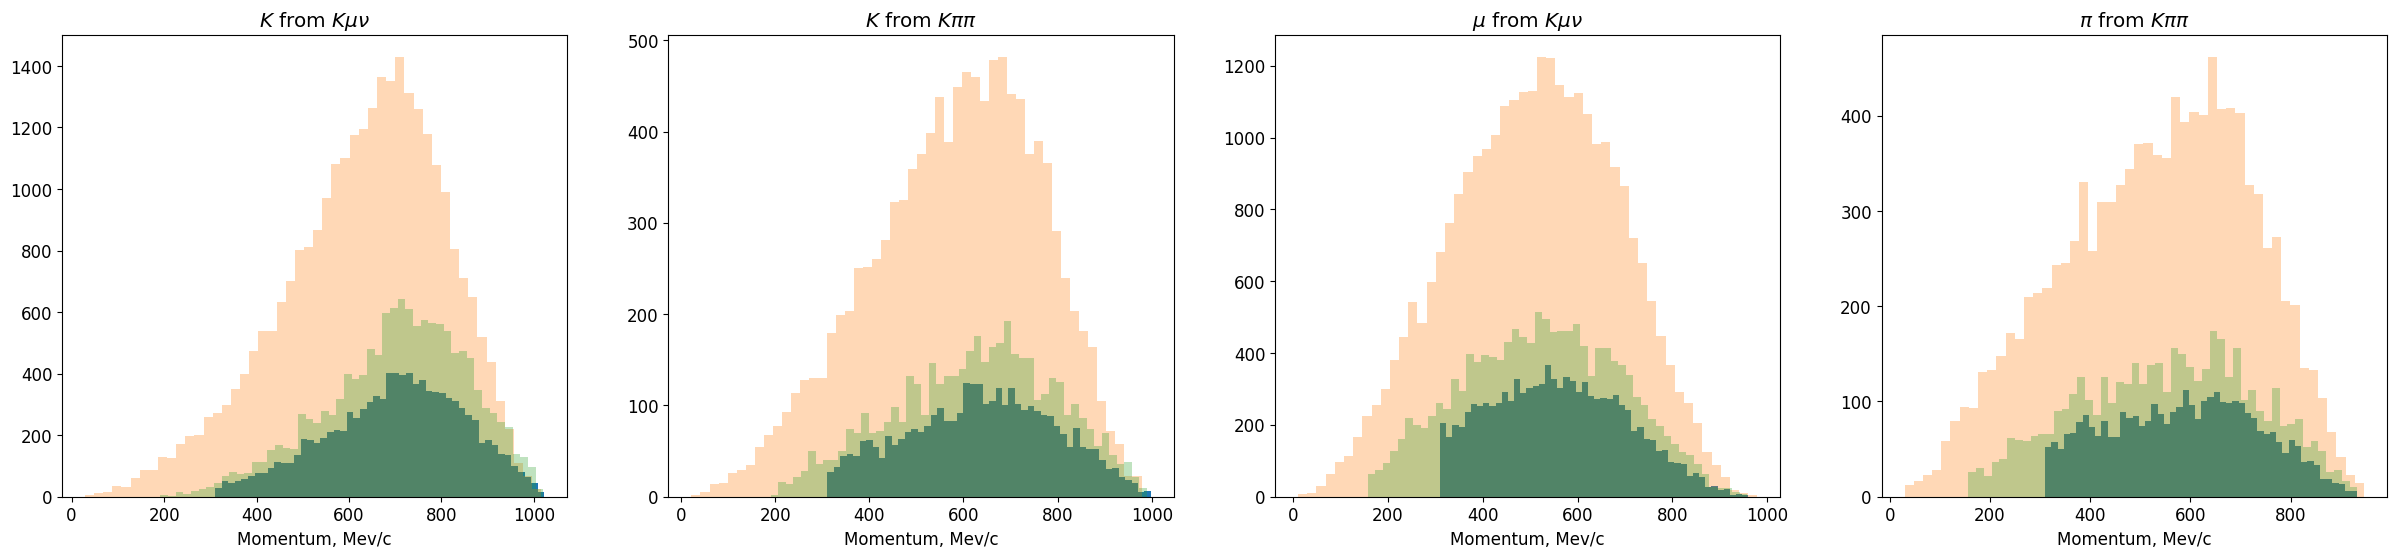

In [263]:
plt.figure(figsize=(30, 6))
plt.subplot(1, 4, 1)
plt.hist(bdf.loc[bdf.loc[i][(bdf.loc[i, 'mass'].round() == round(mu_mass))].index-1].momentum, bins=50)
plt.hist(ka_mu_p, bins=50, alpha=0.3) 
plt.hist(np.array(p_ka_mu) * 1000, bins=50, alpha=0.3)
plt.xlabel('Momentum, Mev/c')
plt.title(r'$K$ from $K\mu\nu$')

plt.subplot(1, 4, 2)
plt.hist(bdf.loc[bdf.loc[i][(bdf.loc[i, 'mass'].round() == round(pi_mass))].index-1].momentum, bins=50)
plt.hist(ka_pi_p, bins=50, alpha=0.3) 
plt.hist(np.array(p_ka_pi) * 1000, bins=50, alpha=0.3)
plt.xlabel('Momentum, Mev/c')
plt.title(r'$K$ from $K\pi\pi$')

plt.subplot(1, 4, 3)
# plt.hist(np.array(p_mu) * 1000, bins=50)
plt.hist(bdf.loc[i][(bdf.loc[i, 'mass'].round() == round(mu_mass))].momentum, bins=50, alpha=1)
plt.hist(mu_p, bins=50, alpha=0.3) 
plt.hist(np.array(p_mu) * 1000, bins=50, alpha=0.3)
plt.xlabel('Momentum, Mev/c')
plt.title(r'$\mu$ from $K\mu\nu$')

plt.subplot(1, 4, 4)
plt.hist(bdf.loc[i][(bdf.loc[i, 'mass'].round() == round(pi_mass))].momentum, bins=50, alpha=1)
plt.hist(pi_p, bins=50, alpha=0.3) 
plt.hist(np.array(p_pi) * 1000, bins=50, alpha=0.3)

plt.xlabel('Momentum, Mev/c')
plt.title(r'$\pi$ from $K\pi\pi$')
plt.show()


In [267]:
len(p_pi) / len(pi_p), len(p_mu) / len(mu_p)

(0.4012400354295837, 0.46893068617206546)

In [268]:
bdf.loc[i][(bdf.loc[i, 'mass'].round() == round(mu_mass))].shape[0] / len(p_mu), bdf.loc[i][(bdf.loc[i, 'mass'].round() == round(pi_mass))].shape[0] / len(p_pi)

(0.7463418257446335, 0.7567328918322296)

In [264]:
bdf.loc[i][(bdf.loc[i, 'mass'].round() == round(mu_mass))].shape[0] / len(mu_p), bdf.loc[i][(bdf.loc[i, 'mass'].round() == round(pi_mass))].shape[0] / len(pi_p)

(0.3499825844653431, 0.30363153232949514)

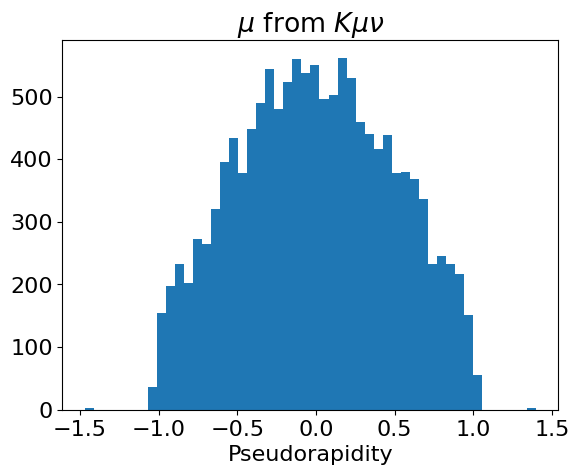

In [135]:
plt.hist(np.array(eta_mu)[np.array(eta_mu)<1.5], bins=50)
plt.xlabel('Pseudorapidity')
plt.title(r'$\mu$ from $K\mu\nu$')
plt.show()

In [19]:
np.sum([primary_pdgid[good_events[i]][3] == 211 for i in range(len(good_events))]) 

2422

In [20]:
np.sum([primary_pdgid[good_events[i]][3] == 211 for i in range(len(good_events))]) / np.sum([primary_pdgid[good_events[i]][3] == -13 for i in range(len(good_events))]) # pi / mu

0.3394058295964126

In [21]:
np.sum([primary_pdgid[good_events[i]][primary_particle_in_primary_idx[i]] == -321 for i in range(0, len(good_events), 2)]) # every even is k

4779

In [22]:
np.sum([primary_pdgid[i][2] == -321 for i in range(10000)]) 

10000

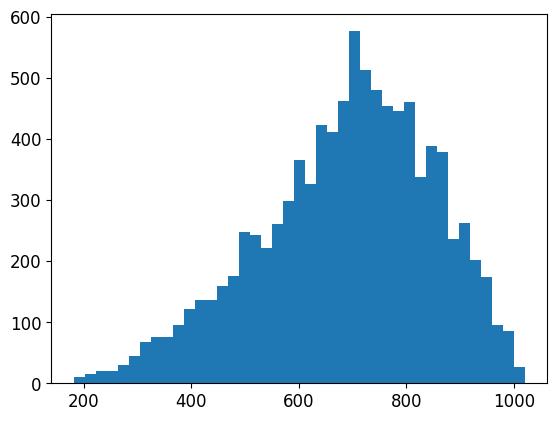

In [23]:
plt.hist([np.sqrt((primary_momentum_x[i][2]) ** 2 + (primary_momentum_y[i][2]) ** 2 + (primary_momentum_z[i][2]) ** 2) * 1000 for i in range(len(good_events))], bins='auto')
plt.show()

In [19]:
def init_coords_decay(file, grid):
    x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.x"].array())[good_events]
    y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.y"].array())[good_events]
    z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.z"].array())[good_events]
    wvs = (1239.841 / np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.energy"].array()) * 1e-9)[good_events]
    t = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.localTime"].array())[good_events]
    
    farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[good_events]
    farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[good_events]
    farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[good_events]
    farich_pdgid =      np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array())[good_events]
        
    x3 = np.array([farich_momentum_x[i][primary_particle_idx[i]] for i in range(farich_momentum_x.shape[0])])
    y3 = np.array([farich_momentum_y[i][primary_particle_idx[i]] for i in range(farich_momentum_y.shape[0])])
    z3 = np.array([farich_momentum_z[i][primary_particle_idx[i]] for i in range(farich_momentum_z.shape[0])])
    id = np.array([farich_pdgid[i][primary_particle_idx[i]] for i in range(farich_pdgid.shape[0])])
  
    xi = np.array([x[i][primary_particle_idx[i]] for i in range(x.shape[0])])
    yi = np.array([y[i][primary_particle_idx[i]] for i in range(y.shape[0])])
    zi = np.array([z[i][primary_particle_idx[i]] for i in range(z.shape[0])])
    
    x3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())[good_events]
    y3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())[good_events]
    z3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())[good_events]
    x3 = np.array([x3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    y3 = np.array([y3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    z3 = np.array([z3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    # Объединяем массивы, сохраняя структуру массивов
    true_direction_coordinates = np.stack((x3, y3, z3), axis=1)
    intersections = np.stack((xi, yi, zi), axis=1)
    for i in range(len(wvs)):
        wvs[i] = lin_move_to_grid(wvs[i], grid[2])
    coordinates = np.column_stack((x, y, z, wvs, t))
    return coordinates, true_direction_coordinates, intersections, id


In [20]:
datadir = "data"
sipm_eff, PDE_wvs = init_sipm_eff()
for key in sipm_eff.keys():
    sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

x_grid = np.arange(
    -3 * norm_r * np.sin(np.pi / 27),
    3 * norm_r * np.sin(np.pi / 27),
    SIPM_CELL_SIZE,
)
z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
grid = (x_grid, z_grid, PDE_wvs)

decay_file = uproot.open(filepath)
coordinates, true_direction_coordinates, intersections, ids = init_coords_decay(
    decay_file, grid
)


In [26]:
intersections / np.linalg.norm(intersections, axis=1)[:, None] * np.linalg.norm(true_direction_coordinates, axis=1)[:, None]

array([[-1.7381977e-01, -7.3313612e-01, -3.4249816e-02],
       [ 2.5178266e-01, -4.2465944e-02,  1.2554459e-01],
       [-3.7547314e-01, -4.8471576e-01, -5.9202647e-01],
       ...,
       [ 1.6258612e-01, -5.5150247e-01,  7.9757892e-02],
       [ 7.2456128e-04,  4.1843048e-01, -3.6699966e-01],
       [-3.2155937e-01,  2.1855320e-01,  4.8274177e-01]], dtype=float32)

In [21]:
def find_cylinder_intersections(vectors, R=1000):
    # vectors - массив размерности (N, 3)
    # R - радиус цилиндра
    
    # Вычисляем t для каждого вектора
    a_x = vectors[:, 0]
    a_y = vectors[:, 1]
    denominator = np.sqrt(a_x**2 + a_y**2)
    
    # Избегаем деления на ноль (векторы, параллельные оси z)
    mask = denominator != 0
    t = np.zeros_like(denominator)
    t[mask] = R / denominator[mask]
    
    # Вычисляем координаты пересечения
    intersections = vectors * t[:, np.newaxis]
    
    return intersections


In [21]:
intersection_diffs = np.sqrt(np.sum((find_cylinder_intersections(intersections, R=1000) - intersections) ** 2, axis=1))

In [22]:
intersection_diffs[intersection_diffs > 100].shape 

(0,)

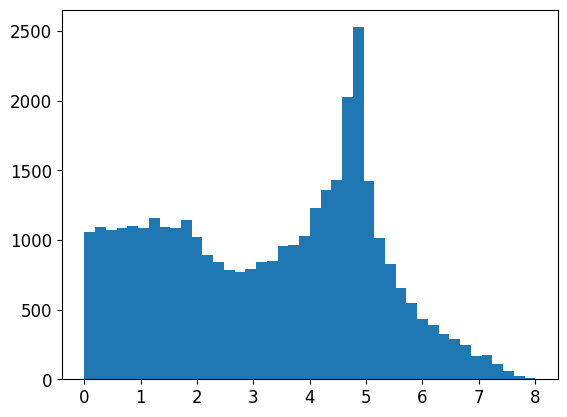

In [23]:
plt.hist(intersection_diffs[intersection_diffs < 100], bins='auto') # Короче, просто используем intersections, координаты важнее
plt.show() 

In [22]:
def find_intersections_for_decay(full_coords):
    intersections = np.zeros((full_coords.shape[0], 3))
    zeros = np.zeros((1, 3))
    for i in range(full_coords.shape[0]):
        event_coords = full_coords[i] / 1000
        pca = PCA(n_components=1)

        # if event_coords[0].shape[0] == 1:
        # print(event_coords)
        event_coords = [[0, arr] for arr in event_coords]
        # print(event_coords)
        pca.fit(np.column_stack(event_coords))
        line_direction = pca.components_[0]
        line_point = pca.mean_

        # Calculate the parameter t for the intersection with the plane y=1000
        p_y = line_point[1]
        d_y = line_direction[1]
        t = (1000 - p_y) / d_y

        # Find the intersection point
        intersection_point = line_point + t * line_direction

        # print(f"Line direction: {line_direction}")
        # print(f"Point on the line: {line_point}")
        # print(f"Intersection point with the plane y=1000: {intersection_point}")
        for j in range(3):
            intersections[i][j] = intersection_point[j]
    return intersections


In [23]:
def rotate_lines_for_decay(full_coords):
    angles = np.zeros(full_coords.shape[0])
    for i in range(full_coords.shape[0]):
        event_coords = full_coords[i]
        rotated_event_coords, angles[i] = rotate_line_for_decay(event_coords)

        for j in range(3):
            full_coords[i][j] = rotated_event_coords[:, j]
    return angles

# It only fixes angle problems, no reason not to use as main func
def rotate_line_for_decay(coords):    
    angles = np.arctan2(coords[1], coords[0]) % (2 * np.pi)
    # print(angles)
    try:
        median_angle = angles
    except IndexError:
        print(angles)
        median_angle = np.median(angles)
    median_angle = lin_move_to_grid(np.array([median_angle]), plane_angles)
    # print(angles)
    angle_to_rotate = np.pi / 2 - median_angle
    # print(angle_to_rotate)
    x, y = rotate_point_on_line(coords, angle_to_rotate)
    return np.column_stack((x, y, coords[2])), median_angle


In [24]:
def create_edf_decay(
    filepath="fullsim_optical_2000_pi_bin_1_FARICH_35mm_no_no_trackers.root",
    uncertain_angle=False,
):
    datadir = "data"
    sipm_eff, PDE_wvs = init_sipm_eff()
    for key in sipm_eff.keys():
        sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

    x_grid = np.arange(
        -3 * norm_r * np.sin(np.pi / 27),
        3 * norm_r * np.sin(np.pi / 27),
        SIPM_CELL_SIZE,
    )
    z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
    grid = (x_grid, z_grid, PDE_wvs)

    decay_file = uproot.open(os.path.join(datadir, filepath))
    coordinates, true_direction_coordinates, intersections, ids = init_coords_decay(
        decay_file, grid
    )
    
    
    idx_to_drop = []
    for i in range(coordinates.shape[0]):
        if coordinates[i][0].shape[0] == 0:
            idx_to_drop.append(i)

    coordinates = np.delete(coordinates, idx_to_drop, axis=0)
    true_direction_coordinates = np.delete(
        true_direction_coordinates, idx_to_drop, axis=0
    )
    intersections = np.delete(intersections, idx_to_drop, axis=0)
    ids = np.delete(ids, idx_to_drop)
    print(coordinates.shape)
    print(true_direction_coordinates.shape)

    true_direction_coordinates = intersections / np.linalg.norm(intersections, axis=1)[:, None] * np.linalg.norm(true_direction_coordinates, axis=1)[:, None]

    if uncertain_angle:
        uncertainty_introduction_to_direction(true_direction_coordinates)
    
    sipm_sim(coordinates, sipm_eff)
    for i, coord in enumerate(coordinates):
        # print(coord[0].shape)
        # print(coord)
        # if coord[0].shape[0] != 0:
        #     break
        if coord[0].shape[0] == 0:
            coord[0] = np.atleast_1d(np.array(intersections[i][0]))
            coord[1] = np.atleast_1d(np.array(intersections[i][1]))
            coord[2] = np.atleast_1d(np.array(intersections[i][2]))
            coord[3] = np.atleast_1d(np.array(450))
            coord[4] = np.atleast_1d(np.array(0.633))
    # idx_to_drop = []
    # for i in range(coordinates.shape[0]):
    #     if coordinates[i][0].shape[0] == 0:
    #         idx_to_drop.append(i)
    # coordinates = np.delete(coordinates, idx_to_drop, axis=0)
    # true_direction_coordinates = np.delete(
    #     true_direction_coordinates, idx_to_drop, axis=0
    # )
    # intersections = np.delete(intersections, idx_to_drop, axis=0)
    # ids = np.delete(ids, idx_to_drop)
    # print(coordinates.shape)
    # print(true_direction_coordinates.shape)

    main_angles = rotate_lines_for_decay(intersections) # Rotates intersection points
    
    intersections = find_intersections_for_decay(intersections)  # May need to rewrite both to treat elements as scalasrs and to change reference point from 0
    
    rotate_events(coordinates, main_angles)   # There are events with extra rings somewhere around angle idx 13-16
    move_events_to_grid(coordinates, grid)
    repeat_nums = np.array([coord[0].shape[0] for coord in coordinates])
    edf = pd.DataFrame(coordinates, columns=["x_c", "y_c", "z_c", "wv_c", "t_c"])

    unraveled_data = {col: [] for col in edf.columns}
    row_indices = []

    # Iterate over the DataFrame and unravel the arrays
    for i, row in edf.iterrows():
        max_length = max(len(row[col]) for col in edf.columns)
        for k in range(max_length):
            row_indices.append((i, k))
            for col in edf.columns:
                if k < len(row[col]):
                    unraveled_data[col].append(row[col][k])
                else:
                    unraveled_data[col].append(
                        np.nan
                    )  # Handle cases where arrays are of different lengths

    # Create a new DataFrame from the unraveled data
    unraveled_df = pd.DataFrame(unraveled_data)

    # Create a MultiIndex for the rows
    multi_index = pd.MultiIndex.from_tuples(row_indices, names=["entry", "subentry"])
    unraveled_df.index = multi_index

    edf = unraveled_df

    edf["x_i"] = np.repeat(intersections[:, 0], repeat_nums, axis=0)
    edf["z_i"] = np.repeat(intersections[:, 2], repeat_nums, axis=0)

    x = y = z = x3 = y3 = z3 = unraveled_data = row_indices   = wvs = coordinates = file = coordinates_low = file_low = 0 # = main_angles

    bdf = pd.DataFrame()
    gdf = pd.DataFrame()
    gdf["nhits"] = repeat_nums

    mu_mass = 105.65
    pi_mass = 139.57
    ka_mass = 493.68
    # mass = mu_mass if is_mu else (ka_mass if is_ka else pi_mass)
    mass = np.array([mu_mass if ids[i] == -13 else (ka_mass if ids[i] == -321 else pi_mass) for i in range(ids.shape[0])])
    # edf.drop("y_c", axis=1, inplace=True)
    edf.rename(columns={"y_c": "tmp_c"}, inplace=True)
    edf.drop("wv_c", axis=1, inplace=True)
    edf.rename(columns={"z_c": "y_c", "z_i": "y_i"}, inplace=True)
    edf.rename(columns={"tmp_c": "z_c"}, inplace=True)
    # edf["z_c"] = np.zeros(edf.shape[0]) + 1000  
    # edf["mass"] = np.ones(edf.shape[0]) * mass
    edf["mass"] = np.repeat(
        mass,
        repeat_nums,
        axis=0,
    )
    edf["true_p"] = np.repeat(
        np.linalg.norm(true_direction_coordinates.astype("float"), axis=1) * 1000,
        repeat_nums,
        axis=0,
    )
    edf["beta"] = edf.true_p / np.sqrt(edf.mass**2 + edf.true_p**2)
    edf["x_p"] = np.zeros(edf.shape[0])
    edf["y_p"] = np.zeros(edf.shape[0])
    edf["z_p"] = np.zeros(edf.shape[0])
    edf["nx_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 0],
        repeat_nums,
        axis=0,
    )
    edf["ny_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 2],
        repeat_nums,
        axis=0,
    )
    edf["nz_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 1],
        repeat_nums,
        axis=0,
    )

    true_direction_coordinates = repeat_nums = true_direction_coordinates_low = mass = intersections = 0
    return edf, bdf, gdf, main_angles


In [25]:
idf = pd.DataFrame()
idf['W'] = [35.]
# idf['W'] = [40.]

idf['zdis'] = [800.]
idf['distance'] = [205.]  # 200
idf['n_mean'] = [1.04511]
# 
# idf['n_mean'] = [1.0502]

idf['pixel_size'] = [3.16]
mu_mass = 105.65
pi_mass = 139.57
ka_mass = 493.68

In [36]:
mu_pi_ka = True
if mu_pi_ka:
    edf_mu, bdf_mu, gdf_mu = create_edf('fullsim_3particles_2000_mu_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=11,
                               uncertain_angle=False, is_mu=True, is_ka=False)
    edf_pi, bdf_pi, gdf_pi = create_edf('fullsim_3particles_2000_pi_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=10,
                               uncertain_angle=False, is_mu=False, is_ka=False)
    edf_ka, bdf_ka, gdf_ka = create_edf('fullsim_3particles_2000_ka_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=10,
                                    uncertain_angle=False, is_mu=False, is_ka=True)
    
    shift_ind = np.array(edf_mu.index.get_level_values(0))[-1] + 1
    new_index = edf_pi.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_pi.index = pd.MultiIndex.from_tuples(new_index, names=edf_mu.index.names)
    gdf_pi.index = np.array(gdf_pi.index) + np.array(gdf_mu.index)[-1] + 1

    shift_ind = np.array(edf_pi.index.get_level_values(0))[-1] + 1
    new_index = edf_ka.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_ka.index = pd.MultiIndex.from_tuples(new_index, names=edf_pi.index.names)
    gdf_ka.index = np.array(gdf_ka.index) + np.array(gdf_pi.index)[-1] + 1


    edf_conc = pd.concat([edf_mu, edf_pi, edf_ka])
    gdf_conc = pd.concat([gdf_mu, gdf_pi, gdf_ka])
    
    edf_mu = gdf_mu = edf_ka = gdf_ka = edf_pi = gdf_pi = 0
    edf_conc = enforce_float32(edf_conc)

(22000, 5)
(22000, 3)
(21108, 5)
(21108, 3)
(19993, 5)
(19993, 3)
(19877, 5)
(19877, 3)
(19986, 5)
(19986, 3)
(19857, 5)
(19857, 3)


In [43]:
avg_sigmas = (4, 5)
avg_t_sigmas = (4, 5)
num_of_groups = 10
what_to_group = 'beta'
r_width = float(idf.pixel_size.iloc[0]) * 2
t_width = 0.25
t_step = 0.25
r_factor = 2 # not to change
t_factor = int(t_width / t_step)
weighed = True
deg_lim = False
param_fit = False
useuse_decision_tree = True


calibration_func = pol # pol
param_calibration_func = pol2_pol2 # d3pol2
p0 = (0.9, -5, 340) # (.95, 0, 300) #(.01, 1e-3, 1e-4)
p0_c =  (1.219, -0.5588, 0.2946, 864.4, -1922, 1055, -2535, 6572, -3751)
num_of_calibration_params = 3 # 3
num_of_param_fit_params = 3 # for param fit both prev and this number are important, cal_func as well, therefore p0 and p0_C
target_variable = 'beta'
target_angle = 'theta_p'
num_of_theta_intervals = 11 # 11


# sample_size = 12
cal_arr = False
errs = False

beta_sigms = []
beta_sigms_yerr = []
beta_sigms_deglim = []
beta_sigms_yerr_deglim = []


r_bins = np.arange(16, 80, step=3.3)
r_bins = np.array([[r_bins[i], r_bins[i + 2]] for i in range(len(r_bins) - 2)])
t_bins = np.arange(0, 7, step=0.25)
t_bins = np.array([[t_bins[i], t_bins[i + 1]] for i in range(len(t_bins) - 1)])

background_means_dict = {'1e6': 0.012, '1e5': 0.0015}
background_stds_dict = {'1e6': 0.0175, '1e5': 0.0055}

background_mean = background_means_dict['1e5']
background_std = background_stds_dict['1e5']

batch_size = 10000
num_of_classes = 4

In [27]:
background_std

0.0055

In [28]:
background_mean

0.0015

In [23]:
dcr = '0'
print(dcr)
timer_start = perf_counter()
edf_d = edf_conc.copy()
gdf_d = gdf_conc.copy()
bdf_d = pd.DataFrame()
edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
edf_d = applySpaceCut(edf_d)
planeRecalculation(edf_d, idf)
planeRotation(edf_d)
edf_d = applySecondSpaceCut(edf_d)
edf_to_bdf(edf_d.mass, bdf_d)
edf_to_bdf(edf_d.true_p, bdf_d)
bdf_d.rename(columns={'true_p': 'momentum'}, inplace=True)
edf_to_bdf(edf_d.beta, bdf_d)
recoAngles(edf_d, idf)
primaryDirectionRecalculation(edf_d)

recoAngles(edf_d, idf, rotation_mode=True)

calculateSignalCounts(edf_d, bdf_d)

cal_arr, errs = rSlidingWindow(edf_d, idf, bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                           step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                           calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                           target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
    
print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))

0


NameError: name 'edf_conc' is not defined

In [29]:
for dcr in  ['1e6'] : # ['0', '1e3', '1e4', '1e5', '1e6']
    print(dcr)
    timer_start = perf_counter()

    sample_idx = np.random.permutation(gdf_conc.index.shape[0])
    
    max_iter = int(np.ceil(sample_idx.shape[0] / batch_size))
    
    
    for sample in range(max_iter):
        sample_timer = perf_counter()
        if sample == max_iter - 1:
            sample_ind = sample_idx[batch_size * sample :]
            batch_size = sample_idx.shape[0] - batch_size * sample
        else:
            sample_ind = sample_idx[batch_size * sample : batch_size * (sample + 1)]
            
        edf_d = edf_conc.loc[sample_ind]
        gdf_d = gdf_conc.loc[sample_ind]
    
        index_map = dict(zip(np.array(gdf_d.index), np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)))
        new_new_index = edf_d.index.map(lambda idx: (index_map[idx[0]], idx[1]))
        edf_d.index = pd.MultiIndex.from_tuples(new_new_index, names=edf_d.index.names)
        gdf_d.index = np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)
    
    
        bdf_d = pd.DataFrame()
        edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
        edf_d = enforce_float32(edf_d)

        sample_ind_2 = np.random.choice(gdf_d.index, size=int(np.ceil(batch_size / num_of_classes)), replace=False)
        edf_slice = edf_d.loc[(sample_ind_2)]
        edf_d.loc[sample_ind_2] = edf_slice[edf_slice.signal == False] 
    
    
        edf_d = applySpaceCut(edf_d)
        planeRecalculation(edf_d, idf)
        planeRotation(edf_d)
        edf_d = applySecondSpaceCut(edf_d)
        edf_to_bdf(edf_d.mass, bdf_d)
        edf_to_bdf(edf_d.true_p, bdf_d)
        bdf_d.rename(columns={'true_p': 'momentum'}, inplace=True)
        edf_to_bdf(edf_d.beta, bdf_d)
        recoAngles(edf_d, idf)
        primaryDirectionRecalculation(edf_d)
        
        recoAngles(edf_d, idf, rotation_mode=True)
        
        calculateSignalCounts(edf_d, bdf_d)
        edf_d = enforce_float32(edf_d)
        cal_arr, errs = rSlidingWindow(edf_d, idf, bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                                   step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                                   calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                                   target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
        edf_d = enforce_float32(edf_d)
        dists_from_mean_edf = []
        for entry, event in edf_d.groupby(level=0):
            data = np.array(event[['rotated_r_c', 't_c']])
            in_x_bins = (data[:, 0][:, None] >= r_bins[:, 0]) & (data[:, 0][:, None] < r_bins[:, 1])
            in_y_bins = (data[:, 1][:, None] >= t_bins[:, 0]) & (data[:, 1][:, None] < t_bins[:, 1])
            
            # Compute 2D histogram by combining x and y conditions
            hist = np.dot(in_x_bins.T.astype(int), in_y_bins.astype(int))  # Shape: (len(x_bins), len(y_bins))
            r_bin_centers = r_bins.mean(axis=1)
            hist = hist / r_bin_centers[:, None]
            
            max_signal = np.max(hist)
            
            dists_from_mean_edf.append((max_signal - background_mean) / background_std)
        
        bdf_d['distance'] = dists_from_mean_edf
        
        if sample == 0:
            c_bdf_d = bdf_d
        else:
            c_bdf_d = pd.concat([c_bdf_d, bdf_d], ignore_index=True)
        print(f'    Time elapsed on current sample ({sample}/{max_iter}): ', round(perf_counter() - sample_timer))
    print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))
bdf_d = c_bdf_d

1e6
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (0/56):  213
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (1/56):  196
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (2/56):  204
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (3/56):  205
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (4/56):  212
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (5/56):  194
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (6/56):  192
    Generate noise with DCR per mm^2 1000000

In [32]:
bdf_d

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance
0,NaN,653.577759,0.987185,0,10.0,0.572920,0.840322,42.261030,0.973902,-0.013283,-1.345568,19.619853
1,493.679993,2484.930176,0.980831,32,10.0,0.104736,0.994520,39.953684,0.980328,-0.000503,-0.051289,136.948542
2,105.650002,2018.161011,0.998633,46,10.0,0.375733,0.930239,58.161409,0.998436,-0.000196,-0.019667,67.638987
3,NaN,470.602173,0.975714,0,10.0,0.442587,0.903647,29.825276,0.966901,-0.008813,-0.903220,15.817377
4,105.650002,507.325806,0.978997,19,10.0,0.226330,0.974497,44.388707,0.984258,0.005261,0.537369,39.512433
...,...,...,...,...,...,...,...,...,...,...,...,...
551511,NaN,816.706238,0.991736,0,10.0,0.144804,0.989534,22.394661,0.963311,-0.028425,-2.866213,15.817377
551512,139.570007,2499.760498,0.998445,49,10.0,0.448672,0.901024,59.154112,0.997898,-0.000547,-0.054749,110.805905
551513,139.570007,378.152161,0.938141,1,9.0,0.250940,0.968679,19.634244,0.960908,0.022767,2.426815,11.662821
551514,NaN,1056.493286,0.995037,0,10.0,0.369180,0.932624,24.107408,0.963980,-0.031057,-3.121238,15.817377


In [31]:
# pd.to_pickle(bdf_d, os.path.join('data', 'pickled_bdf_1e6_600000_field.pkl'))

In [44]:
bdf_d = pd.read_pickle(os.path.join('data', 'pickled_bdf_1e5_600000_field.pkl'))

In [28]:
bdf_d.distance = (bdf_d.distance * background_stds_dict['1e5'] + background_means_dict['1e5'] - background_means_dict['1e6']) / background_stds_dict['1e6']  

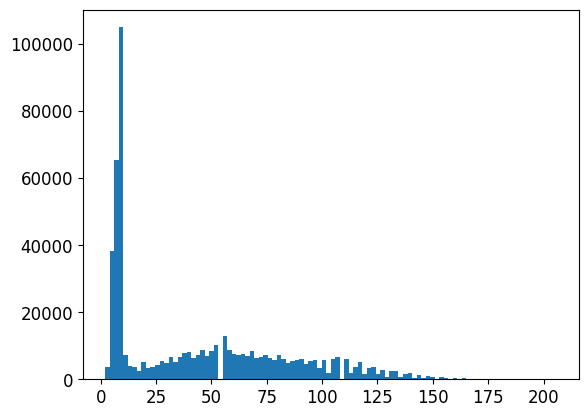

In [45]:
plt.hist(bdf_d.distance, bins=100)
plt.show()

In [28]:
bdf_d

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance
0,NaN,909.066223,0.993314,0,10.0,0.414848,0.915177,14.252245,0.958594,-0.034721,-3.495441,9.147904
1,139.570007,1214.424561,0.993461,31,10.0,0.326831,0.947064,52.896578,0.994489,0.001028,0.103501,52.049052
2,NaN,610.493835,0.985354,0,10.0,0.158850,0.987410,25.302236,0.965480,-0.019874,-2.016938,6.747280
3,105.650002,834.075989,0.992073,108,10.0,0.249376,0.969067,50.842113,0.993441,0.001368,0.137880,104.020685
4,NaN,1520.058594,0.951096,0,9.0,0.678057,0.778793,44.323170,0.973405,0.022308,2.345528,7.772325
...,...,...,...,...,...,...,...,...,...,...,...,...
551511,493.679993,981.250549,0.893312,1,8.0,0.230639,0.973520,17.402254,0.958764,0.065452,7.326849,9.147904
551512,139.570007,2036.757568,0.997660,45,10.0,0.495518,0.879723,60.053690,0.997110,-0.000550,-0.055126,84.497808
551513,139.570007,2248.061768,0.998078,59,10.0,0.410927,0.916751,58.741834,0.998325,0.000247,0.024712,134.190880
551514,139.570007,721.379700,0.981793,31,10.0,0.025215,0.999682,40.881814,0.981840,0.000047,0.004772,55.426497


In [31]:
Ы

NameError: name 'Ы' is not defined

In [67]:
bdf_d['mass'].fillna(0, inplace=True)

In [46]:
bdf_d = bdf_d.dropna()

In [30]:
bdf_d.loc[bdf_d.signal_counts <= 1, 'mass'] = 0
# bdf_d.loc[(bdf_d.mass == mu_mass) & (bdf_d.momentum < 350), 'mass'] = 0
# bdf_d.loc[(bdf_d.mass == pi_mass) & (bdf_d.momentum < 500), 'mass'] = 0
# bdf_d.loc[(bdf_d.mass == ka_mass) & (bdf_d.momentum < 1800), 'mass'] = 0

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb

In [48]:
# Assuming `bdf_d` is your pandas DataFrame
# Step 1: Extract features and target
X = bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]
y = bdf_d['mass']

# Step 2: Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # mass: [139.57 -> 0, 105.65 -> 1]
# 
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_poly = poly.fit_transform(X)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# y_train[X_train.signal_counts <= 1] = 0
# y_train[(y_train == mu_mass) & (X_train.momentum < 350)] = 0
# y_train[(y_train == pi_mass) & (X_train.momentum < 500)] = 0
# y_train[(y_train == ka_mass) & (X_train.momentum < 1800)] = 0

In [33]:
# Step 4: Initialize and train XGBoost classifier
model = xgb.XGBClassifier(
    objective='multi:softprob',  # Правильный режим для multi-class
    num_class=4,
    eval_metric='mlogloss',  # Log loss для многоклассовой задачи
    multi_class='ovr',
    use_label_encoder=False,
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=42,
    nthread=-1,
)
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Map back predictions to mass values if needed
y_pred_mass = label_encoder.inverse_transform(y_pred)

X_test['mass'] = label_encoder.inverse_transform(y_test)
X_test['mass_reco'] = y_pred_mass

Accuracy: 0.9300624589086127
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      3018
           1       0.91      0.93      0.92      3201
           2       0.91      0.87      0.89      2976
           3       0.99      0.95      0.97      2973

    accuracy                           0.93     12168
   macro avg       0.93      0.93      0.93     12168
weighted avg       0.93      0.93      0.93     12168



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [36]:
def modelfit(alg, dtrain, target, use_train_cv=True, cv_folds=5, early_stopping_rounds=50):
    
    if use_train_cv:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=target)
        cv_result = xgb.cv(
            xgb_param, xgtrain,
            num_boost_round=alg.get_params()['n_estimators'],
            nfold=cv_folds,
            metrics='auc',
            early_stopping_rounds=early_stopping_rounds,
            as_pandas=True
        )
        alg.set_params(n_estimators=cv_result.shape[0])
    
    # Обучение модели
    alg.fit(dtrain, target)
    
    # Прогнозирование на обучающем наборе
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)
    
    # Вывод отчета о модели
    print("\nModel Report")
    print(f"Estimated number of estimators: {alg.get_params()['n_estimators']}")
    print(f"Accuracy : {accuracy_score(target, dtrain_predictions):.4g}")
    print(f"AUC Score (Train): {roc_auc_score(target, dtrain_predprob, multi_class='ovr'):.6f}")
    print("Classification Report:\n", classification_report(target, dtrain_predictions))
    # Важность признаков
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()



Model Report
Estimated number of estimators: 225
Accuracy : 0.9564
AUC Score (Train): 0.997255
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.95     12266
           1       0.95      0.96      0.96     12673
           2       0.96      0.92      0.94     11949
           3       0.99      0.96      0.98     11783

    accuracy                           0.96     48671
   macro avg       0.96      0.96      0.96     48671
weighted avg       0.96      0.96      0.96     48671



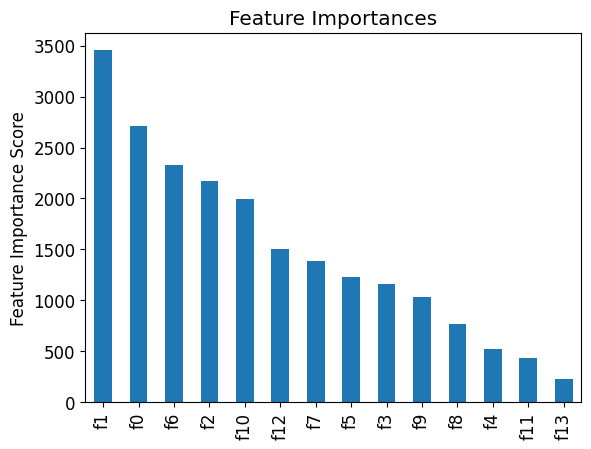

In [37]:

modelfit(model, X_train, y_train)

In [159]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(1, 10),
 'min_child_weight':range(1, 10)
}
gsearch1 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=407,  # Подобрали выше
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        seed=42,
        n_jobs=-1  
    ),
    param_grid=param_test1,
    scoring='roc_auc_ovr',  
    n_jobs=-1,
    cv=5
)

gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_, gsearch1.best_score_)


{'max_depth': 5, 'min_child_weight': 1} 0.9965279639934014


In [166]:
param_test2 = {
 'gamma': np.linspace(0.5, .7, num=11),
}
gsearch2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=407,   # Подобрали выше
        max_depth=5,        # Подобрали выше
        min_child_weight=1, # Подобрали выше
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        seed=42,
        n_jobs=-1  
    ),
    param_grid=param_test2,
    scoring='roc_auc_ovr',  
    n_jobs=-1,
    cv=5
)

gsearch2.fit(X_train, y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

{'gamma': 0.6} 0.9965919144515845


In [170]:
modelfit(xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=1000,   # Подбираем снова
        max_depth=5,         # Подобрали выше
        min_child_weight=1,  # Подобрали выше
        gamma=0.6,           # Подобрали выше
        subsample=0.8,
        colsample_bytree=0.8,
        seed=42,
        n_jobs=-1  
    ), X_train, y_train)


Model Report
Estimated number of estimators: 650
Accuracy : 0.9786
AUC Score (Train): 0.999271
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     12289
           1       0.97      0.98      0.97     12570
           2       0.97      0.96      0.97     11918
           3       1.00      0.98      0.99     11887

    accuracy                           0.98     48664
   macro avg       0.98      0.98      0.98     48664
weighted avg       0.98      0.98      0.98     48664



In [172]:
param_test3 = {
  'subsample':[i/100.0 for i in [85, 90, 95]],
  'colsample_bytree':[i/100.0 for i in [75, 80, 85]],
}
gsearch3 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=650,   # Подобрали выше
        max_depth=5,        # Подобрали выше
        min_child_weight=1, # Подобрали выше
        gamma=0.6,          # Подобрали выше
        subsample=0.8,
        colsample_bytree=0.8,
        seed=42,
        n_jobs=-1  
    ),
    param_grid=param_test3,
    scoring='roc_auc_ovr',  
    n_jobs=-1,
    cv=5
)

gsearch3.fit(X_train, y_train)
print(gsearch3.best_params_, gsearch3.best_score_)

{'colsample_bytree': 0.75, 'subsample': 0.9} 0.9966405653227426


In [174]:
param_test4 = {
  'reg_alpha':[0.5 * 1e-5, 1e-5, 0.5 * 1e-6, 1e-6, 1e-4]
}
gsearch4 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.1,
        n_estimators=650,     # Подобрали выше
        max_depth=5,          # Подобрали выше
        min_child_weight=1,   # Подобрали выше
        gamma=0.6,            # Подобрали выше
        subsample=0.9,        # Подобрали выше
        colsample_bytree=0.75, # Подобрали выше
        seed=42,
        n_jobs=-1  
    ),
    param_grid=param_test4,
    scoring='roc_auc_ovr',  
    n_jobs=-1,
    cv=5
)

gsearch4.fit(X_train, y_train)
print(gsearch4.best_params_, gsearch4.best_score_)

{'reg_alpha': 1e-05} 0.9966583745976845


In [177]:
modelfit(xgb.XGBClassifier(
        objective='multi:softprob',  # Правильный режим для multi-class
        num_class=4,
        eval_metric='mlogloss',  # Log loss для многоклассовой задачи
        use_label_encoder=False,
        learning_rate=0.01,     # Уменьшили
        n_estimators=10000,      # Подбираем снова
        max_depth=5,           # Подобрали выше
        min_child_weight=1,    # Подобрали выше
        gamma=0.6,             # Подобрали выше
        subsample=0.9,         # Подобрали выше
        colsample_bytree=0.75, # Подобрали выше
        reg_alpha=1e-5,        # Подобрали выше
        seed=42,
        n_jobs=-1  
    ), X_train, y_train)


Model Report
Estimated number of estimators: 6884
Accuracy : 0.9773
AUC Score (Train): 0.999131
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     12289
           1       0.97      0.98      0.97     12570
           2       0.97      0.96      0.97     11918
           3       1.00      0.98      0.99     11887

    accuracy                           0.98     48664
   macro avg       0.98      0.98      0.98     48664
weighted avg       0.98      0.98      0.98     48664



In [49]:
model = xgb.XGBClassifier(
    objective='multi:softprob',  # Правильный режим для multi-class
    num_class=3,
    eval_metric='mlogloss',  # Log loss для многоклассовой задачи
    use_label_encoder=False,
    learning_rate=0.1,     
    n_estimators=600,      # Подбираем снова
    max_depth=5,           # Подобрали выше
    min_child_weight=1,    # Подобрали выше
    gamma=0.6,             # Подобрали выше
    subsample=0.9,         # Подобрали выше
    colsample_bytree=0.75, # Подобрали выше
    reg_alpha=1e-5,        # Подобрали выше
    seed=42,
    n_jobs=-1  
)
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Map back predictions to mass values if needed
y_pred_mass = label_encoder.inverse_transform(y_pred)

X_test['mass'] = label_encoder.inverse_transform(y_test)
X_test['mass_reco'] = y_pred_mass

Accuracy: 0.8592566602947226
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83     29494
           1       0.79      0.80      0.80     28058
           2       0.98      0.95      0.97     25102

    accuracy                           0.86     82654
   macro avg       0.87      0.86      0.86     82654
weighted avg       0.86      0.86      0.86     82654



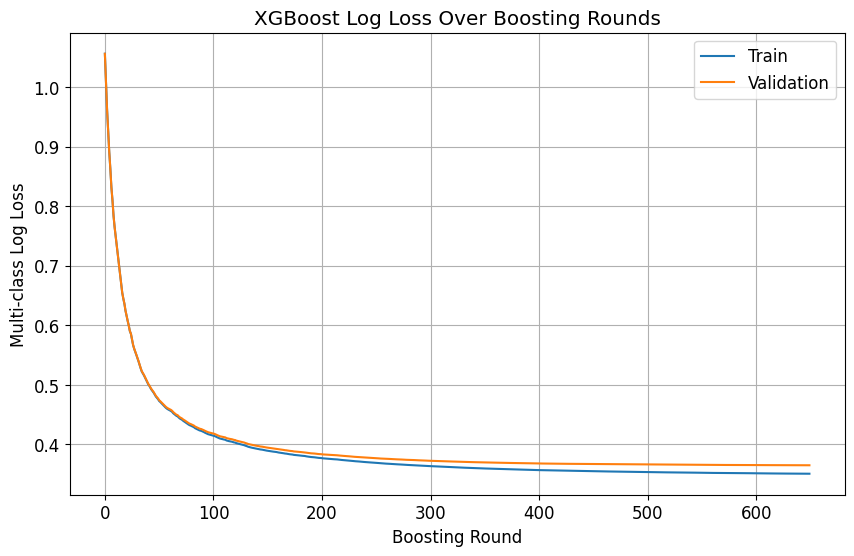

In [30]:
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']],
    y_train,
    test_size=0.2,
    random_state=42
)

# Объявляем модель
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    learning_rate=0.1,
    n_estimators=650,
    max_depth=5,
    min_child_weight=1,
    gamma=0.6,
    subsample=0.9,
    colsample_bytree=0.75,
    reg_alpha=1e-5,
    seed=42,
    n_jobs=-1
)

# Обучаем с валидацией
model.fit(
    X_train_fit, y_train_fit,
    eval_set=[(X_train_fit, y_train_fit), (X_val, y_val)],
    verbose=False  # Можно True, если хочешь видеть лог
)

# Строим график logloss
results = model.evals_result()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('Multi-class Log Loss')
plt.title('XGBoost Log Loss Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

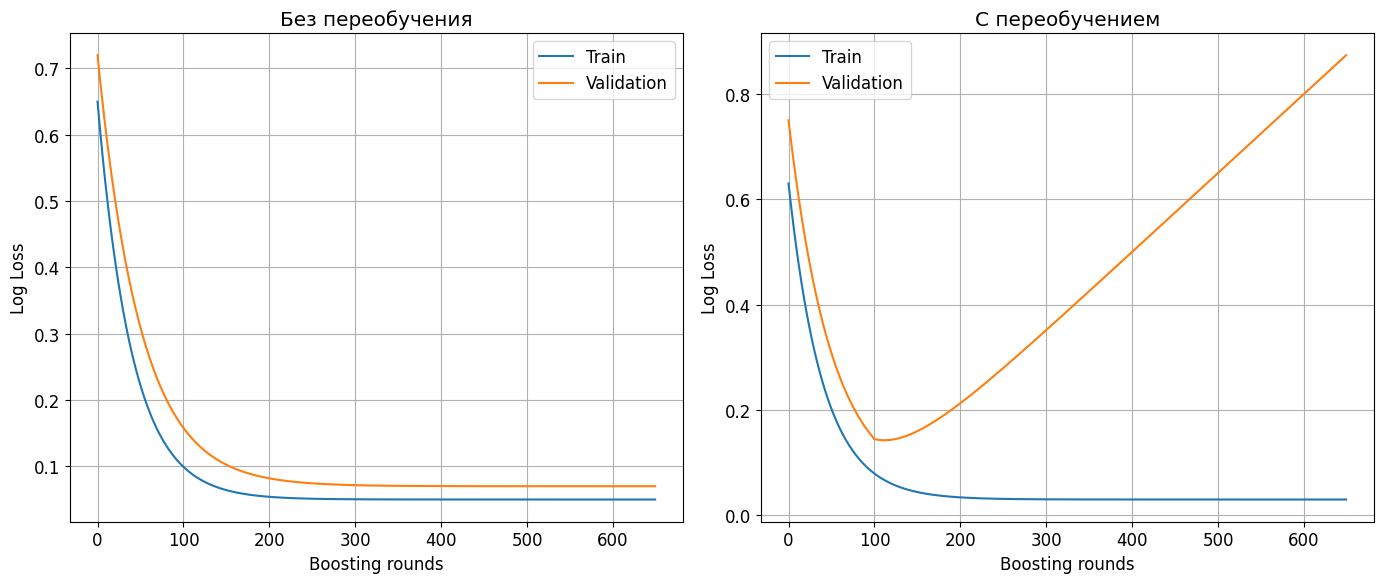

In [94]:
# Количество итераций бустинга
rounds = 650
x = np.arange(rounds)

# Без переобучения
train_loss_no_overfit = 0.6 * np.exp(-x / 40) + 0.05
val_loss_no_overfit = 0.65 * np.exp(-x / 50) + 0.07

# С переобучением
train_loss_overfit = 0.6 * np.exp(-x / 40) + 0.03
val_loss_overfit = 0.7 * np.exp(-x / 50) + 0.05 + 0.0015 * (x - 100).clip(min=0)

plt.figure(figsize=(14, 6))

# Без переобучения
plt.subplot(1, 2, 1)
plt.plot(x, train_loss_no_overfit, label='Train')
plt.plot(x, val_loss_no_overfit, label='Validation')
plt.title('Без переобучения')
plt.xlabel('Boosting rounds')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)

# С переобучением
plt.subplot(1, 2, 2)
plt.plot(x, train_loss_overfit, label='Train')
plt.plot(x, val_loss_overfit, label='Validation')
plt.title('С переобучением')
plt.xlabel('Boosting rounds')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

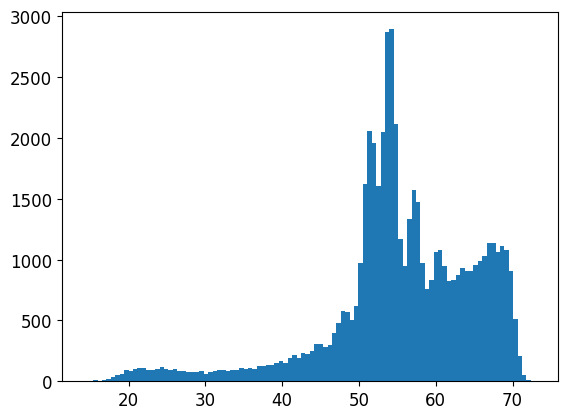

In [46]:
plt.hist(X_test[(X_test.mass != 0) & (X_test.mass < 400)].unfixed_calculated_r_2d_4_rsigms_4_tsigms, bins='auto')
plt.show()

In [94]:
X_test

,momentum,unfixed_calculated_r_2d_4_rsigms_4_tsigms,theta_p,distance,mass,mass_reco
329479,2184.710205,56.800350,0.377420,120.116222,139.570007,139.570007
243517,720.199341,51.452892,0.736068,31.015296,139.570007,139.570007
21955,968.594360,55.669563,0.477105,89.247260,139.570007,139.570007
280942,473.391266,14.252245,0.726676,10.916084,139.570007,139.570007
507537,1164.755737,51.064999,0.117354,81.480052,105.650002,105.650002
...,...,...,...,...,...,...
273173,1543.364990,18.998470,0.245941,9.147904,493.679993,493.679993
45654,872.068665,30.027940,0.403883,5.953923,493.679993,493.679993
455572,1414.661865,52.745484,0.123358,35.698496,105.650002,105.650002
184630,2113.312744,69.139214,0.734731,12.940803,139.570007,139.570007


In [31]:
label_encoder.transform([mu_mass, pi_mass, ka_mass])

array([0, 1, 2], dtype=int64)

In [52]:
intervals = np.arange(300, 2200, 300)
intervals[-1] = 2500

In [53]:
intervals

array([ 300,  600,  900, 1200, 1500, 1800, 2500])

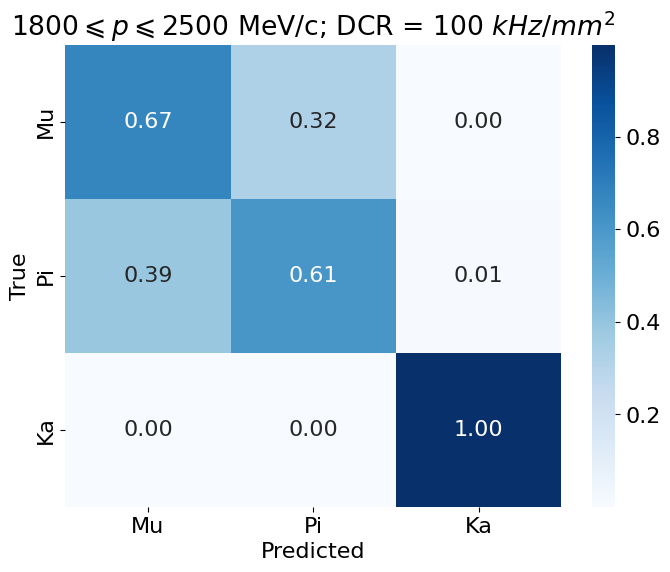

In [128]:
chosen_interval = 5
X_to_plot = X_test[(X_test.momentum > intervals[chosen_interval]) & (X_test.momentum < intervals[chosen_interval + 1])]
cm = confusion_matrix(label_encoder.transform(X_to_plot.mass), model.predict(X_to_plot[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Mu', 'Pi', 'Ka']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.title(r'$\leq$')
plt.title(f'{intervals[chosen_interval]}$\leqslant p\leqslant${ intervals[chosen_interval + 1]} MeV/c; DCR = 100 $kHz$/$mm^2$')
plt.show()

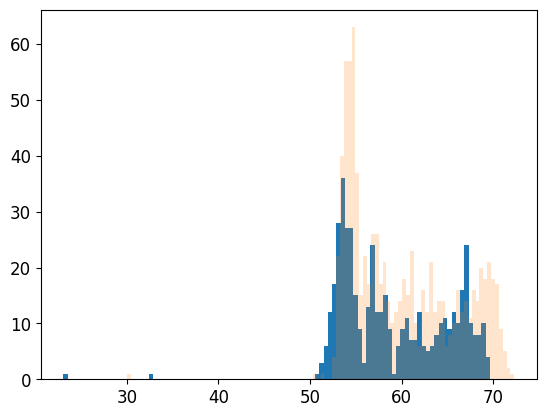

In [35]:
plt.hist(X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == pi_mass)].unfixed_calculated_r_2d_4_rsigms_4_tsigms, bins=100)
# plt.hist(X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == mu_mass)].unfixed_calculated_r_2d_4_rsigms_4_tsigms, bins=100, alpha=0.2)
plt.hist(X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == mu_mass)].unfixed_calculated_r_2d_4_rsigms_4_tsigms, bins=100, alpha=0.2)
plt.show()

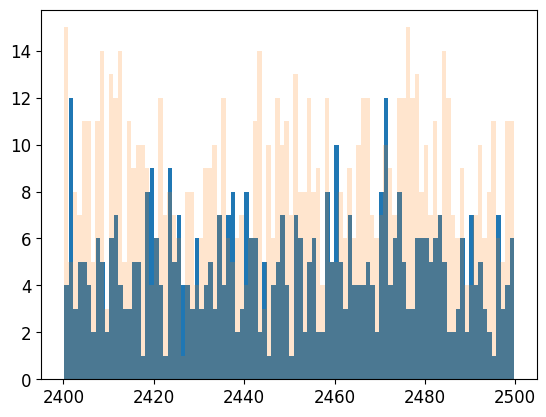

In [47]:
plt.hist(X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == pi_mass)].momentum, bins=100)
# plt.hist(X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == mu_mass)].unfixed_calculated_r_2d_4_rsigms_4_tsigms, bins=100, alpha=0.2)
plt.hist(X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == mu_mass)].momentum, bins=100, alpha=0.2)
plt.show()

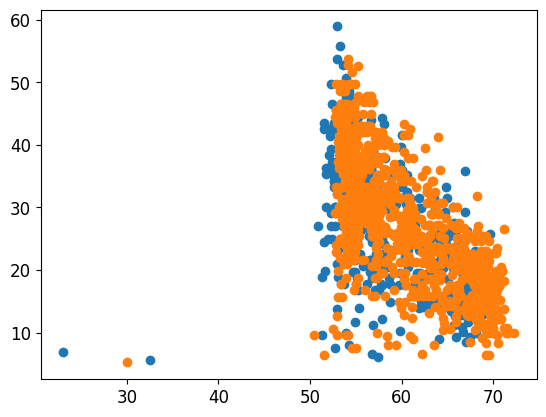

In [46]:
plt.scatter(X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == pi_mass)].unfixed_calculated_r_2d_4_rsigms_4_tsigms, X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == pi_mass)].distance)
plt.scatter(X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == mu_mass)].unfixed_calculated_r_2d_4_rsigms_4_tsigms, X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == mu_mass)].distance)
plt.show()

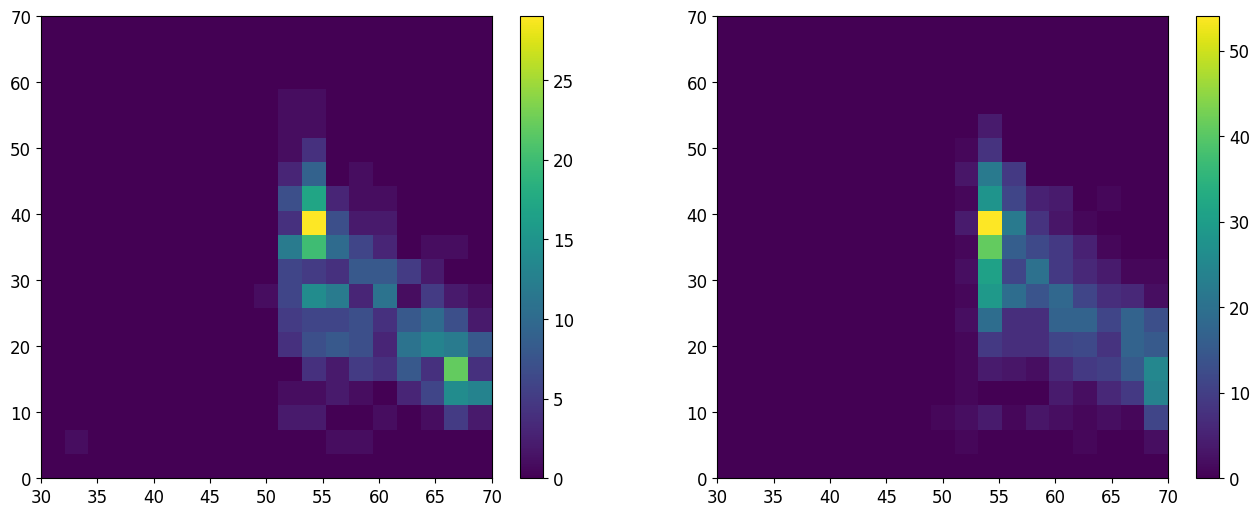

In [45]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.hist2d(X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == pi_mass)].unfixed_calculated_r_2d_4_rsigms_4_tsigms, X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == pi_mass)].distance, bins=(np.linspace(30, 70, 20), np.linspace(0, 70, 20)))
plt.xlim((30, 70))
plt.ylim((0, 70))
plt.colorbar()
plt.subplot(1, 2, 2)
plt.hist2d(X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == mu_mass)].unfixed_calculated_r_2d_4_rsigms_4_tsigms, X_to_plot[(X_to_plot.mass == mu_mass) & (X_to_plot.mass_reco == mu_mass)].distance, bins=(np.linspace(30, 70, 20), np.linspace(0, 70, 20)))
plt.colorbar()
plt.show()

In [98]:
X_to_plot

,momentum,unfixed_calculated_r_2d_4_rsigms_4_tsigms,theta_p,distance,mass,mass_reco
21955,968.594360,55.669563,0.477105,89.247260,139.570007,139.570007
507537,1164.755737,51.064999,0.117354,81.480052,105.650002,105.650002
276097,1170.624756,49.971756,0.242639,93.591344,139.570007,139.570007
183037,1187.801758,51.761614,0.087681,74.939830,105.650002,105.650002
418469,986.373047,17.402254,0.489182,9.147904,493.679993,493.679993
...,...,...,...,...,...,...
350037,1101.923340,60.818996,0.574943,91.330326,139.570007,139.570007
375920,1035.714478,36.367864,0.302756,5.321678,493.679993,493.679993
189884,1049.727173,17.465194,0.707206,15.817377,493.679993,493.679993
156287,1177.456543,17.402254,0.691517,9.147904,493.679993,493.679993


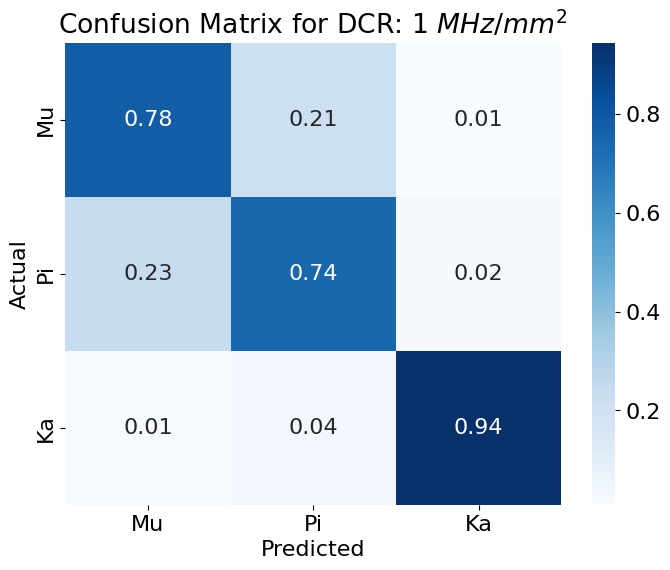

In [60]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Mu', 'Pi', 'Ka']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for DCR: 1 $MHz$/$mm^2$')
plt.show()

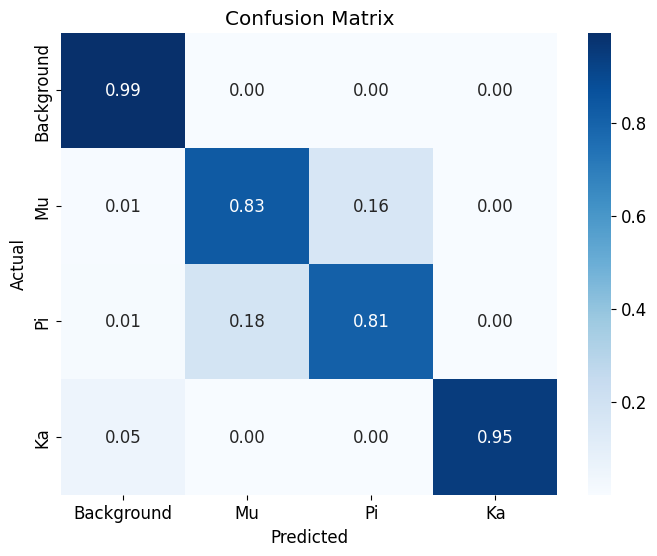

In [74]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'Mu', 'Pi', 'Ka']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [112]:
X_test[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(X_test[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d['mass_reco'] = label_encoder.inverse_transform(model.predict(X))

In [50]:
X_test[['mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(X_test[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d[['mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d['mass_reco'] = label_encoder.inverse_transform(model.predict(X))

In [51]:
edf, bdf, gdf, main_angles_tmp = create_edf_decay('decay_test_KMuKPi_40000_field.root')

(35986, 5)
(35986, 3)


In [48]:
edf

x_c     z_c      y_c       t_c         x_i  \
entry subentry                                                      
0     0        -115.519869  1000.0   -45.92  0.633000 -116.801336   
1     0         109.600131  1000.0   491.68  0.633000  109.342627   
2     0         348.160131  1000.0   495.04  0.633422   77.452963   
      1         348.160131  1000.0   478.24  0.593553   77.452963   
      2         348.160131  1000.0   501.76  0.602097   77.452963   
...                    ...     ...      ...       ...         ...   
9557  18        -21.439869  1000.0  1167.04  0.681934  -43.032831   
      19        -58.399869  1000.0  1167.04  0.690542  -43.032831   
      20        -81.919869  1000.0  1180.48  0.748977  -43.032831   
      21          2.080131  1000.0  1187.20  0.768810  -43.032831   
      22        -38.239869  1000.0  1160.32  0.711594  -43.032831   

                        y_i    mass      true_p      beta  x_p  y_p  z_p  \
entry subentry                                                             
0     0          -45.765738  493.68  754.237978  0.836703  0.0  0.0  0.0   
1     0          494.609080  139.57  284.533490  0.897805  0.0  0.0  0.0   
2     0         -968.471110  493.68  852.305574  0.865321  0.0  0.0  0.0   
      1         -968.471110  493.68  852.305574  0.865321  0.0  0.0  0.0   
      2         -968.471110  493.68  852.305574  0.865321  0.0  0.0  0.0   
...                     ...     ...         ...       ...  ...  ...  ...   
9557  18        1242.766813  105.65  619.843165  0.985783  0.0  0.0  0.0   
      19        1242.766813  105.65  619.843165  0.985783  0.0  0.0  0.0   
      20        1242.766813  105.65  619.843165  0.985783  0.0  0.0  0.0   
      21        1242.766813  105.65  619.843165  0.985783  0.0  0.0  0.0   
      22        1242.766813  105.65  619.843165  0.985783  0.0  0.0  0.0   

                    nx_p      ny_p      nz_p  
entry subentry                                
0     0        -0.115893 -0.045410  0.992223  
1     0         0.097542  0.441230  0.892077  
2     0         0.055552 -0.694618  0.717231  
      1         0.055552 -0.694618  0.717231  
      2         0.055552 -0.694618  0.717231  
...                  ...       ...       ...  
9557  18       -0.026968  0.778813  0.626676  
      19       -0.026968  0.778813  0.626676  
      20       -0.026968  0.778813  0.626676  
      21       -0.026968  0.778813  0.626676  
      22       -0.026968  0.778813  0.626676  

[184379 rows x 15 columns]

In [49]:
np.random.permutation(gdf.index.shape[0]).shape[0]

9558

In [52]:
batch_size=10000

In [53]:
for dcr in  ['1e5'] : # ['0', '1e3', '1e4', '1e5', '1e6']
    print(dcr)
    timer_start = perf_counter()

    sample_idx = np.array(sorted(np.random.permutation(gdf.index.shape[0])))
    
    max_iter = int(np.ceil(sample_idx.shape[0] / batch_size))
    print(max_iter)
    
    for sample in range(max_iter):
        sample_timer = perf_counter()
        if sample == max_iter - 1:
            sample_ind = sample_idx[batch_size * sample :]
            batch_size = sample_idx.shape[0] - batch_size * sample
        else:
            sample_ind = sample_idx[batch_size * sample : batch_size * (sample + 1)]
            
        edf_d = edf.loc[sample_ind]
        gdf_d = gdf.loc[sample_ind]
    
        index_map = dict(zip(np.array(gdf_d.index), np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)))
        new_new_index = edf_d.index.map(lambda idx: (index_map[idx[0]], idx[1]))
        edf_d.index = pd.MultiIndex.from_tuples(new_new_index, names=edf_d.index.names)
        gdf_d.index = np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)
    
    
        bdf = pd.DataFrame()
        edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
        edf_d = enforce_float32(edf_d)

        # sample_ind_2 = np.random.choice(gdf_d.index, size=int(np.ceil(batch_size / num_of_classes)), replace=False)
        # edf_slice = edf_d.loc[(sample_ind_2)]
        # edf_d.loc[sample_ind_2] = edf_slice[edf_slice.signal == False] 
        # 
        edf_to_bdf(edf_d.mass, bdf)
        edf_d = applySpaceCut(edf_d)
        planeRecalculation(edf_d, idf)
        planeRotation(edf_d)
        edf_d = applySecondSpaceCut(edf_d)
        
        print(np.unique(bdf.mass, return_counts=True))
        edf_to_bdf(edf_d.true_p, bdf)
        bdf.rename(columns={'true_p': 'momentum'}, inplace=True)
        edf_to_bdf(edf_d.beta, bdf)
        recoAngles(edf_d, idf, for_decay=True)
        primaryDirectionRecalculation(edf_d)
        
        recoAngles(edf_d, idf, rotation_mode=True, for_decay=True)
        
        calculateSignalCounts(edf_d, bdf)
        edf_d = enforce_float32(edf_d)
        cal_arr, errs = rSlidingWindow(edf_d, idf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                                   step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                                   calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                                   target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
        edf_d = enforce_float32(edf_d)
        dists_from_mean_edf = []
        for entry, event in edf_d.groupby(level=0):
            data = np.array(event[['rotated_r_c', 't_c']])
            in_x_bins = (data[:, 0][:, None] >= r_bins[:, 0]) & (data[:, 0][:, None] < r_bins[:, 1])
            in_y_bins = (data[:, 1][:, None] >= t_bins[:, 0]) & (data[:, 1][:, None] < t_bins[:, 1])
            
            # Compute 2D histogram by combining x and y conditions
            hist = np.dot(in_x_bins.T.astype(int), in_y_bins.astype(int))  # Shape: (len(x_bins), len(y_bins))
            r_bin_centers = r_bins.mean(axis=1)
            hist = hist / r_bin_centers[:, None]
            
            max_signal = np.max(hist)
            
            dists_from_mean_edf.append((max_signal - background_mean) / background_std)
        
        bdf['distance'] = dists_from_mean_edf
        
        if sample == 0:
            c_bdf_d = bdf
        else:
            c_bdf_d = pd.concat([c_bdf_d, bdf], ignore_index=True)
        print('    Time elapsed on current sample: ', round(perf_counter() - sample_timer))
    print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))
bdf = c_bdf_d

1e5
4
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
(array([105.65, 139.57, 493.68], dtype=float32), array([3783, 1217, 5000], dtype=int64))
    Time elapsed on current sample:  45
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
(array([105.65, 139.57, 493.68], dtype=float32), array([3685, 1315, 5000], dtype=int64))
    Time elapsed on current sample:  33
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
(array([105.65, 139.57, 493.68], dtype=float32), array([3720, 1280, 5000], dtype=int64))
    Time elapsed on current sample:  31
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
(array([105.65, 139.57, 493.68], dtype=float32), array([2205,  788, 2993], dtype=int64))
    Time elapsed on current sample:  19
Time elapsed on current DCR:  128


In [57]:
# pd.to_pickle(bdf, os.path.join('data', 'pickled_bdf_1e5_decay_field.pkl'))

In [107]:
bdf = pd.read_pickle(os.path.join('data', 'pickled_bdf_1e5_decay_field.pkl'))

In [41]:
# bdf = bdf[bdf.beta>0.98]

In [120]:
bdf['mass'].fillna(0, inplace=True)
bdf[bdf.mass > 490].mass = ka_mass
bdf.loc[bdf.signal_counts <= 1, 'mass'] = 0

In [68]:
bdf = bdf[~bdf.mass.isna()]

In [63]:
np.unique(bdf.mass, return_counts=True)

(array([105.65, 139.57, 493.68], dtype=float32),
 array([13393,  4600, 17993], dtype=int64))

In [64]:
bdf

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance
0,493.679993,754.237976,0.836703,1,8.0,0.095826,0.995412,26.816278,0.959510,0.122807,14.677471,4.371176
1,139.570007,284.533508,0.897805,1,9.0,0.486501,0.883974,51.981463,0.985627,0.087822,9.781866,5.480781
2,493.679993,550.682678,0.744593,0,6.0,0.081137,0.996710,20.165851,0.969591,0.224998,30.217529,2.830769
3,105.650002,439.337158,0.972282,13,10.0,0.182539,0.983386,37.348735,0.974474,0.002192,0.225402,10.095957
4,493.679993,768.594788,0.841386,0,8.0,0.477011,0.888371,23.310986,0.941275,0.099889,11.872001,6.899621
...,...,...,...,...,...,...,...,...,...,...,...,...
35981,105.650002,907.909058,0.993297,27,10.0,0.113499,0.993566,50.737281,0.990751,-0.002547,-0.256373,14.610653
35982,493.679993,699.972656,0.817198,0,8.0,0.197901,0.980481,22.471572,0.948366,0.131168,16.050926,5.235825
35983,105.650002,512.718689,0.979423,6,10.0,0.303903,0.954176,42.880637,0.979159,-0.000264,-0.026917,7.400539
35984,493.679993,664.276001,0.802618,0,7.0,0.649024,0.796674,25.006200,0.970087,0.167469,20.865402,6.899621


In [99]:
bdf.loc[(round(bdf.mass) == round(pi_mass)) & (bdf.theta_p < 0.79)].shape[0] / bdf.loc[(round(bdf.mass) == round(pi_mass))].shape[0]

0.9080434782608696

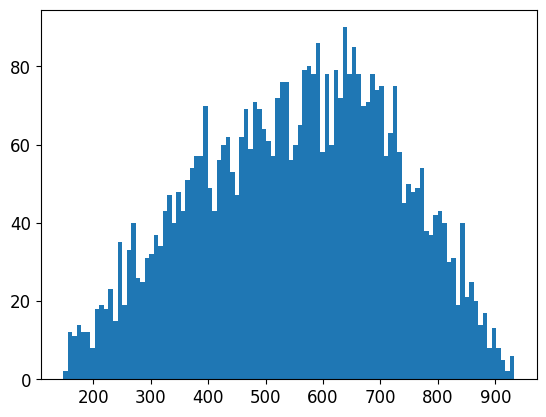

In [100]:
plt.hist(bdf[round(bdf.mass) == round(pi_mass)].momentum, bins=100)
plt.show()

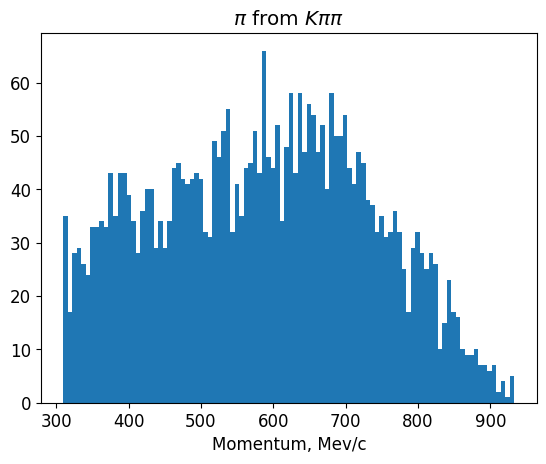

In [73]:
plt.hist(p_pi, bins=100)
plt.xlabel('Momentum, Mev/c')
plt.title(r'$\pi$ from $K\pi\pi$')
plt.show()

In [78]:
len(p_mu)

10047

In [90]:
len(p_mu) / mus

0.34994775339602924

In [91]:
len(p_pi) / pis

0.30363153232949514

In [92]:
len(p_mu) / bdf[round(bdf.mass) == round(mu_mass)].shape[0] / (40/36) /2


0.33757559919360863

In [94]:
len(p_pi) / bdf[round(bdf.mass) == round(pi_mass)].shape[0] / (40/36) / 2

0.3353478260869565

In [45]:
np.sum([round(bdf.loc[i].mass) == round(ka_mass) for i in range(0, len(good_events), 2)])

4779

In [122]:
bdf[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])

In [55]:
bdf[['mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])


In [56]:
bdf['mass_reco'] = label_encoder.inverse_transform(model.predict(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]))

In [44]:
pi_rel_eff = bdf[(bdf.mass_reco  == pi_mass) & (bdf.mass == pi_mass) & (bdf.theta_p < 0.79) & (bdf.momentum > 310)].shape[0] / (bdf[(bdf.mass == pi_mass) & (bdf.theta_p < 0.79) & (bdf.momentum > 310)].shape[0] + 1e-4)

In [45]:
bkg_rel_eff = bdf[(bdf.mass_reco  == 0) & ((bdf.mass == 0) | (bdf.mass == ka_mass)) & (bdf.theta_p < 0.79) & (bdf.momentum > 310)].shape[0] / bdf[((bdf.mass == 0) | (bdf.mass == ka_mass)) & (bdf.theta_p < 0.79) & (bdf.momentum > 310)].shape[0]

In [46]:
mu_rel_eff = bdf[(bdf.mass_reco  == mu_mass) & (bdf.mass == mu_mass) & (bdf.theta_p < 0.79) & (bdf.momentum > 310)].shape[0] / bdf[(bdf.mass == mu_mass) & (bdf.theta_p < 0.79)& (bdf.momentum > 310)].shape[0]

In [47]:
mu_rel_eff

0.9566015230755115

In [48]:
print(bkg_rel_eff, mu_rel_eff)

0.0 0.9566015230755115


In [129]:
print(bkg_rel_eff, mu_rel_eff)

0.9933318390675782 0.9652064353556891


In [49]:
print(pi_rel_eff, mu_rel_eff)

0.9070612433265512 0.9566015230755115


In [51]:
kamu_gen = 0
kapi_gen = 0
kamu_reco = 0
kamu_misreco = 0
for i in range(bdf.shape[0]-2):
    if bdf.loc[i].theta_p < 0.79 and bdf.loc[i + 1].theta_p < 0.79 and bdf.loc[i].momentum > 310 and bdf.loc[i + 1].momentum > 310:
        if round(bdf.loc[i + 1].mass) == round(mu_mass):
            kamu_gen += 1
            if bdf.loc[i].mass_reco == 0 and round(bdf.loc[i + 1].mass_reco) == round(mu_mass):
                kamu_reco += 1
        elif round(bdf.loc[i + 1].mass) == round(pi_mass):
            kapi_gen += 1
            if bdf.loc[i].mass_reco == 0 and round(bdf.loc[i + 1].mass_reco) == round(mu_mass):
                kamu_misreco += 1
        # elif bdf.loc[i].mass_reco == ka_mass and bdf.loc[i + 1].mass_reco == mu_mass:
print('Efficiency', kamu_reco / kamu_gen)
print('MisId', kamu_misreco / kapi_gen)

Efficiency 0.0
MisId 0.0


In [69]:
kamu_gen = 0
kapi_gen = 0
kamu_reco = 0
kamu_misreco = 0
p_mu = []
p_pi = []
for i in range(bdf.shape[0]-2):
    if bdf.loc[i].theta_p < 0.79 and bdf.loc[i + 1].theta_p < 0.79 and bdf.loc[i].momentum > 310 and bdf.loc[i + 1].momentum > 310:
        if round(bdf.loc[i + 1].mass) == round(mu_mass):
            kamu_gen += 1
            p_mu.append(bdf.loc[i+1].momentum)
            if round(bdf.loc[i].mass_reco) == round(ka_mass) and round(bdf.loc[i + 1].mass_reco) == round(mu_mass):
                kamu_reco += 1
        elif round(bdf.loc[i + 1].mass) == round(pi_mass):
            kapi_gen += 1
            p_pi.append(bdf.loc[i+1].momentum)
            if round(bdf.loc[i].mass_reco) == round(ka_mass) and round(bdf.loc[i + 1].mass_reco) == round(mu_mass):
                kamu_misreco += 1
        # elif bdf.loc[i].mass_reco == ka_mass and bdf.loc[i + 1].mass_reco == mu_mass:
print('Efficiency', kamu_reco / kamu_gen)
print('MisId', kamu_misreco / kapi_gen)

Efficiency 0.8282074251020205
MisId 0.059509918319719954


In [69]:
kamu_gen = 0
kapi_gen = 0
kamu_reco = 0
kamu_misreco = 0
delims = np.linspace(0.001, 0.99, 100)
effs = []
misids = []


for delim in delims:
    kamu_gen = 0
    kapi_gen = 0
    kamu_reco = 0
    kamu_misreco = 0
    for i in range(bdf.shape[0]-2):
        if bdf.loc[i].theta_p < 0.79 and bdf.loc[i + 1].theta_p < 0.79 and bdf.loc[i].momentum > 310 and bdf.loc[i + 1].momentum > 310:
            if round(bdf.loc[i + 1].mass) == round(mu_mass):
                kamu_gen += 1
                if round(bdf.loc[i].mass_reco) == round(ka_mass) and bdf.loc[i + 1].mu_proba  > 1 - delim:
                    kamu_reco += 1
            elif round(bdf.loc[i + 1].mass) == round(pi_mass):
                kapi_gen += 1
                if round(bdf.loc[i].mass_reco) == round(ka_mass) and bdf.loc[i + 1].pi_proba  < delim:
                    kamu_misreco += 1
    effs.append(kamu_reco / kamu_gen)
    misids.append(kamu_misreco / kapi_gen)
        # elif bdf.loc[i].mass_reco == ka_mass and bdf.loc[i + 1].mass_reco == mu_mass:
# print('Efficiency', kamu_reco / kamu_gen)
# print('MisId', kamu_misreco / kapi_gen)

In [128]:
def calculate_eff_misid(bdf):
    theta_p = bdf.theta_p.values
    momentum = bdf.momentum.values
    mass = np.round(bdf.mass.values)
    mass_reco = np.round(bdf.mass_reco.values)
    mu_proba = bdf.mu_proba.values
    pi_proba = bdf.pi_proba.values
    
    # Предварительная фильтрация по условиям, которые не зависят от delim
    mask = (theta_p[:-1] < 0.79) & (theta_p[1:] < 0.79) & (momentum[:-1] > 310) & (momentum[1:] > 310)
    indices = np.where(mask)[0]
    
    # Предварительно посчитаем маски
    is_mu = mass[indices + 1] == round(mu_mass)
    is_pi = mass[indices + 1] == round(pi_mass)
    is_ka_reco = mass_reco[indices] == round(ka_mass)
    
    # Массивы вероятностей
    mu_probs = mu_proba[indices + 1]
    pi_probs = pi_proba[indices + 1]
    
    # Подсчеты
    effs = []
    misids = []
    
    delims = np.linspace(0.001, 0.99, 100)
    
    for delim in delims:
        mu_mask = is_mu
        mu_pass = is_ka_reco & mu_mask & (mu_probs > 1 - delim)
        kamu_gen = np.sum(mu_mask)
        kamu_reco = np.sum(mu_pass)
    
        pi_mask = is_pi
        pi_fail = is_ka_reco & pi_mask & (pi_probs < delim)
        kapi_gen = np.sum(pi_mask)
        kamu_misreco = np.sum(pi_fail)
    
        effs.append(kamu_reco / kamu_gen if kamu_gen > 0 else 0)
        misids.append(kamu_misreco / kapi_gen if kapi_gen > 0 else 0)
    
    return np.array(effs), np.array(misids)

In [53]:
import csv

In [68]:
data = list(zip(effs_2, misids_2, effs, misids))

# Сохраняем в CSV
with open('eff-misid.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['eff1', 'misid1', 'eff2', 'misid2'])  # заголовки
    writer.writerows(data)

In [129]:
def split_dataframe(df, n_parts, seed=None):
    if seed is not None:
        np.random.seed(seed)

    indices = np.random.permutation(int(df.shape[0] / 2))
    split_indices = np.array_split(indices, n_parts)
    split_indices = [sorted(np.concatenate((split_ind * 2, split_ind * 2 + 1))) for split_ind in split_indices]
    return [df.loc[idx].copy() for idx in split_indices]

In [185]:
num_of_splits = 4
effs_arr = np.zeros((2, num_of_splits, 100))
misids_arr = np.zeros((2, num_of_splits, 100))

for j in range(2):
    bdf = pd.read_pickle(os.path.join('data', f'pickled_bdf_1e{5+j}_decay_field.pkl'))
    if j == 0:
        effs, misids = calculate_eff_misid(bdf)
    elif j == 1:
        effs_2, misids_2 = calculate_eff_misid(bdf)
    split_bdf = split_dataframe(bdf, num_of_splits, 42)
    
    for i in range(num_of_splits):
        e_m = calculate_eff_misid(split_bdf[i])
        effs_arr[j, i, :] = e_m[0]
        misids_arr[j, i, :] = e_m[1]


cross-val

In [163]:
split_bdf[0]

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance,mu_proba,pi_proba,ka_proba,mass_reco
0,493.679993,754.237976,0.836703,1,8.0,0.095826,0.995412,26.816278,0.924726,0.088023,10.520213,4.371176,0.003264,0.012216,0.984520,493.679993
1,139.570007,284.533508,0.897805,1,9.0,0.486501,0.883974,51.981463,0.984727,0.086922,9.681658,5.480781,0.443743,0.349694,0.206563,105.650002
6,493.679993,720.657532,0.824988,0,8.0,0.416123,0.914663,25.544968,0.945690,0.120702,14.630750,5.185127,0.009370,0.011216,0.979414,493.679993
7,105.650002,489.018005,0.977449,25,10.0,0.422704,0.911983,42.060941,0.976145,-0.001303,-0.133345,11.818193,0.955777,0.043912,0.000312,105.650002
10,493.679993,913.501404,0.879749,0,9.0,0.824050,0.679254,19.649372,0.970368,0.090619,10.300587,8.196595,0.334723,0.139298,0.525978,493.679993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35969,105.650002,402.808594,0.967282,14,10.0,0.427500,0.910005,30.578613,0.965523,-0.001759,-0.181867,9.863736,0.973954,0.019758,0.006289,105.650002
35972,493.679993,376.573090,0.606487,0,4.0,0.567060,0.843484,25.085881,0.964463,0.357976,59.024475,5.933149,0.374214,0.403569,0.222217,139.570007
35973,139.570007,883.787598,0.987759,39,10.0,0.071696,0.997431,45.062831,0.986176,-0.001583,-0.160278,28.468805,0.010727,0.989255,0.000018,139.570007
35982,493.679993,699.972656,0.817198,0,8.0,0.197901,0.980481,22.471572,0.945018,0.127820,15.641205,5.235825,0.009638,0.015328,0.975033,493.679993


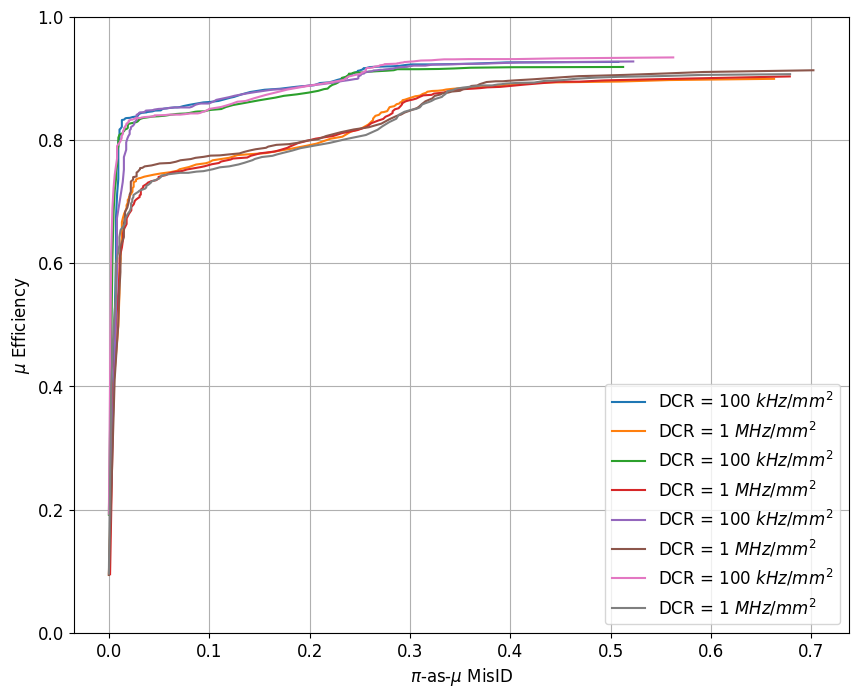

In [157]:
plt.figure(figsize=(10,8))
for i in range(num_of_splits):
    plt.plot(misids_arr[0, i], effs_arr[0, i], label='DCR = 100 $kHz/mm^2$')
    plt.plot(misids_arr[1, i], effs_arr[1, i], label='DCR = 1 $MHz/mm^2$')
# plt.plot(misids_2, effs_2, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\mu$ Efficiency')
# plt.title('DCR = 100 $kHz/mm^2$')
plt.ylim((0, 1))
plt.legend()
plt.grid()
plt.show()

In [187]:
eff_error_for_1e5 = np.mean(np.abs(np.diff(effs_arr[0, :,], axis=0)), axis=0)
misid_error_for_1e5 = np.mean(np.abs(np.diff(misids_arr[0, :,], axis=0)), axis=0)

eff_error_for_1e5_rms = np.sqrt(np.mean(np.diff(effs_arr[0, :,], axis=0) ** 2, axis=0))
misid_error_for_1e5_rms = np.sqrt(np.mean(np.diff(misids_arr[0, :,], axis=0) ** 2, axis=0))

In [188]:
eff_error_for_1e6 = np.mean(np.abs(np.diff(effs_arr[1, :,], axis=0)), axis=0)
misid_error_for_1e6 = np.mean(np.abs(np.diff(misids_arr[1, :,], axis=0)), axis=0)

eff_error_for_1e6_rms = np.sqrt(np.mean(np.diff(effs_arr[1, :,], axis=0) ** 2, axis=0))
misid_error_for_1e6_rms = np.sqrt(np.mean(np.diff(misids_arr[1, :,], axis=0) ** 2, axis=0))

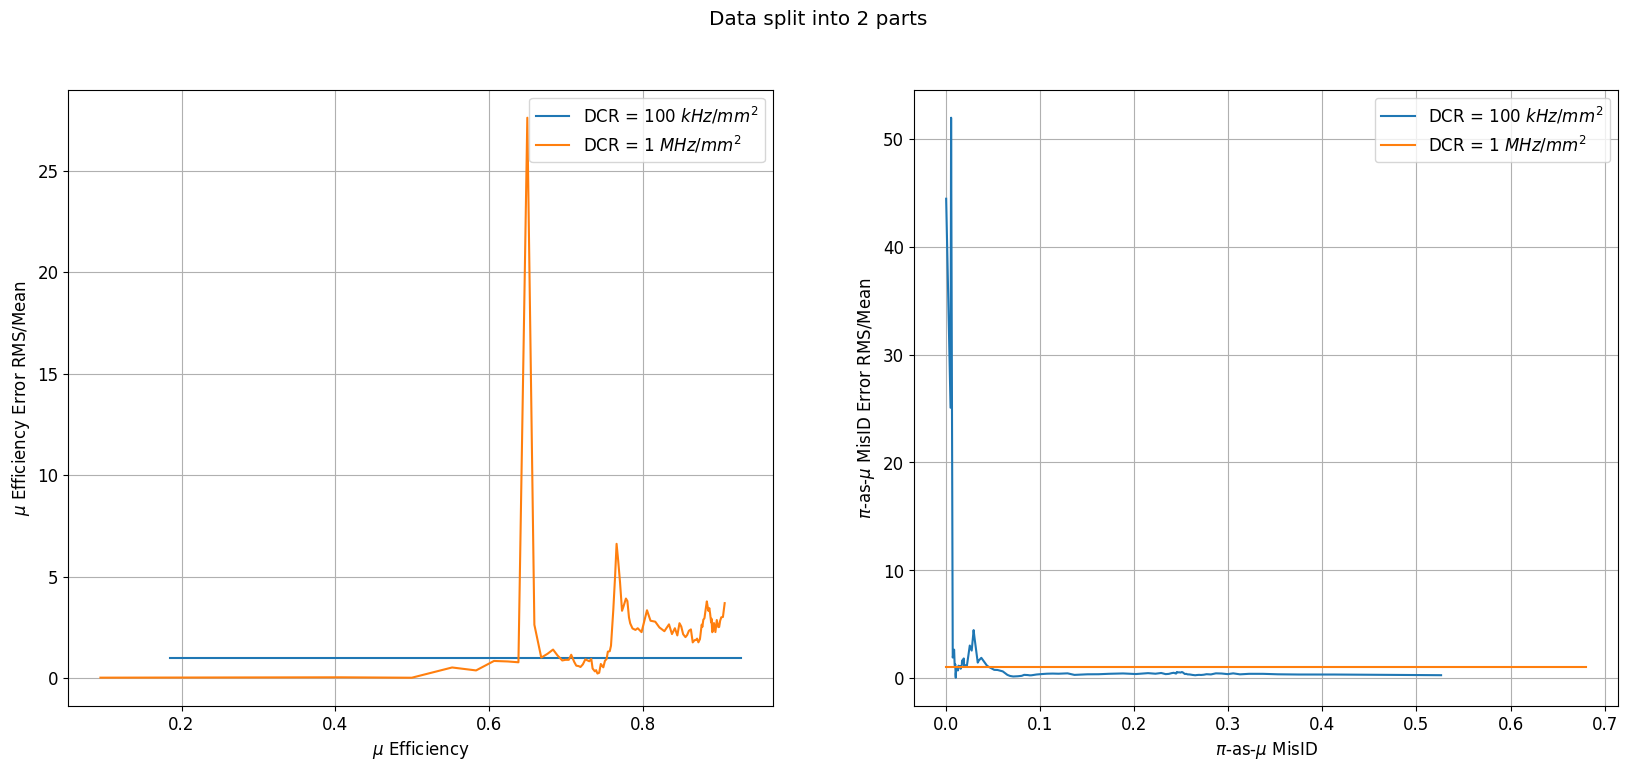

In [182]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(effs, eff_error_for_1e5_rms / eff_error_for_1e5, label='DCR = 100 $kHz/mm^2$')
plt.plot(effs_2, misid_error_for_1e5_rms / eff_error_for_1e6, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\mu$ Efficiency')
plt.ylabel('$\mu$ Efficiency Error RMS/Mean')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(misids, eff_error_for_1e6_rms / misid_error_for_1e5, label='DCR = 100 $kHz/mm^2$')
plt.plot(misids_2, misid_error_for_1e6_rms / misid_error_for_1e6, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\pi$-as-$\mu$ MisID Error RMS/Mean')
plt.suptitle(f'Data split into {num_of_splits} parts')
# plt.ylim((0, 1))
plt.legend()
plt.grid()
plt.show()

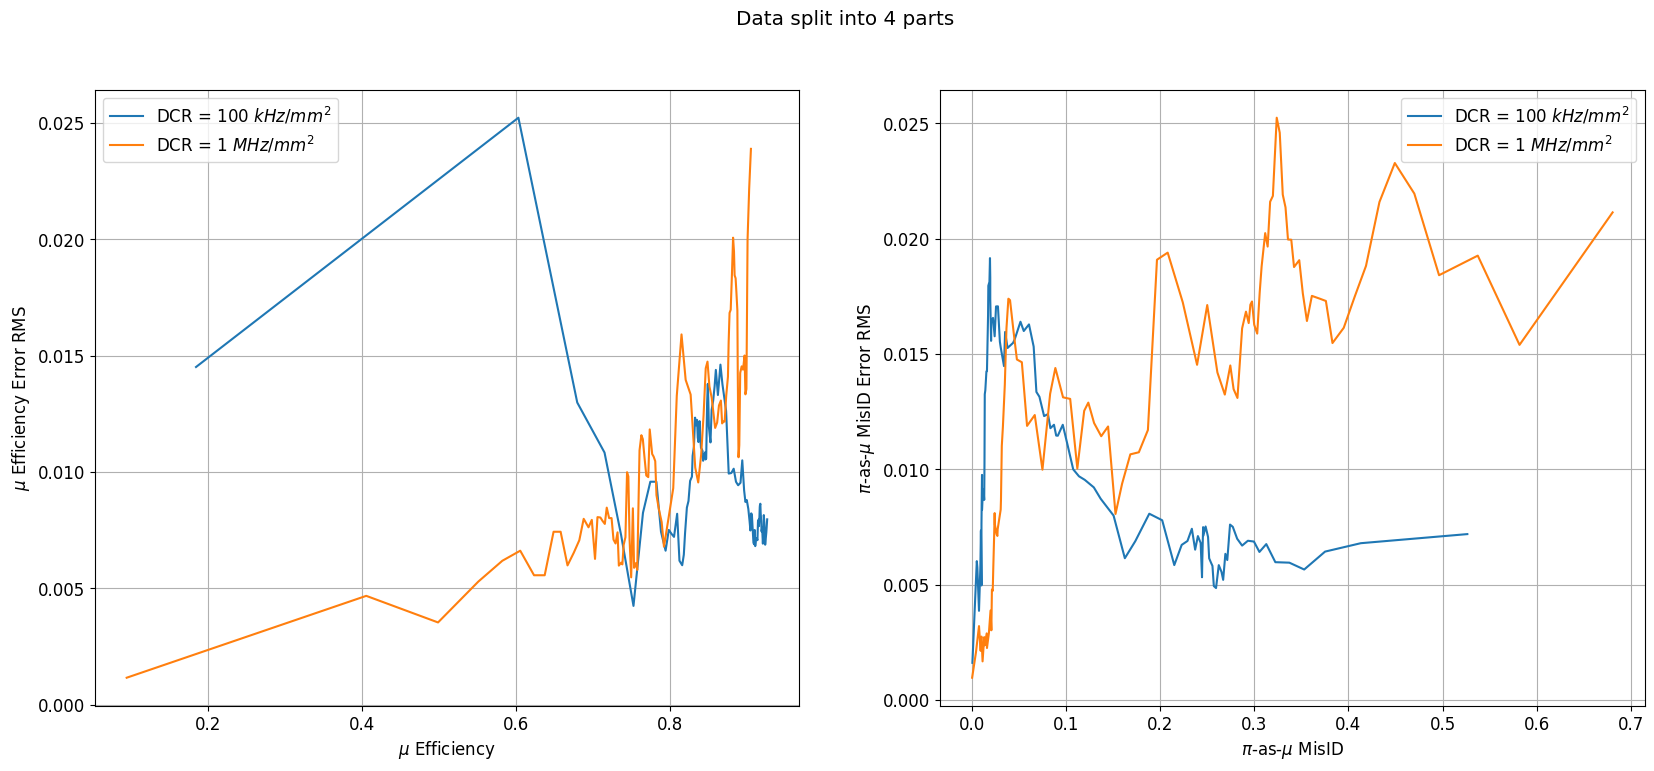

In [189]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(effs, eff_error_for_1e5_rms , label='DCR = 100 $kHz/mm^2$')
plt.plot(effs_2, misid_error_for_1e5_rms, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\mu$ Efficiency')
plt.ylabel('$\mu$ Efficiency Error RMS')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(misids, eff_error_for_1e6_rms , label='DCR = 100 $kHz/mm^2$')
plt.plot(misids_2, misid_error_for_1e6_rms, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\pi$-as-$\mu$ MisID Error RMS')
plt.suptitle(f'Data split into {num_of_splits} parts')
# plt.ylim((0, 1))
plt.legend()
plt.grid()
plt.show()

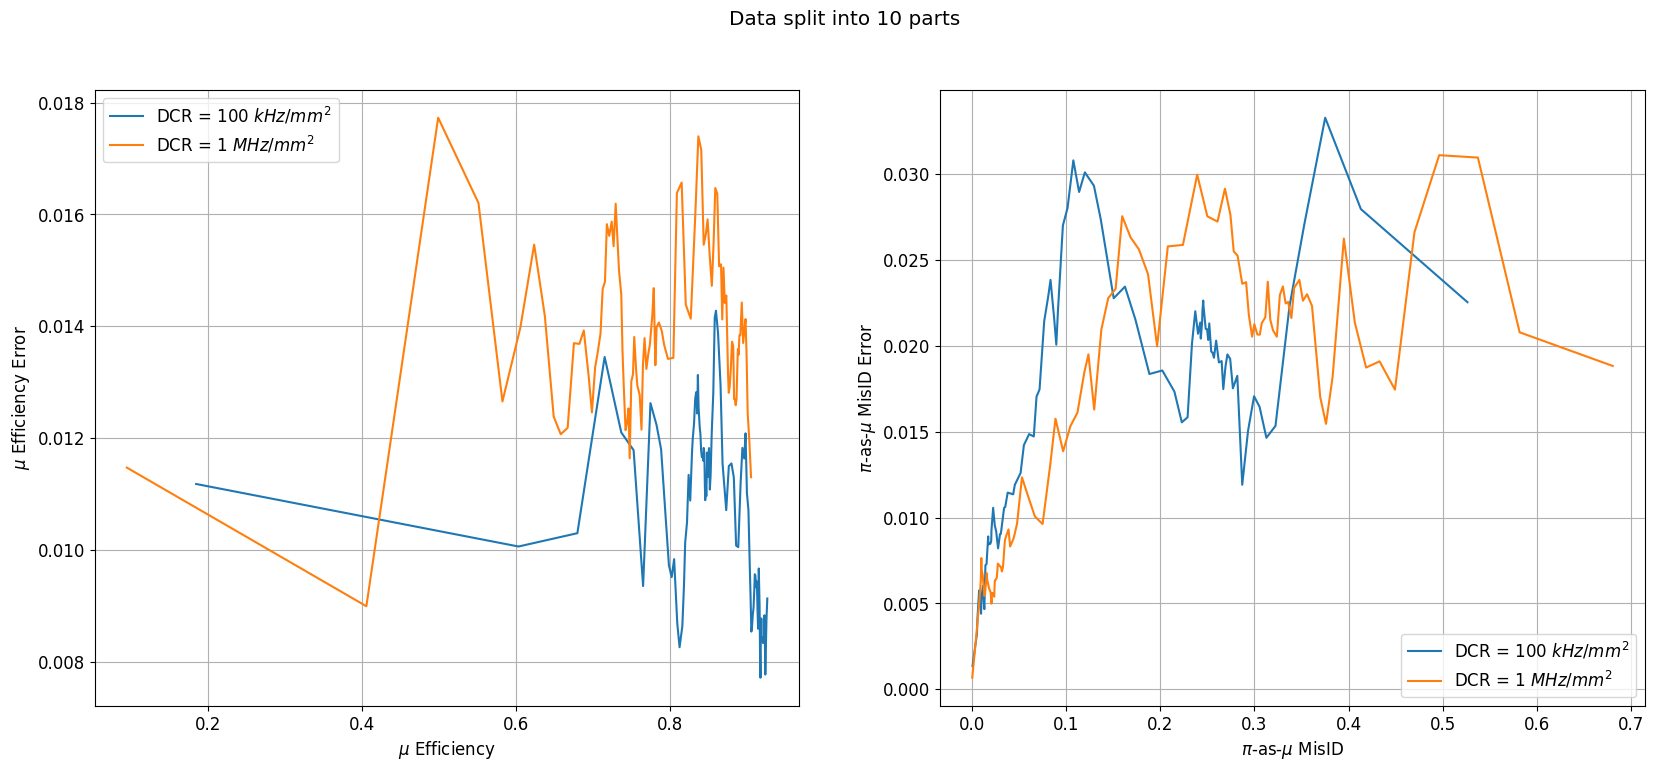

In [167]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(effs, eff_error_for_1e5, label='DCR = 100 $kHz/mm^2$')
plt.plot(effs_2, eff_error_for_1e6, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\mu$ Efficiency')
plt.ylabel('$\mu$ Efficiency Error')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(misids, misid_error_for_1e5, label='DCR = 100 $kHz/mm^2$')
plt.plot(misids_2, misid_error_for_1e6, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\pi$-as-$\mu$ MisID Error')
plt.suptitle(f'Data split into {num_of_splits} parts')
# plt.ylim((0, 1))
plt.legend()
plt.grid()
plt.show()

In [77]:
bdf_d[(bdf_d.momentum > p_lims[0]) & (bdf_d.momentum < p_lims[1])].shape[0]

51098

In [107]:
p_lims = [300, 600, 900, 1200, 1500, 1800, 2500]
delims = np.linspace(0.001, 0.99, 100)
effs_for_ps = np.zeros((len(p_lims), 100))
misids_for_ps = np.zeros((len(p_lims), 100))
for i in range(len(delims)):
    for j in range(len(p_lims) - 1):
        mu_gen = bdf_d[(bdf_d.momentum > p_lims[j]) & (bdf_d.momentum < p_lims[j + 1]) & (round(bdf_d.mass) == round(mu_mass))].shape[0]
        pi_gen = bdf_d[(bdf_d.momentum > p_lims[j]) & (bdf_d.momentum < p_lims[j + 1]) & (round(bdf_d.mass) == round(pi_mass))].shape[0]
        mu_reco = bdf_d[(bdf_d.momentum > p_lims[j]) & (bdf_d.momentum < p_lims[j + 1]) & (round(bdf_d.mass) == round(mu_mass)) & (bdf_d.mu_proba > 1 - delims[i])].shape[0]
        misreco = bdf_d[(bdf_d.momentum > p_lims[j]) & (bdf_d.momentum < p_lims[j + 1]) & (round(bdf_d.mass) == round(pi_mass)) & (bdf_d.mu_proba > 1 - delims[i])].shape[0]
        effs_for_ps[j, i] = mu_reco / mu_gen
        misids_for_ps[j, i] = misreco / pi_gen
    

In [87]:
misids_for_ps

array([[2.17403120e-04, 2.71753900e-04, 3.26104680e-04, 3.80455460e-04,
        3.80455460e-04, 3.80455460e-04, 4.34806239e-04, 5.97858579e-04,
        7.60910919e-04, 7.60910919e-04, 9.78314039e-04, 9.78314039e-04,
        1.08701560e-03, 1.30441872e-03, 1.41312028e-03, 1.68487418e-03,
        1.90227730e-03, 2.17403120e-03, 2.60883744e-03, 2.71753900e-03,
        2.88059134e-03, 3.15234524e-03, 3.36974836e-03, 3.75020382e-03,
        4.18501005e-03, 4.29371161e-03, 4.45676395e-03, 5.00027175e-03,
        5.32637643e-03, 5.54377955e-03, 5.81553345e-03, 6.73949671e-03,
        7.17430295e-03, 7.50040763e-03, 8.09826621e-03, 8.31566933e-03,
        9.07658025e-03, 9.89184195e-03, 1.03809990e-02, 1.13049622e-02,
        1.22289255e-02, 1.33159411e-02, 1.42399043e-02, 1.47834121e-02,
        1.53812707e-02, 1.64139355e-02, 1.78270558e-02, 1.91314745e-02,
        2.13598565e-02, 2.39143432e-02, 2.72297407e-02, 3.08168922e-02,
        3.58171640e-02, 4.21218544e-02, 4.83721941e-02, 5.690526

In [74]:
plt.rcParams['font.size'] = 16

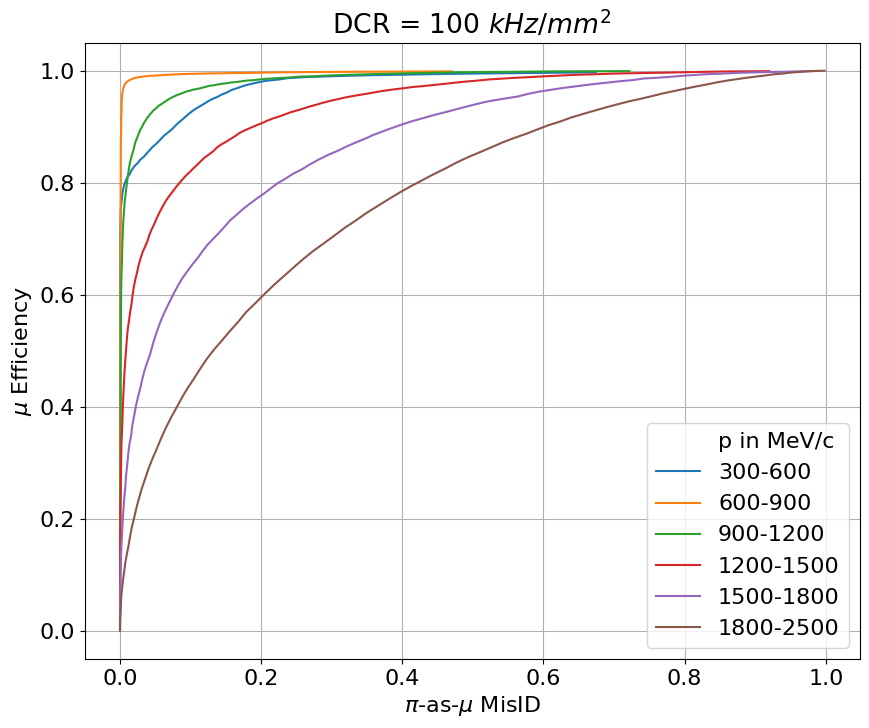

In [109]:
plt.figure(figsize=(10, 8))
plt.scatter(0.5, 0.5, color='white', label='p in MeV/c')
for i in range(len(p_lims)-1):
    plt.plot(misids_for_ps[i], effs_for_ps[i], label=f'{p_lims[i]}-{p_lims[i + 1]}')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\mu$ Efficiency')
plt.title('DCR = 100 $kHz/mm^2$')
plt.grid()
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

In [74]:
bdf_d

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance,mu_proba,pi_proba,ka_proba,mass_reco
1,493.679993,2484.930176,0.980831,32,10.0,0.104736,0.994520,39.953684,0.980328,-0.000503,-0.051289,42.440970,0.000043,0.000135,0.999822,493.679993
2,105.650002,2018.161011,0.998633,46,10.0,0.375733,0.930239,58.161409,0.998436,-0.000196,-0.019667,20.657967,0.722596,0.277308,0.000096,105.650002
4,105.650002,507.325806,0.978997,19,10.0,0.226330,0.974497,44.388707,0.984258,0.005261,0.537369,11.818193,0.996176,0.003821,0.000003,105.650002
5,105.650002,2122.893799,0.998764,5,10.0,0.193289,0.981378,24.845256,0.965525,-0.033239,-3.327997,5.933149,0.133497,0.183693,0.682811,493.679993
6,493.679993,1479.216309,0.948566,1,9.0,0.087610,0.996165,27.884905,0.968542,0.019976,2.105873,4.371176,0.000303,0.003551,0.996146,493.679993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551508,105.650002,2030.340698,0.998649,45,10.0,0.261792,0.965928,56.928265,0.992746,-0.005902,-0.591040,39.091147,0.929155,0.070837,0.000007,105.650002
551510,139.570007,1981.065918,0.997527,45,10.0,0.127679,0.991860,51.959691,0.997359,-0.000169,-0.016892,21.924769,0.287740,0.712083,0.000177,139.570007
551512,139.570007,2499.760498,0.998445,49,10.0,0.448672,0.901024,59.154112,0.997898,-0.000547,-0.054749,34.224713,0.496198,0.503714,0.000089,139.570007
551513,139.570007,378.152161,0.938141,1,9.0,0.250940,0.968679,19.634244,0.960908,0.022767,2.426815,3.065458,0.053009,0.651102,0.295889,139.570007


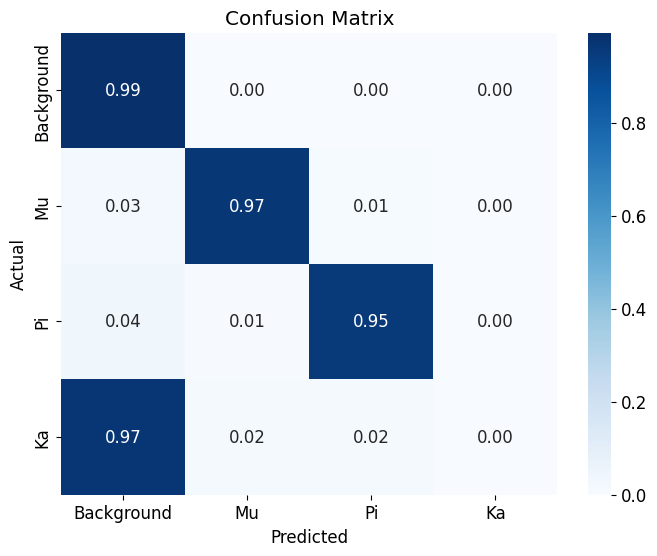

In [134]:
y_test_2 = label_encoder.transform(bdf[(bdf.theta_p < 0.79) & (bdf.momentum > 310)].mass)
# y_pred_2 = model.predict(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
y_pred_2 = label_encoder.transform(bdf[(bdf.theta_p < 0.79) & (bdf.momentum > 310)].mass_reco)
cm = confusion_matrix(y_test_2, y_pred_2)   
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'Mu', 'Pi', 'Ka']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [90]:
bdf[(bdf.momentum > 310) & (bdf.theta_p < 0.79) & (bdf.mass == mu_mass) & (bdf.momentum < 350)].shape[0] / bdf[(bdf.momentum > 310) & (bdf.theta_p < 0.79) & (bdf.mass == mu_mass)].shape[0] 

0.06638115631691649

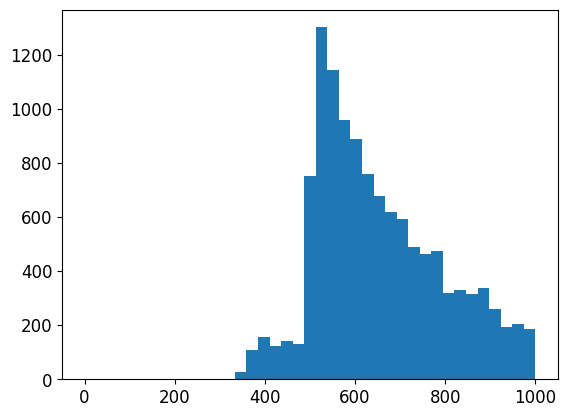

In [71]:
plt.hist(bdf_d[bdf_d.mass == mu_mass].momentum, bins=bins)
plt.show()

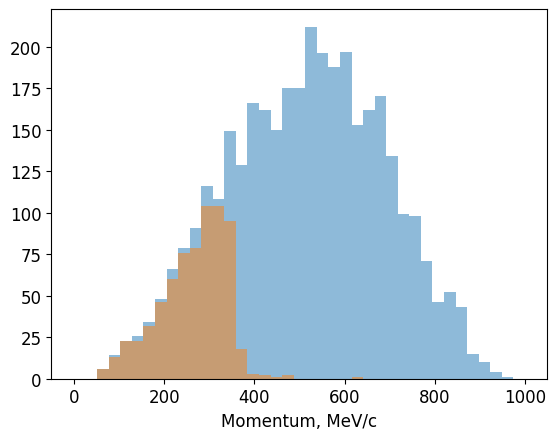

In [69]:
bins = np.linspace(0, 1000, 40)
plt.hist(bdf[(bdf.mass == mu_mass)].momentum, alpha=0.5, bins=bins)
plt.hist(bdf[(bdf.mass_reco == 0) & (bdf.mass == mu_mass)].momentum, alpha=0.5,  bins=bins)
plt.xlabel('Momentum, MeV/c')
plt.show()

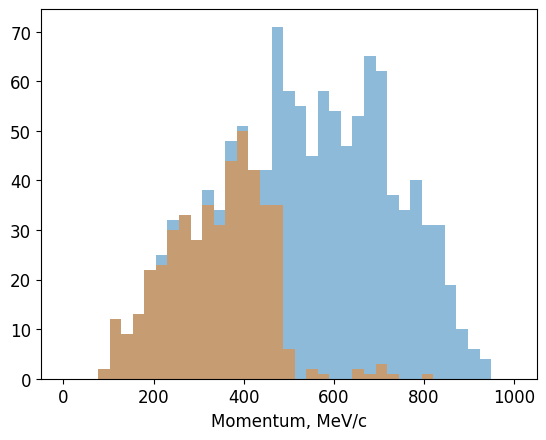

In [80]:
plt.hist(bdf[(bdf.mass == pi_mass)].momentum, alpha=0.5, bins=bins)
plt.hist(bdf[(bdf.mass_reco == 0) & (bdf.mass == pi_mass)].momentum, alpha=0.5,  bins=bins)
plt.xlabel('Momentum, MeV/c')
plt.show()

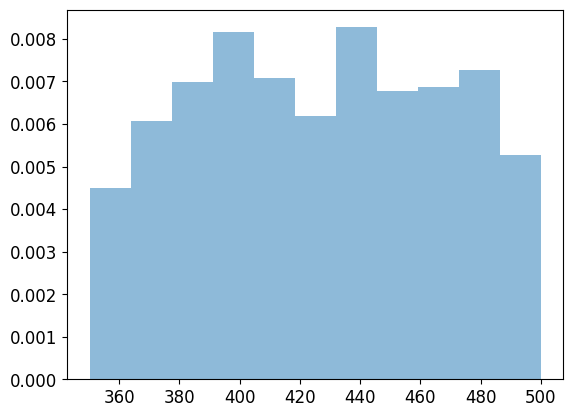

In [81]:
plt.hist(bdf_d[(bdf_d.mass == mu_mass) & (bdf_d.momentum < 500)].momentum, alpha=0.5, bins='auto', density=True)
plt.show()

In [251]:
momentum_from_beta(beta_from_momentum(500, pi_mass), mu_mass)

378.4839148814214

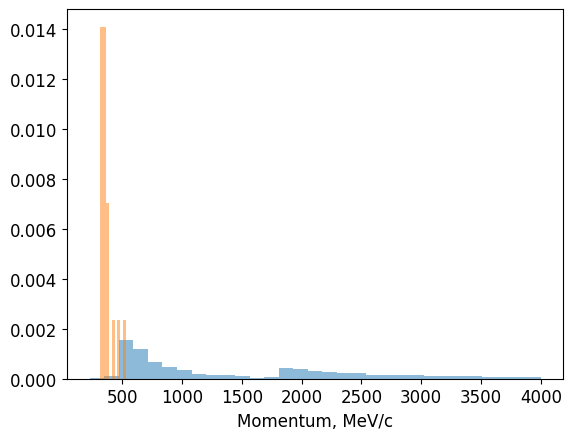

In [159]:
plt.hist(bdf_d[(bdf_d.mass == 0)].momentum, alpha=0.5, bins='auto', density=True)
plt.hist(bdf_d[(bdf_d.mass_reco == mu_mass) & (bdf_d.mass == 0)].momentum, alpha=0.5,  bins='auto', density=True)
plt.xlabel('Momentum, MeV/c')
plt.show()

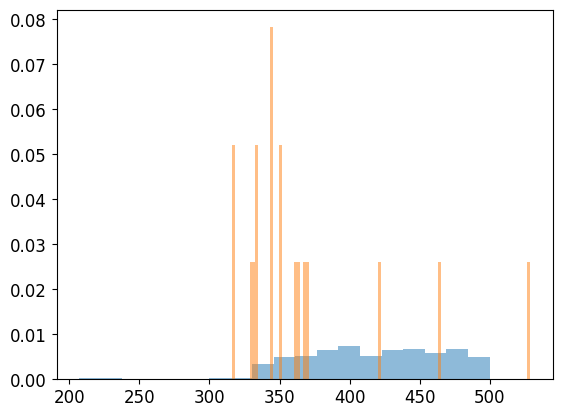

In [167]:
plt.hist(bdf_d[(bdf_d.mass == mu_mass) & (bdf_d.momentum < 500)].momentum, alpha=0.5, bins='auto', density=True)
plt.hist(bdf_d[(bdf_d.mass_reco == mu_mass) & (bdf_d.mass == 0)].momentum, alpha=0.5, bins=100, density=True)
plt.show()

In [190]:
bdf_d[(bdf_d.signal_counts <= 3) & (bdf_d.mass != 0)].shape

(292, 17)

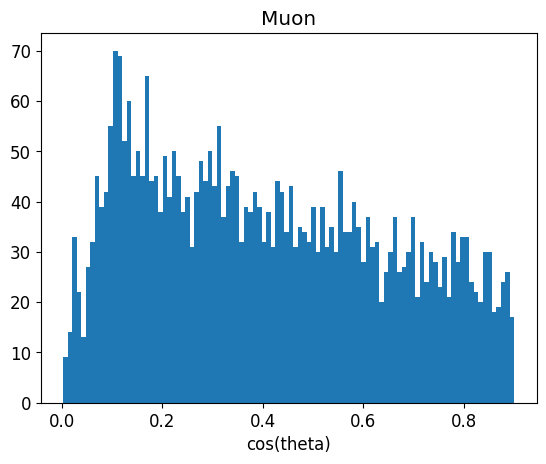

In [110]:
plt.hist(bdf[(bdf.mass == mu_mass)].theta_p, bins=100)
plt.title('Muon')
plt.xlabel('cos(theta)')
plt.show()

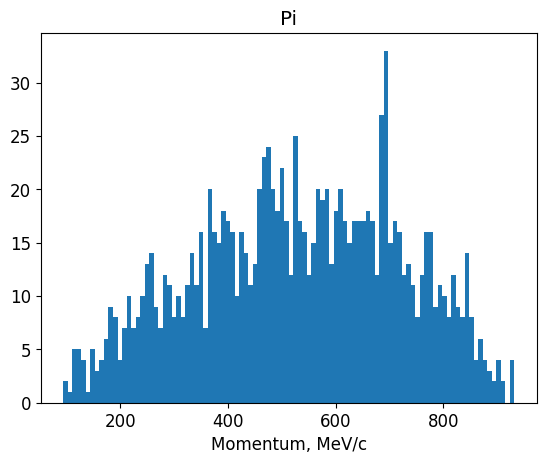

In [84]:
plt.hist(bdf[(bdf.mass == pi_mass)].momentum, bins=100)
plt.title('Pi')
plt.xlabel('Momentum, MeV/c')
plt.show()

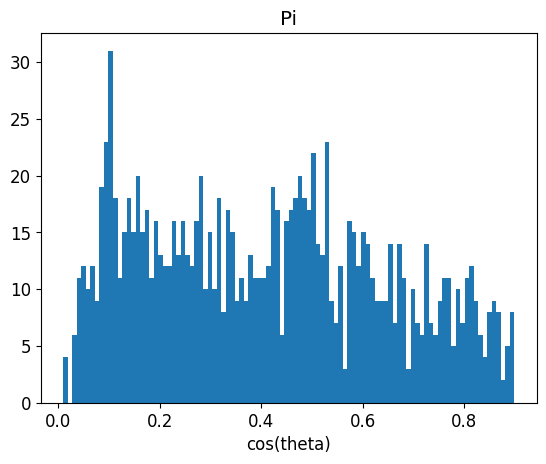

In [109]:
plt.hist(bdf[(bdf.mass == pi_mass)].theta_p, bins=100)
plt.title('Pi')
plt.xlabel('cos(theta)')
plt.show()

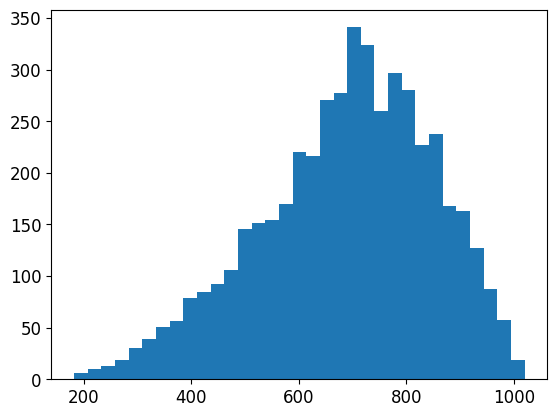

In [72]:
plt.hist(bdf[(bdf.mass == ka_mass)].momentum, bins='auto')
plt.show()

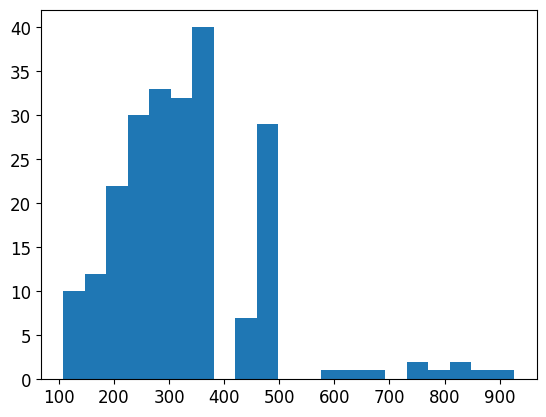

In [59]:
plt.hist(bdf[(bdf.mass == pi_mass) & (bdf.mass_reco == mu_mass)].momentum, bins='auto')
plt.show()

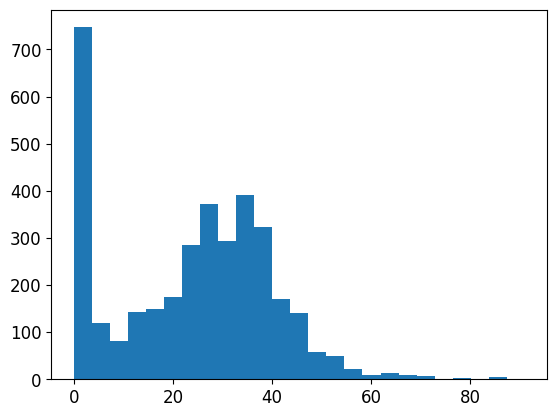

In [65]:
plt.hist(bdf[(bdf.mass == mu_mass)].signal_counts, bins='auto')
plt.show()

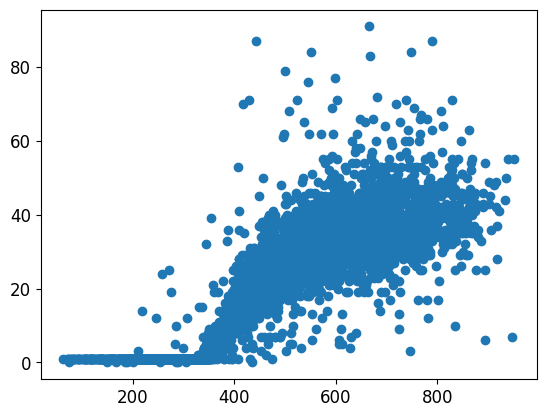

In [73]:
plt.scatter(bdf[bdf.mass == mu_mass].momentum, bdf[bdf.mass == mu_mass].signal_counts)
plt.show()

In [75]:
bdf[(bdf.mass == mu_mass) & (bdf.mass_reco == mu_mass) & (bdf.signal_counts > 1)].shape[0] / bdf[(bdf.mass == mu_mass) & (bdf.signal_counts > 1)].shape[0]

0.9920387677397023

In [69]:
bdf[(bdf.mass == pi_mass) & (bdf.mass_reco == mu_mass) & (bdf.signal_counts > 1)].shape[0] / bdf[(bdf.mass == pi_mass) & (bdf.signal_counts > 1)].shape[0]

0.06337135614702155

спектры всех частиц из своих каналов, пи0 и гамма тоже, и углы
посчитать испульс в поле 1 тесла чтобы попал под углом 45
кусок про откуда координаты и время переписать


In [147]:
800 / (2 * np.sin(np.pi / 8))

1045.2503719011013

In [148]:
1.045 / 3.3

0.31666666666666665

In [90]:
ka_from_mu = []
ka_from_pi = []
for i in range(0, bdf.shape[0], 2):
    if round(bdf.loc[i+1].mass) == round(mu_mass):
        ka_from_mu.append(i)
    elif round(bdf.loc[i+1].mass) == round(pi_mass):
        ka_from_pi.append(i)

In [95]:
bdf.loc[ka_from_mu]

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance,bckg_proba,mu_proba,pi_proba,ka_proba,mass_reco
2,493.679993,852.305603,0.865321,0,9.0,0.770976,0.717231,30.630986,0.967734,0.102413,11.835266,5.953923,0.998789,0.000003,0.001203,0.000006,0.0
4,493.679993,768.594788,0.841386,0,8.0,0.387151,0.925988,20.556289,0.969761,0.128375,15.257592,7.772325,0.986411,0.000082,0.013473,0.000034,0.0
6,493.679993,720.657532,0.824988,0,8.0,0.413711,0.915635,26.896685,0.966375,0.141387,17.138062,6.747280,0.999093,0.000014,0.000889,0.000004,0.0
12,493.679993,943.804626,0.886099,1,9.0,0.427525,0.909995,45.823519,0.983159,0.097060,10.953650,7.148423,0.979778,0.000012,0.020185,0.000024,0.0
14,493.679993,593.852966,0.768983,0,7.0,0.115821,0.993300,23.712441,0.965896,0.196913,25.606867,6.747280,0.995446,0.000017,0.004531,0.000006,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9548,493.679993,912.090149,0.879441,0,9.0,0.096998,0.995299,30.027940,0.971745,0.092304,10.495739,5.321678,0.999893,0.000012,0.000094,0.000001,0.0
9550,493.679993,544.677246,0.740942,1,7.0,0.629928,0.808070,14.252245,0.973839,0.232897,31.432507,9.147904,0.990721,0.000579,0.008684,0.000017,0.0
9552,493.679993,839.401489,0.861973,0,8.0,0.863243,0.649976,18.536404,0.964351,0.102379,11.877253,9.147904,0.987713,0.000022,0.012245,0.000020,0.0
9554,493.679993,727.354126,0.827413,0,8.0,0.344697,0.941178,62.450278,0.976234,0.148821,17.986254,5.278973,0.998943,0.000174,0.000863,0.000020,0.0


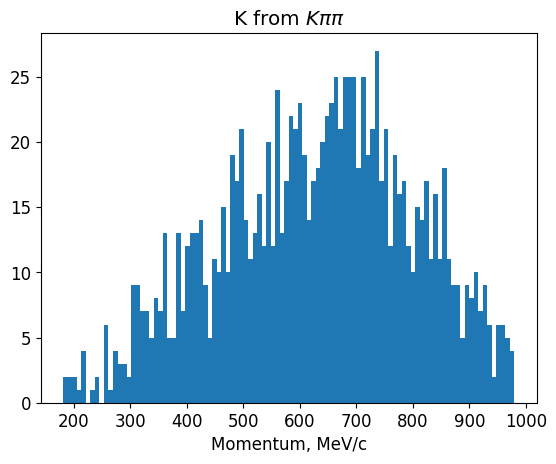

In [107]:
plt.hist(bdf[(bdf.mass == ka_mass)].loc[ka_from_pi].momentum, bins=100)
plt.title(r'K from $K\pi\pi$')
plt.xlabel('Momentum, MeV/c')
plt.show()

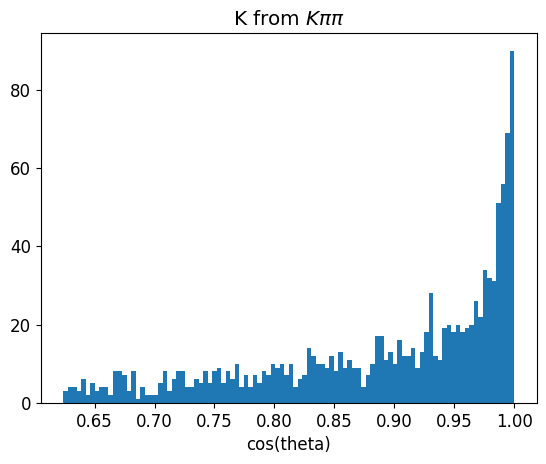

In [112]:
plt.hist(bdf[(bdf.mass == ka_mass)].loc[ka_from_pi].cos_theta_p, bins=100)
plt.title(r'K from $K\pi\pi$')
plt.xlabel('cos(theta)')
plt.show()

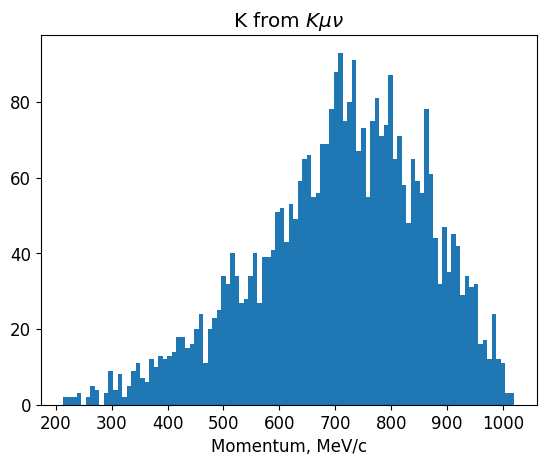

In [103]:
plt.hist(bdf[(bdf.mass == ka_mass)].loc[ka_from_mu].momentum, bins=100)
plt.title(r'K from $K\mu\nu$')
plt.xlabel('Momentum, MeV/c')
plt.show()

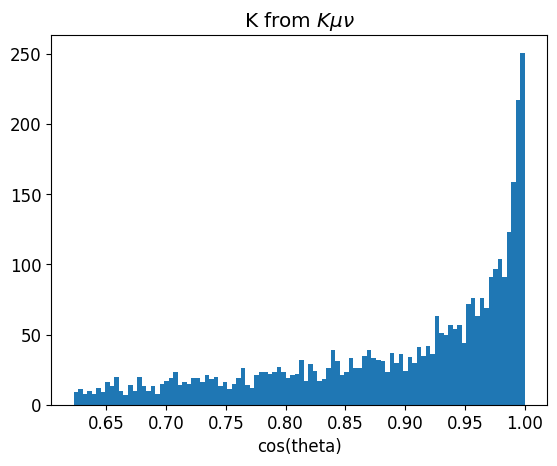

In [116]:
plt.hist(bdf[(bdf.mass == ka_mass)].loc[ka_from_mu].cos_theta_p, bins=100)
plt.title(r'K from $K\mu\nu$')
plt.xlabel('cos(theta)')
plt.show()

1) Последовательное описание того, что вы делали:

- сколько было сгенерировано Psi(3770)
-   10.000 только для подсчёта эффективности восстановления пи0, и ещё суммарно 10.000 для kpipi и Kmunu
- какие распады для 3770 были разрешены
-   только DantiD
- как распадался D-мезон (что именно написано в его распадной таблице)
-   В первых 10.000 для пи0 вот так: 1.000 K- pi+ MyPi0  PHSP; и пи0 на 2 гамма
-   Во вторых 10.000 
Decay MyD0
0.034700000 K- mu+ nu_mu  PHOTOS   ISGW2;
0.013580300 K- pi+ pi0  PHSP; тут уже умножено на вероятность не реконструировать пи0
Enddecay
- сколько у вас событий с распадом D-мезона на Kpipi0 и сколько на Kmunu?
-   2718 и 7282 соответственно до отборов; 1215 и 3564 после описанного ниже отбора
- что происходило  со вторым D-мезоном?
-   1.000 geantino PHSP;
- распады на Kpipi0 и Kmunu генерировались отдельно, или внутри одного сэмпла?
-   Kpipi0 отдельно только для проверки восстановления pi0 в первых 10.000, во второых 10.000 для всего остального в одном сэмпле и то и другое
- какие требования вы накладывали на K, pi, фотоны, мюон (для каждого отдельным списком)?
-   Первые 10.000:
-       Ничего для pi0
-       Хотя бы один из фотонов меньше 30 МэВ или не попал в калориметр
-   Вторые 10.000:
-       обе частицы из пары kpi/kmu должны записаться в чувствительном слое барреля фарича

2) По картинкам:
- запишите в явном виде определение всех переменных, которые вы используете -- углы и тд
-   Использую где? В этих картинках угол cos\theta=p_z/p; и импульс p = \sqrt(p_x^2+p_y^2+p_z^2)
- почему в гистограмме с названием Pi спектр заканчивается по углу не там же, где и для каонов? Почему есть несколько событий за концом спектра?
-   Как будто он кончается почти там же. Парочка событий выбиываются, это странно. Вот гистограммы для 10.000 событий только Kpipi.
- что именно отложено по вертикали? "Прыжки" бинов явно не согласуются с пуассоновской статистикой -- у вас скоррелированные события?
-   Просто число событий. Во всех гистограммах ровно 100 бинов. В моём понимании корреляций быть не должно, всё генерировалось одновременно.

In [33]:
1215 / 3564

0.3409090909090909

In [ ]:
2718 / 7282

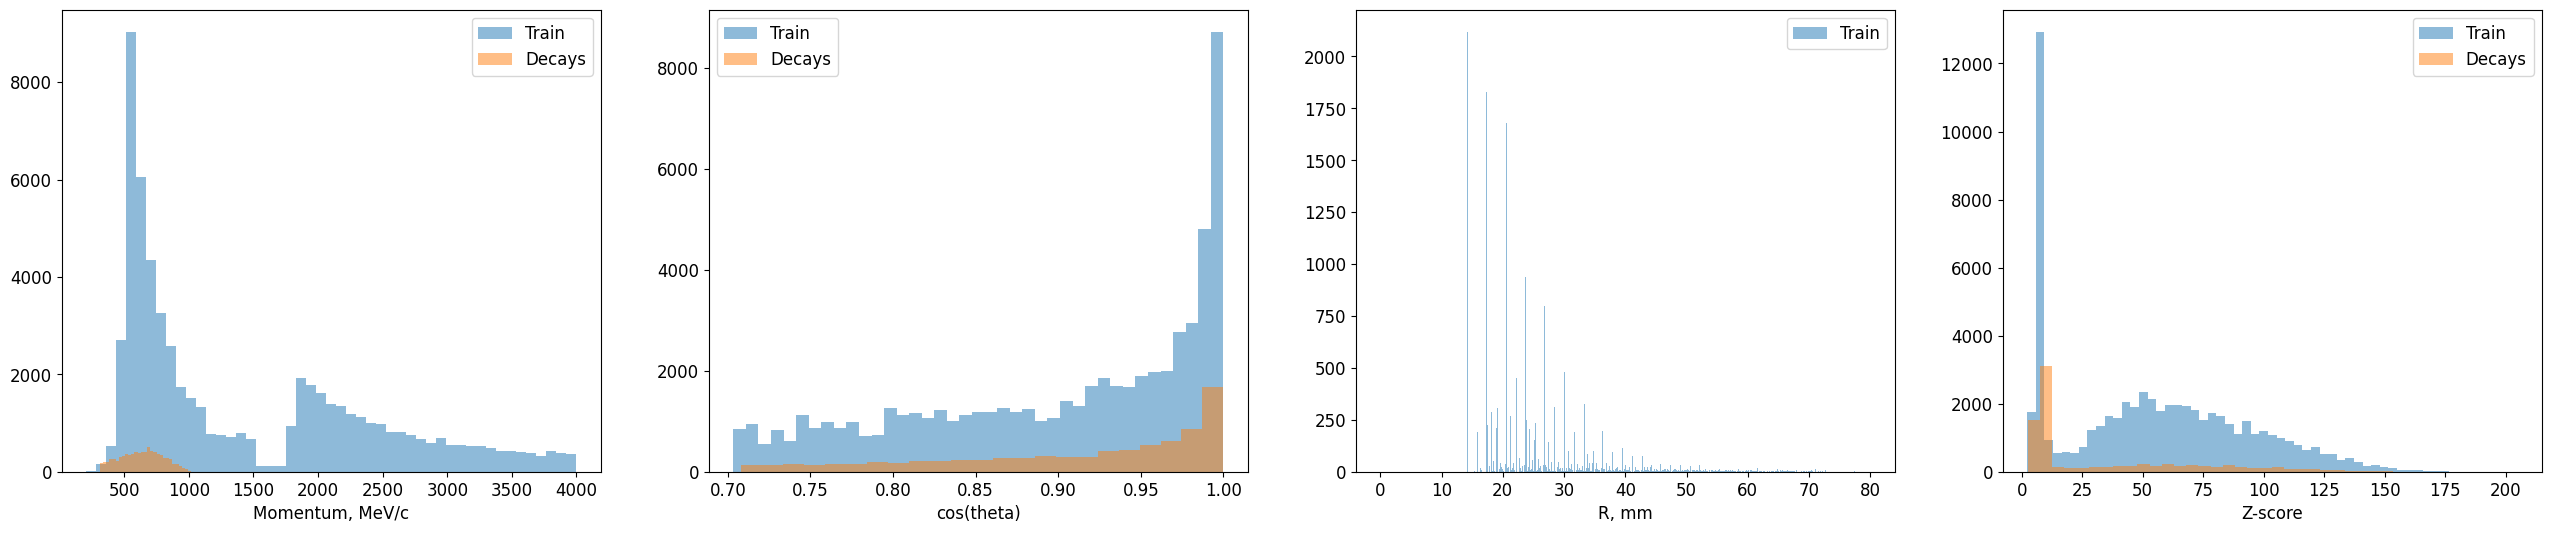

In [104]:
plt.figure(figsize=(32, 6))

plt.subplot(1, 4, 1)

plt.hist(bdf_d.momentum, alpha=0.5, density=False, bins='auto', label='Train')
plt.hist(bdf[(bdf.momentum > 310) & (bdf.cos_theta_p > 0.708)].momentum, alpha=0.5, density=False, bins='auto', label='Decays')
plt.xlabel('Momentum, MeV/c')
plt.legend()

plt.subplot(1, 4, 2)
plt.hist(bdf_d.cos_theta_p, alpha=0.5, density=False, bins='auto', label='Train')
plt.hist(bdf[(bdf.momentum > 310) & (bdf.cos_theta_p > 0.708)].cos_theta_p, alpha=0.5, density=False, bins='auto', label='Decays')
plt.xlabel('cos(theta)')
plt.legend()

plt.subplot(1, 4, 3)
plt.hist(bdf_d[bdf_d.mass ==0].unfixed_calculated_r_2d_4_rsigms_4_tsigms, alpha=0.5, density=False, bins=np.linspace(0, 80, 500), label='Train')
# plt.hist(bdf[(bdf.momentum > 310) & (bdf.cos_theta_p > 0.708)].unfixed_calculated_r_2d_4_rsigms_4_tsigms, alpha=0.5, density=False, bins='auto', label='Decays')
plt.xlabel('R, mm')
plt.legend()

plt.subplot(1, 4, 4)
plt.hist(bdf_d.distance, alpha=0.5, density=False, bins='auto', label='Train')
plt.hist(bdf[(bdf.momentum > 310) & (bdf.cos_theta_p > 0.708)].distance, alpha=0.5, density=False, bins='auto', label='Decays')
plt.xlabel('Z-score')
plt.legend()

plt.show()

In [105]:
bdf_d

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance,bckg_proba,mu_proba,pi_proba,ka_proba,mass_reco
0,105.650002,373.608704,0.962266,13,7.0,0.597453,0.826771,27.690175,0.966547,0.004281,0.444936,38.888112,0.000667,0.995827,0.003440,0.000066,105.650002
1,0.000000,765.634766,0.983788,0,9.0,0.711210,0.757572,20.556289,0.966879,-0.016909,-1.718748,7.772325,0.992904,0.000007,0.007081,0.000008,0.000000
2,0.000000,722.940369,0.989490,0,10.0,0.737575,0.740101,45.823519,0.973899,-0.015590,-1.575603,7.148423,0.901266,0.000100,0.098614,0.000019,0.000000
3,493.679993,3321.506104,0.989134,38,10.0,0.560077,0.847214,54.930403,0.988765,-0.000369,-0.037270,58.589274,0.000002,0.000017,0.005763,0.994218,493.679993
4,493.679993,2036.828491,0.971861,13,8.0,0.193191,0.981397,31.987790,0.972440,0.000579,0.059576,45.435754,0.000005,0.000005,0.000176,0.999813,493.679993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60825,0.000000,1891.088623,0.967573,0,3.0,0.144120,0.989633,17.402254,0.968940,0.001367,0.141260,9.147904,0.984544,0.000005,0.000040,0.015412,0.000000
60826,0.000000,984.110107,0.994287,0,9.0,0.202445,0.979578,14.252245,0.969550,-0.024736,-2.487842,5.321678,0.999818,0.000004,0.000172,0.000006,0.000000
60827,0.000000,585.144287,0.972713,0,4.0,0.169712,0.985633,23.712441,0.965893,-0.006820,-0.701104,6.747280,0.997716,0.000024,0.002254,0.000006,0.000000
60828,0.000000,1924.597656,0.968640,0,3.0,0.570708,0.841519,19.634244,0.967585,-0.001055,-0.108916,9.147904,0.988610,0.000002,0.000030,0.011359,0.000000


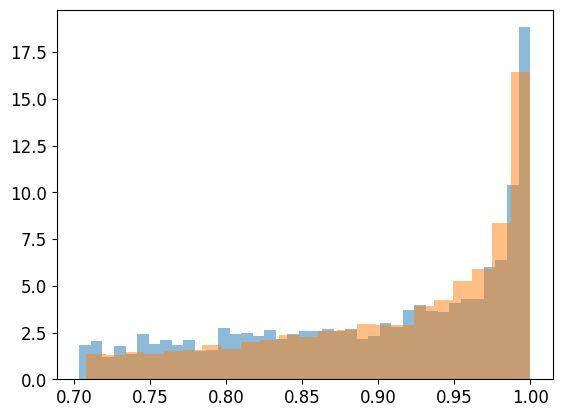

In [62]:
plt.hist(bdf_d.cos_theta_p, alpha=0.5, density=True, bins='auto')
plt.hist(bdf[(bdf.momentum > 310) & (bdf.cos_theta_p > 0.708)].cos_theta_p, alpha=0.5, density=True, bins='auto')
plt.show()

In [47]:
# Assuming `bdf_d` is your pandas DataFrame
# Step 1: Extract features and target
X_1 = bdf_d[bdf_d.mass != ka_mass][['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]
y_1 = bdf_d[bdf_d.mass != ka_mass]['mass']


y_encoded_1= label_encoder.transform(y_1)  # mass: [139.57 -> 0, 105.65 -> 1]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_encoded_1, test_size=0.2, random_state=42)

In [48]:
model_1 = xgb.XGBClassifier(
    objective='multi:softprob',  # Правильный режим для multi-class
    num_class=4,
    eval_metric='mlogloss',  # Log loss для многоклассовой задачи
    use_label_encoder=False,
    learning_rate=0.1,     
    n_estimators=650,      # Подбираем снова
    max_depth=5,           # Подобрали выше
    min_child_weight=1,    # Подобрали выше
    gamma=0.6,             # Подобрали выше
    subsample=0.9,         # Подобрали выше
    colsample_bytree=0.75, # Подобрали выше
    reg_alpha=1e-5,        # Подобрали выше
    seed=42,
    n_jobs=-1  
)
model_1.fit(X_train_1, y_train_1)

# Step 5: Evaluate the model
y_pred_1 = model_1.predict(X_test_1[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
accuracy = accuracy_score(y_test_1, y_pred_1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_1, y_pred_1))

# Optional: Map back predictions to mass values if needed
y_pred_mass_1 = label_encoder.inverse_transform(y_pred_1)

X_test_1['mass'] = label_encoder.inverse_transform(y_test_1)
X_test_1['mass_reco'] = y_pred_mass_1

Accuracy: 0.955364900086881
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3092
           1       0.94      0.94      0.94      3088
           2       0.94      0.93      0.93      3028

    accuracy                           0.96      9208
   macro avg       0.96      0.96      0.96      9208
weighted avg       0.96      0.96      0.96      9208



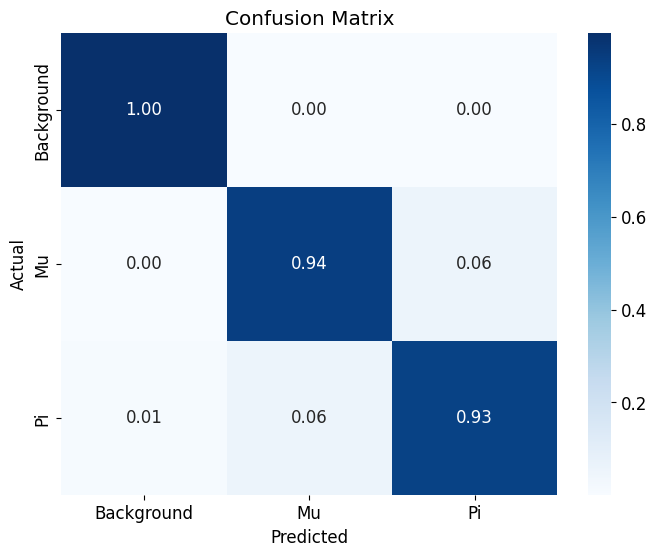

In [49]:
cm = confusion_matrix(y_test_1, y_pred_1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'Mu', 'Pi']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

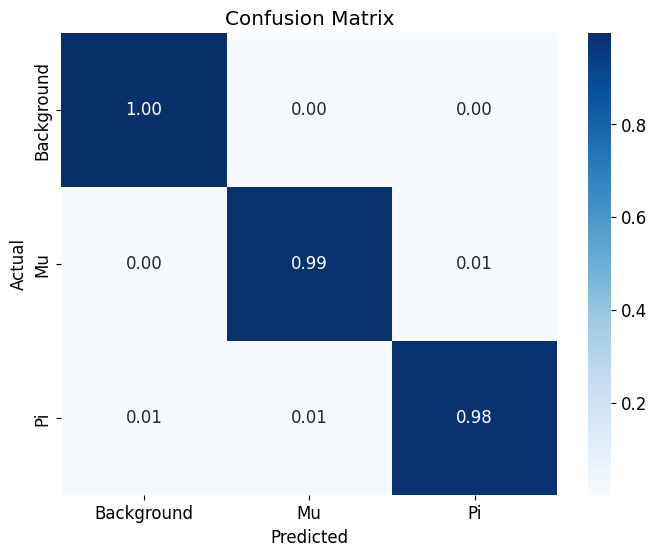

In [86]:
cm = confusion_matrix(label_encoder.transform(X_test_1[X_test_1.momentum < 1500].mass), model.predict(X_test_1[X_test_1.momentum < 1500][['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'Mu', 'Pi']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()